In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/lg/train.csv') # 학습용 데이터
df_test = pd.read_csv('/content/drive/MyDrive/lg/submission.csv') # 테스트 데이터(제출파일의 데이터)

## 2.1 데이터 전처리 - 데이터 정제

In [ ]:
## 정제 전
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


In [ ]:
## 복제된 행 제거
df_train.drop_duplicates(inplace=True)

# 무조건 converted하면서 test에 없는 회사인 25096은 삭제
del_cus_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_cus_id)]

### 결측치 채우기전 파생변수

#### 파생변수 1. bn_submit: band_submit에서 customer_position이랑 expected timeline 작성한 경우 제거

In [ ]:
df_all = pd.concat([df_train, df_test])
df_all['bn_submit'] = 0

for i in range(len(df_all)):
    tt = 0
    if df_all.iloc[i]['customer_position'] != 'none':
        df_all.iloc[i]['customer_position'] = None
        tt += 1
    if pd.notnull(df_all.iloc[i]['expected_timeline']):  # 수정된 부분
        tt += 1
    df_all.iloc[i]['bn_submit'] = df_all.iloc[i]['bant_submit'] - (tt / 4)  # 수정된 부분

df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]
df_train = df_train.drop('id', axis=1)

#### 파생변수 2. num_missing: 각 행별로 결측치의 개수 count

In [ ]:
df_all = pd.concat([df_train, df_test])
df_all['num_missing'] = df_all.isnull().sum(axis=1)

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53376 entries, 0 to 59298
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              53376 non-null  float64
 1   customer_country         52488 non-null  object 
 2   business_unit            53376 non-null  object 
 3   com_reg_ver_win_rate     14072 non-null  float64
 4   customer_idx             53376 non-null  int64  
 5   customer_type            14422 non-null  object 
 6   enterprise               53376 non-null  object 
 7   historical_existing_cnt  12297 non-null  float64
 8   id_strategic_ver         3328 non-null   float64
 9   it_strategic_ver         1108 non-null   float64
 10  idit_strategic_ver       4436 non-null   float64
 11  customer_job             37123 non-null  object 
 12  lead_desc_length         53376 non-null  int64  
 13  inquiry_type             52562 non-null  object 
 14  product_category      

### 2.1.1 오타 제어(customer_country)

In [ ]:
## 2. customer_country 오타 제어 함수
def extract_country_name(x):
    if pd.isnull(x):
        return 0
    else:
        idx=-1
        a = x.split("/")[idx].strip()
        while a=='':
            idx-=1
            if idx == -4 :
                return 'others'
            a = x.split("/")[idx].strip()
        if idx != -1:
            if a in ['Richmond Hill', 'Vancouver', 'Pickering', 'Winnipeg']:
                return 'Canada'
            elif a in ['ROURKELA', 'Guna mp', 'MADURAI', 'KOLKATA', 'Ahmedabad', 'Madurai'
                       'Mathura', 'Delhi', 'Solan', 'Bengaluru', 'Kanchipuram', 'Erode',
                       'NEARAMBEDKAR HOSPET', 'Bhubaneswar', 'LATEHAR', 'Malur', 'Ackerman',
                       'Faridabad', 'Vasal', 'Ballia', 'Ludhiana', 'Rajkot']:
                return 'India'
            elif a in ['Bergdietikon']:
                return 'Switzerland'
            elif a in ['Lagos, Nigeria', 'Ikoyi', 'Abuja', 'Windhoek']:
                return 'Nigeria'
            elif a in ['Monrovia']:
                return 'Liberia'
            elif a in ['Malvern', 'Cambridge', 'Danbury', 'Dundee', 'Boulder', 'Liverpool', 'Winston']:
                return 'United Kingdom'
            elif a in ['San Jose', 'Bulacan', 'Makati City', 'Manila', 'Cebu', 'Pasig',
                       'CALOOCAN CITY', 'dasmarinas city', 'Mandaluyong City','Angeles' 'makati', 'Angeles City',
                        'Bataan', 'TAYTAY', 'Las Piñas - Muntinlupa', 'Quezon City' ,'Valenzuela City',
                        '314 G. Araneta Ave., Quezon City', 'PASIG CITY', 'Manila', 'San Fernando City, La Union', 'Valenzuela'
                        'CAINTA', 'Quezon City', 'Camarines Sur', 'Mandaluyong', 'San Juan city', 'Qc', 'Meycauayan City, Bulacan',
                        'Parañaque','Rizal', 'Makati city', 'CITY OF IMUS', 'laGrange', 'Sanford', 'Chilhowie', 'Chesterfield', 'Amherst',
                        'Paranaque', 'Cavite', 'CITY OF MARIKINA', 'Bocaue, Bukacan, Philippines']:
                return 'Philippines'
            elif a in ['Atlanta', 'Tbilisi'] :
                return "Georgia"
            elif a in ['Oslo']:
                return 'Norway'
            elif a in ['Arroyo Hondo Viejo'] :
                return 'Dominican Republic'
            elif a in ['Midrand']:
                return 'South Africa'
            elif a in ['Olsztyn', 'Przemysłowa 4, 37-450 Stalowa Wola']:
                return "Poland"
            elif a in ['San Juan']:
                return 'Puerto Rico'
            elif a in ['Berlin', 'Weikersheim', 'Herdwangen-Schönach']:
                return 'Germany'
            elif a in ['Nassau']:
                return 'Bahamas'
            elif a in ['Sapphire', "Mission Hills", 'North Haven', 'Melbourne']:
                return 'Australia'
            elif a in ['Madrid, Spain', 'Madrid', 'Barrio Viejo De Callosa De Segura']:
                return 'Spain'
            elif a in ['Kuwait city'] :
                return 'Kuwait'
            elif a in ['Esch-sur-Alzette']:
                return 'Luxembourg'
            elif a in ['Tashkent']:
                return 'Uzbekistan'
            elif a in ['Taipei city']:
                return 'Taiwan'
            elif a in ['Tokyo']:
                return 'Japan'
            elif a in ['Thai Binh', 'Hai Duong']:
                return 'Vietnam'
            elif a in ['Buengkum']:
                return 'Thailand'
            elif a in ['Gardabaer']:
                return 'Iceland'
            elif a in ['Riyadh', "Makkah", 'Riyadh'] :
                return 'Saudi Arabia'
            elif a in ['Králův Dvůr Levín']:
                return 'Czech Republic'
            elif a in ['Cairo', 'Bloch']:
                return 'Egypt'
            elif a in ['Maseru']:
                return 'Lesotho'
            elif a in ['Colombo 03']:
                return 'Sri Lanka'
            elif a in ["Tirana"]:
                return 'Albania'
            elif a in ['70']:
                return 'others'
            elif a in ['Jakarta'] :
                return 'Indonesia'
            elif a in ['Paramaribo'] :
                return 'Suriname'
            elif a in ['Kampala']:
                return 'Uganda'
            elif a in ['DUBAI', 'Dubai']:
                return 'U.A.E.'
            elif a in ['Paradera']:
                return 'Aruba'
            elif a in ['上海', 'Shenzhen']:
                return 'China'
            elif a in ['Suva']:
                return 'Fiji'
            elif a in ['Budapest']:
                return 'Hungary'
            elif a in ['Amman']:
                return 'Jordan'
            elif a in ['QURUM']:
                return 'Oman'
            else:
                return 'United States'
        if a in ['5555', '48201', 'country', 'A'] :
            return 'others'
        elif '@' in a:
            return 'others'
        else:
            return a


In [ ]:
def cus_cty(df) :
  replace_values = {'US' : 'United States',
                    '700 Patroon Creek BlvdAlbanyNY12206' : 'United States',
                    '239 Court St, Brooklyn, NY 11201, United States' : 'United States',
                    'Little Rock, Arkansas, United States' : 'United States',
                    'CA 91915-6002' : 'United States',
                    '430 N Hamilton RdWhitehall, OH 43213, USA' : 'United States',
                    '1110 Morse Rd, Columbus, Ohio, 43229, United States' : 'United States',
                    '1755 North Brown Rd. Suite 200 Lawrenceville, GA 30043' : 'United States',
                    'Miami, Florida, United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '85 W Main St Suite C, Canton, GA 30114' : 'United States',
                    '101 MetLife Way, Cary, NC, 27513 – MET1' : 'United States',
                    '7105 Northland Terrace N, Minneapolis, MN 55428' : 'United States',
                    'CA 95814' : 'United States',
                    '1275 Sister Grove Rd Van Alstyne, TX 75495' : 'United States',
                    '100 Vestavia ParkwayBirminghamAL35216' : 'United States',
                    'CA 92618 United States' : 'United States',
                    'Rio de Janeiro' : 'Brazil',
                    '1605 Ave. Ponce de León, Suite 400 San Juan, 00909, Puerto Rico' : 'Puerto Rico',
                    'IL 60069' : 'United States',
                    '28001 238th St, Le Claire, IA 52753, USA' : 'United States',
                    'Grapevine, Texas, United States United States' : 'United States',
                    '700 District Dr, Itasca, IL 60143 United States' : 'United States',
                    '6398 College Blvd, Overland Park, KS 66211, United States' : 'United States',
                    '3804 W Broadway St, Ardmore, OK 73401, United States' : 'United States',
                    'New York City Metropolitan Area, United States': 'United States',
                    '2529 W Busch Blvd Suite 1000, Tampa, FL 33618, United States' : 'United States',
                    '1100 ITBProvoUT84602' : 'United States',
                    'Telangana' : 'India',
                    'Jeffersonville, IN United States' : 'United States',
                    '6564 Headquarters DrPlanoTX7505' : 'United States',
                    '1817 S Washington AveTitusville, FL 32780, USA' : 'United States',
                    '63 Flushing Ave Bldg 303, Suite 804, Brooklyn, NY 11205, United States' : 'United States',
                    '717 General Booth BlvdVirginia Beach, VA 23451, USA' : 'United States',
                    '2877 Prospect Rd, Fort Lauderdale, FL 33309' : 'United States',
                    'bangalore' : 'India',
                    'MI 48827' : 'United States',
                    '810 N KINGSTON DR PEORIA, IL 61604-2145' : 'United States',
                    'OH 45215, USA' : 'United States',
                    '3801 E Willow St, Long Beach, CA 90815, EE. UU.' : 'United States',
                    'Clinton, OK 73601' : 'United States',
                    'Ha Noi' : 'Vietnam',
                    'ARGENTINA' : 'Argentina',
                    '3100 Shore Drive Virginia Beach, VA 23451' : 'United States',
                    'Los Angeles, California, United States' : 'United States',
                    'West Caldwell NJ 07960 United States' : 'United States',
                    '881 S Division St, Buffalo, NY 14210, United States' : 'United States',
                    '12718 Kitten Trail, Hudson, FL 34669' : 'United States',
                    'FL 33772' : 'United States',
                    '13351 Dovers St, Waverly, NE 68462, United States' : 'United States',
                    'Jacksonville Florida' : 'United States',
                    'Ohio United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '6564 Headquarters DrPlanoTX75051' : 'United States',
                    'RJ' : 'Brazil',
                    'TX 78572 United States' : 'United States',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119 ' : 'United States',
                    '993 Niagara Ave, San Diego, CA 92107 United States' : 'United States',
                    'Four Embarcadero Center Suite 1400 #85, San Francisco, CA 94111 United States' : 'United States',
                    'odisha' : 'India',
                    'lucknow' : 'India',
                    '1036 n nalder st' : 'United States',
                    'United States 32901' : 'United States',
                    '2100 Engineer Rd, Oakland, CA 94607, United States' : 'United States',
                    'Via E. De Amicis, 23 . 90044 Carini (PA)' : 'Italy',
                    '136 S IndustrialSalineMI48176' : 'United States',
                    '335 League St S, Sulphur Springs, TX 75482' : 'United States',
                    'United States 14503.' : 'United States',
                    'gurgaon' : 'India',
                    '30 Winter Street Boston, MA 02108' : 'United States',
                    '275 John Hancock Rd. Taunton, MA, 02780' : 'United States',
                    'MA 02062 United States' : 'United States',
                    'Pune' : 'India',
                    'FL 33025' : 'United States',
                    'Bari, Italy' : 'Italy',
                    '8 Gay St, Christiana, PA 17509 United States' : 'United States', # 게이 뭐노 ㅋ,
                    '500 N Highway 89 North, Prescott AZ 86313 United States' : 'United States',
                    '609 Medical Center Dr. Decatur, Texas, 76234'  : 'United States',
                    '7703 Floyd Curl Dr MC 7800, San Antonio TX 78229 United States' : 'United States',
                    'St Cloud, MN 56303' : 'United States',
                    '7581 S Franklin Way, Centennial, CO 80122, United States' : 'United States',
                    # '' : 'United States',
                    'Honduras' : 'Honduras',
                    'CARRERA 11A 94-46 EDIFICIO CHICO 3000 PISO 3 BOGOTA' : 'Colombia',
                    'Netherlands Antilles' : 'Netherlands',
                    '823 Gateway Center Way, San Diego, CA 92102' : 'United States',
                    'Colombia  Cartagena' : 'Colombia',
                    'Cuiabá' : 'Brazil',
                    'CO 80127' : 'United States',
                    'TX 75098' : 'United States',
                    'MO 64506' : 'United States',
                    '1222 Eastwick CirMurphy, TX 75094, United States' : 'United States',
                    '545 West 111th st Suite 7C' : 'United States',
                    'P.O. Box 291992, Port Orange, FL 32129' : 'United States',
                    'Isle of Man' : 'United Kingdom', # 아일랜드해안에 있지만, 영국왕국과 결합되어 있다함(사실 별도의 영토는 맞긴한데, 일단 영국으로)
                    'NY 10566 United States' : 'United States',
                    'GA 30039' : 'United States',
                    'Centro de Produção Audiovisual - Sesc São Paulo' : 'Brazil',
                    'Aparecida' : 'Brazil',
                    'Colombia - cartagena' : 'Colombia',
                    'Capão da canoa' : 'Brazil',
                    'São Paulo' : 'Brazil',
                    '1919 Minnesota Ct, Mississauga, ON L5N' : 'Canada',
                    '54 Sugar Creek Center Blvd #300, Sugar Land, TX 77478, United States' : 'United States',
                    'João Pessoa' : 'Brazil',
                    'PerU' : 'Peru',
                    'TN 38120' : 'United States',
                    'Richardson, Texas, United States' : 'United States',
                    'Sao Paulo' : 'Brazil',
                    '2367 N 2650 WFarr WestUT84404' : 'United States',
                    '4880 Stevens Creek BlvdSan JoseCA95129' : 'United States',
                    '3131 BriarPark Dr Suite 200HoustonTX77042' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '1397 Etowah DriveAtlantaGA30319' : 'United States',
                    '3 Nasson Avenue' : 'United States',
                    'Largo, Florida, United States United States' : 'United States',
                    'FL 33013' : 'United States',
                    'Bucaramanga' : 'Colombia',
                    '7610 Market St, Canton, MI 48187, United States' : 'United States',
                    '116 Village Blvd Suite 200, Princeton, NJ 08540 United States' : 'United States',
                    'Dourados' : 'Brazil',
                    'Foz de Iguaçu - PR Avenida Tancredo Neves 6731 Jardim Itaipu' : 'Brazil',
                    'St Maarten' : 'France', # 프랑스, 네델란드간 분쟁 지역 (프랑스가 더 쌤)
                    'Recife' : 'Brazil',
                    'São Paulo, Pinheiros' : 'Brazil',
                    'Cartagena' : 'Colombia',
                    'Firenze, Italy' : 'Italy',
                    'OR 97128' : 'United States',
                    'Colombia C2: Solo información' : 'Colombia',
                    'Ironhorse Customs LLC 4443 Genella Way North Las Vegas, NV 89031' : 'United States',
                    'San Francisco, CA 94128, United States' : 'United States',
                    '14700 Caribbean Way' : 'United States',
                    'Bus Shed, 6501 Red Hook Rd #201, Nazareth, St Thomas 00802, U.S. Virgin Islands' : 'United States',
                    '1600 Rosecrans Ave bldg 7 ste 101, Manhattan Beach, CA 90266,' : 'United States',
                    'FL 32703' : 'United States',
                    'AGOST, ALICANTE' : 'Spain',
                    'Ohio' : 'United States',
                    'NV 89119' : 'United States',
                    'VA 22209' : 'United States',
                    'NY' : 'United States',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51 ' : 'Greece',
                    'SPAIN ' : 'Spain',
                    'MADRID' : 'Spain',
                    'ELCHE, ALICANTE' : 'Spain',
                    '1800 Congress Ave., Austin, TX 78701' : 'United States',
                    'CA 92657 United States' : 'United States',
                    '9631 Liberty Rd B, Randallstown, MD 21133' : 'United States',
                    'Benbrook, TX 76126' : 'United States',
                    'SC 29555' : 'United States',
                    '6252 E Grant Rd suite 150 Tucson, AZ 85712' : 'United States',
                    'MO 64802 ' : 'United States',
                    'gujarat' : 'India',
                    'IN 46601, EE. UU.' : 'United States',
                    'Warren, OH 44483.' : 'United States',
                    '1 Hoag Dr.' : 'United States',
                    '210 Route 4 East Fl 4' : 'United States',
                    '21903 Ranier Ln' : 'United States',
                    'NY 11358' : 'United States',
                    'CA 95618' : 'United States',
                    'New Hampshire' : 'United States',
                    'GA 31405' : 'United States',
                    'Wyckoff, NJ 07481, USA' : 'United States',
                    '750 Florida Central Parkway Suite #100 Longwood, FL 32750' : 'United States',
                    'FL 33404' : 'United States',
                    '101 Clyde Ave Longwood, FL 32750, USA' : 'United States',
                    'CA' : 'United States',
                    'IL 61615' : 'United States',
                    'Herndon, VA 20170' : 'United States',
                    '724 W Business US Highway 60, Dexter, MO 63841,' : 'United States',
                    'Square at, 2662 Gateway Rd Suite 165, Carlsbad, CA 92009' : 'United States',
                    '1156 W Armitage Ave suite b, Chicago, IL 60614, US.' : 'United States',
                    'MO 63103, USA' : 'United States',
                    'MO 63103' : 'United States',
                    'GRAN CANARIAS PLAYA DEL INGLES' : 'Spain',
                    'CACERES' : 'Spain',
                    '4278 S Buffalo St  Orchard Park, NY 14127' : 'United States',
                    '1775 Liberty Dr, Fort Belvoir, VA 22060, United States' : 'United States',
                    '8569 Sudley Rd Ste C Historic District, Manassas, VA 20110, USA' : 'United States',
                    'MA 02780' : 'United States',
                    'MN 55024' : 'United States',
                    'Delmar, NY 12054 United States' : 'United States',
                    'IL 60638 United States' : 'United States',
                    'MO 64108' : 'United States',
                    'CA 92078' : 'United States',
                    'IL 60563United States' :  'United States',
                    'SD 57751' : 'United States',
                    '990 S Madera Ave, Kerman, CA 93630, United States' : 'United States',
                    '135 Broadway, Schenectady, NY 12305, United States' : 'United States',
                    '1491 Furnace St, Montgomery, AL 36104, United States' : 'United States',
                    '1385 N Weber Rd, Romeoville, IL 60446,' : 'United States',
                    '463 Industrial Park Rd, Elysburg, PA 17824, US' : 'United States',
                    'CA 94555 United States' : 'United States',
                    'UT 84116' : 'United States',
                    '990 Biscayne Dr, Concord, NC 28027, United States' : 'United States',
                    'Nicolosi (CT), Italy' : 'Italy',
                    'FL 33442' : 'United States',
                    'FL 33716' : 'United States',
                    '3440 Rockefeller Ct Waldorf, MD 20602' : 'United States',
                    'Arlington, NY 12603' : 'United States',
                    '65 Grove Street, Suite 204  Watertown, MA 02472' : 'United States',
                    '13854 Lakeside Cir Sterling Heights, MI 48313' : 'United States',
                    '9110 Forest CrossingThe WoodlandsTX77381' : 'United States',
                    'OK 73601 United States' : 'United States',
                    'Hacienda Heights, California, United States' : 'United States',
                    'Connecticut United States' : 'United States',
                    'Caldwell, New Jersey, United States United States' : 'United States',
                    'Gujarat' : 'India',
                    'Chennai' : 'India',
                    'Jamaica, NY 11417, USA' : 'United States',
                    'indore' : 'India',
                    'US Virgin Islands' : 'United Kingdom', # 영국이랑 가까워서 영국으로 해놓음
                    'KS 66217' : 'United States',
                    'NJ 07013' : 'United States',
                    'TX 77024' : 'United States',
                    '30 Cambria Ave, Pleasantville, NJ 08232' : 'United States',
                    '4278 S Buffalo St Orchard Park, NY 14127' : 'United States',
                    '723 S Valley Way, Palmer, AK 99645' : 'United States',
                    'Zip 98433' : 'United States',
                    'bhilwara' : 'India',
                    'ND' : 'United States', # 노스다코타주(미국 도시이름) 줄임말 같음
                    'VT 05672' : 'United States',
                    '800 3rd Ave 3rd floor, New York, NY 10022' : 'United States',
                    'BR' : 'Brazil', # 브라질 iso국가부호
                    'kerela' : 'India',
                    'uttar pradesh' : 'India',
                    'Anand Vihar Delhi' : 'India',
                    'hyderabad' : 'India',
                    "Via dell'informatica 10 - 37036 San Martino Buon Albergo (Veneto), Italy" : ' Italy',
                    'Belo Horizonte' : 'Brazil',
                    '15806 Longship Ct' : 'United States',
                    '2350 Airport FrwyBedfordTX76022' : 'United States',
                    '1999 S Bascomb AveSuite 1000CampbellCA95008' : 'United States',
                    '9716 McFarring DrFort WorthTX76244' : 'United States',
                    '200 cabelLouisvilleKY40206' : 'United States',
                    '1112 Badger Vine LaneArlingtonTX76005' : 'United States',
                    '6111 W Plano Pkwy #2100PlanoTX75093' : 'United States',
                    '100 Sabine River Dr.HuttoTX78634' : 'United States',
                    '6300 Harry Hines BlvdSte. 1400DallasTX75235' : 'United States',
                    '100 first stSan FranciscoCA94015' : 'United States',
                    '899 Kifer RoadSunnyvaleCA94086' : 'United States',
                    '2217 HOUSTON DRIVEMelissaTX75454' : 'United States',
                    '829 Jackson ave' : 'United States',
                    '3027 West Bay Villa Ave' : 'United States',
                    '126 Diablo Ranch Court' : 'United States',
                    '1537 Rolling Hills Dr.' : 'United States',
                    '1715 Forest Cove Drive,  Apt 201' : 'United States',
                    '410 Baylor StAustinTX78703' : 'United States',
                    '9111 cypress waters blvdDallasTX75038' : 'United States',
                    '9420 West Sam Houston Pkwy NHoustonTX77018' : 'United States',
                    '6 Kimball LaneLynnfieldMA1940' : 'United States',
                    '9820 Northcross Center CtHuntersvilleNC28078' : 'United States',
                    '9800 S. Monroe StreetSandyUT84070' : 'United States',
                    '2475 Washington BlvdOgdenUT84401' : 'United States',
                    '400 Centre StNewtonMA2458' : 'United States',
                    '400 Centre StreetNewtonMA2458' : 'United States',
                    '36 Margin StPeabodyMA1960' : 'United States',
                    '77 Massachusetts AveCambridgeMA2139' : 'United States',
                    '160 Gould St Ste 300, Needham Heights, Massachusetts 02494NeedhamMA2721' : 'United States',
                    '9 Landsdowne StreetBostonMA2215' : 'United States',
                    '1209 Derby Run Carrollton, TX 75007CarrolltonTX75007' : 'United States',
                    'One Constitution RoadBostonMA2129' : 'United States',
                    '252 Beech AvenueMelroseMA2176' : 'United States',
                    '5301 Stevens Creek BlvdSanta ClaraCA95051' : 'United States',
                    '230 Highland Ave, Suite 531SomervilleMA2143' : 'United States',
                    '7700 West Sunrise BlvdPlantationFL33322' : 'United States',
                    '602 Saber Creek Drive' : 'United States',
                    '11330 Clay RdHoustonTX77041' : 'United States',
                    '1 Skyview drFort WorthTX76155' : 'United States',
                    '416 Panzano Drive' : 'United States',
                    '5501 Headquarters DrPlanoTX75024' : 'United States',
                    '2266 Palmer Dr.' : 'United States',
                    '1380 Enterprise Dr' : 'United States',
                    '6601 Carroll Highlands Rd' : 'United States',
                    '275 Mishawum Road' : 'United States',
                    '222 Maxine Dr' : 'United States',
                    '2900 Highway 280Suite 250BirminghamAL35223' : 'United States',
                    '305 John Street' : 'United States',
                    'MA 01851' : 'United States',
                    '600 5th Street' : 'United States',
                    'IL 60191' : 'United States',
                    'Cra. 51 #12 sur-75, San Fernando, Itagüi, Medellín, Guayabal, Medellín, Antioquia, Colombia' : 'Colombia',
                    '3000 Montour Church Road' : 'United States',
                    '9820HuntersvilleNC28078' : 'United States',
                    '152 Bowdoin Street' : 'United States',
                    'PO Box 112292CarrolltonTX75011' : 'United States',
                    '825 Eastlake Ave E' : 'United States',
                    '955 Powell Ave SW' : 'United States',
                    '2047  w summerdale ave' : 'United States',
                    '1560 Chance Ct' : 'United States',
                    '8454 Muirwood TrlFort WorthTX76137' : 'United States',
                    '1503 LBJ ParkwaySuite 700Farmers BranchTX75234' : 'United States',
                    '7673 HEMPSTON CIR' : 'United States',
                    '1808 Lithgow RdCelinaTX75009' : 'United States',
                    '1001 Main St' : 'United States',
                    '1909 Forest Knoll DrHooverAL35244' : 'United States',
                    '106 Lakeview DrHomewoodAL35209' : 'United States',
                    '24082 Carmel Dr' : 'United States',
                    '417 20th St NBirminghamAL35203' : 'United States',
                    '594 Howard StSan FranciscoCA94105' : 'United States',
                    '594 Howard StSan FranciscoCA94106' : 'United States',
                    '31700 Temecula Parkway, Temecula CA 92592 United States' : 'United States',
                    '300 East Park Drive' : 'United States',
                    'Manaus' : 'Brazil',
                    'SPAIN' : 'Spain',
                    ', MO 64802' : 'United States',
                    'Columbia' : 'Colombia',
                    'Canda' : 'Canada',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51' : 'Greece',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119' : 'United States',
                    '6005 Commerce Dr. Ste. 300' : 'United States',
                    '17215 Welby Way' : 'United States',
                    '45 n 200 wWillardUT84340' : 'United States',
                    'Swaziland' : 'Switzerland',
                    'Nevada' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501,' : 'United States',
                    'MO 64108.' : 'United States',
                    'mumbai' : 'India',
                    'Barranquilla' : 'Colombia',
                    'UAE Dubai' : 'U.A.E.',
                    'COLOMBIA' : 'Colombia',
                    'Türkiye' : 'Turkey',
                    'EGYPT' : ' Egypt',
                    'Democratic Republic of the Congo' : 'Congo',
                    'St Kitts' : 'Saint Kitts and Nevis',
                    'Antigua' : 'Antigua and Barbuda',
                    'Ivory Coast' : "Cote d'Ivoire",
                    'British Virgin Islands' : 'United Kingdom',
                    '85 W Main St Suite C, Canton, GA 30114,' : 'United States',
                    'Turks and Caicos Islands' : 'United Kingdom',
                    'VALENCIA' : 'Spain',
                    'Dominican republic': 'Dominican Republic',
                    'UNITED STATES': 'United States',
                    'NE' : 'United States',
                    'FL' : 'United States',
                    'TX' : 'United States',
                    'NJ' : 'United States',
                    'NIM' : 'United States',
                    'NM' : 'United States',
                    'Englewood, CO' : 'United States',
                    'W126 N7449 Flint Drive Menomonee Falls VA' : 'United States',
                    '3 Center Plz Suite 330 Boston, MA 02108' : 'United States',
                    'Curaçao': 'Netherlands',
                    '5003 Lady Of The Lake Dr  Raleigh NC': 'United States',
                    '233 South Beaudry Avenue  Los Angeles CA': 'United States',
                    '603 Heritage Drive  Mount Juliet': 'United States',
                    'Sandford': 'United Kingdom',
                    'BLOOMSBURY': 'United Kingdom',
                    'Southfield': 'United States',
                    'Indianapolis': 'United States',
                    'maharashtra': 'India',
                    'Salt Lake City': 'United States',
                    'New York': 'United States',
                    'Soufriere': 'Saint Lucia',
                    'Mumbai': 'India',
                    'San Diego': 'United States',
                    'Batavia': 'Indonesia',
                    'Bangalore': 'India',
                    'Houston': 'United States',
                    }

  df['customer_country'] = df['customer_country'].replace(replace_values)
  return df

In [ ]:
## 2. customer_country
df_train["customer_country"] = df_train["customer_country"].apply(extract_country_name)
df_test["customer_country"] = df_test["customer_country"].apply(extract_country_name)

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)

In [ ]:
# df_country 결측치 채우기 -> 담당 자사 법인명 기준으로 많이 의뢰한 국가로 채워보자
df_all = pd.concat([df_train, df_test])
df_c = df_all.groupby(['response_corporate', 'customer_country'])["is_converted"].count().reset_index()

def get_max_group(group):
    max_row = group.loc[group['is_converted'].idxmax()]
    return max_row['customer_country']

result = df_c.groupby('response_corporate').apply(get_max_group)

zero_indices = df_train.index[df_train['customer_country']==0]
for index in zero_indices:
    df_train.loc[index, 'customer_country']=result[df_train.loc[index, "response_corporate"]]

### 2.1.2 오타제어(customer_position --> 상위 10개만 살리자)

In [ ]:
def position_refine(df):
    replace_words={
        'other': 'other',
        'this is a consume display requirement for home purpose.':'other',
        'vicepresident': 'vice president',
        'bulgaria' : 'other',
        'lider de desarrollo': 'ceo/founder',
        'decision-influencer': 'ceo/founder',
        'decision-maker': 'ceo/founder',
        'architecture/consult' : 'architect/consultant',
        'software /solution provider' :  'software/solution provider',
        'vp' : 'vice president',
        'prof.' : 'professor',
        'pgt Physcis': "post graduate teacher in physics",
        'asst prof.': 'assistant professor',
        'ceo/fundador': 'ceo/founder',
        'gerente': 'manager',
        'tierarzt': 'veterinarian',
        'técnico' : 'technician',
        'exhibitiontv' : 'other',
        'proprietário(a)' : 'owner',
        'genel müdür' : 'ceo/founder',
        'mindenes' : 'other',
        'főorvos' : 'chief physician',
        'surgery professional' : 'surgeon',
        'research': 'researcher',
        'the big boss': 'ceo/founder',
        'radiology professional' : 'radiologist',
        'associate professor in electornics engg': 'associate professor',
        'assistant professor of enlish': 'assistant professor',
        'consulting': 'consultant',
        'education': 'educator',
        'education professional': 'educator',
        'english trainer for ielts,toefl,pte,gre,sat exams.' : 'english trainer',
        'entrylevel': 'entry level',
        'exhibitiontv': 'exhibitiontv',
        'founder': 'ceo/founder',
        'no influence': 'other',
        'c-levelexecutive': 'c-level executive',
        'others': 'other',
        'none': 'other',
    ## 상위 10개로 분류
        'leader': 'ceo/founder',
        'av management': 'manager',
        'business partner': 'partner',
        'business unit director': 'director',
        'chairman': 'manager',
        'chief executive officer': 'ceo/founder',
        'commercial end-user': 'end-user',
        'decision influencer': 'ceo/founder',
        'decision maker' : 'leader',
        'leadership/executive office/owner': 'ceo/founder',
        'market intelligence/research': 'associate/analyst',
        'owner': 'ceo/founder',
        'principal & director': 'director',
        'product management': 'manager',
        'intern': 'trainee'
    }
    df['customer_position'].replace(replace_words, inplace=True)
    return df

In [ ]:
df_train = position_refine(df_train)
df_test = position_refine(df_test)

In [ ]:
def preprocess_customer_position(df):

    # 가장 많이 나오는 변수 상위 10개를 저장
    top10_positions = df['customer_position'].value_counts().index[:10]

    # 상위 10개에 속하지 않는 경우 'other'로 변경
    df['customer_position'] = df['customer_position'].apply(lambda x: x if x in top10_positions else 'other')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_position(df_train)
df_test = preprocess_customer_position(df_test)

### 2.1.3 오타제어(customer_type) --> 상위 3개 or 5개만 살리자

In [ ]:
def cus_type_typo(df) :

  #  == 오타 먼저 전처리 ==
  replace_values_typo = {
      'End Customer' : 'End-Customer',
      'Other' : 'Others',
      'Etc.' : 'Others',
      'End-user' : 'End-Customer',
      'Specifier / Influencer' : 'Specifier/ Influencer',
      'Home Owner' : 'Homeowner',
      'Corporate' : 'Installer/Contractor',
      'Software / Solution Provider' : 'Software/Solution Provider',

  }

  # == 대체하기 ==
  replace_values =  {
      'Solution Eco-Partner' : 'Service Partner',
      'Engineer' : 'Specifier/ Influencer',
      'HVAC Engineer' : 'Specifier/ Influencer',
      'Technician' : 'Specifier/ Influencer',
      'Consultant' : 'Service Partner',
      'Developer' : 'Specifier/ Influencer',
      'Homeowner' : 'End-Customer',
      'Software/Solution Provider' : 'Service Partner', # 종합적인 solution을 제공한다고 생각하여 SP
      'Software / Solution Provider' : 'Service Partner', #
      'Manager / Director' : 'Specifier/ Influencer',
      'Installer' : 'Channel Partner', # 설치업자는 현장 설치를 전문적으로 수행한다고 생각함
      'Installer/Contractor' : 'Channel Partner',
      'Architect/Consultant' : 'Service Partner',
      'Distributor' : 'Channel Partner',
      'Reseller' : 'Channel Partner',
      'Dealer/Distributor' : 'Channel Partner',
      'System Integrator' : 'Service Partner',
      'Technical Assistant' : 'Service Partner',
      'Commercial end-user' : 'End-Customer',
      'Administrator' : 'Channel Partner',
      'Interior Designer' : 'Specifier/ Influencer'
  }
  df['customer_type'] = df['customer_type'].replace(replace_values_typo)
  df['customer_type'] = df['customer_type'].replace(replace_values)

  # 결측치 처리
  df['customer_type'].fillna('Unknown', inplace = True)

  return df

df_train = cus_type_typo(df_train)
df_train['customer_type'].value_counts()

Unknown                  38954
End-Customer             10117
Specifier/ Influencer     2443
Channel Partner           1368
Service Partner            474
Others                      20
Name: customer_type, dtype: int64

# custoemr_job

In [ ]:
def cus_job_typo(df):

  # == 오타 먼저 전처리 ==
  replace_values = {
      'graphic/color art' : 'arts and design',
      '3d/vfx art' : 'arts and design',
      'clinical specialist' : 'healthcare services',
      'radiology professional' : 'healthcare services',
      'medical imaging specialist' : 'engineering',
      'surgery professional' : 'healthcare services',
      'pathologist' : 'healthcare services',
      'art and design' : 'arts and design',
      'programm-_und_projektmanagement' : 'program and project management',
      'engineering & technical' : 'engineering',
      'technical' : 'engineering',
      'medien_und_kommunikation' : 'media and communication',
      'finanzen' : 'finance',
      'designer' : 'arts and design',
      'information_technology' : 'information technology',
      'kreation_und_design' : 'arts and design',
      'sonstiges' : 'other',
      'arts_and_design' : 'arts and design',
      'otro' : 'other',
      'computing & it' : 'information technology',
      'it director' : 'information technology',
      'engineer' : 'engineering',
      'program_and_project_management' : 'program and project management',
      'surgery professional' : 'healthcare services',
      'clinic' : 'healthcare services',
      'projektmenedzsment\tprogram and project management' : 'program and project management',
      'information technology​' : 'information technology',
      'it' : 'information technology',
      'healthcare_services' : 'healthcare services',
      'amministrativo' : 'administrative',
      'surgery professional​' : 'healthcare services',
      'adminisztráció' : 'administrative',
      'pénzügy' : 'finance',
      'radiology  professional' : 'healthcare services',
      'healthcare professionals' : 'healthcare services',
      'it - information technology' : 'information technology',
      'engineering & technical executive' : 'engineering',
      'program_and_project_manager' : 'program and project management',
      'administration' : 'administrative',
      'tech' : 'engineering',
      'it/software' : 'information technology',
      'arte_e_design' : 'arts and design',
      'program-_és_projektmenedzsment' : 'program and project management',
      'others' : 'other',
      'medical solution provider' : 'engineering',
      'owner' : 'entrepreneurship',
      'manager' : 'product management',
      'project manager' : 'program and project management',
      'curation' : 'arts and design',
      'quality assurance' : 'engineering',
      'general management' : 'business development',
      'architect' : 'engineering',
      'gm' : 'business development',
      'decision maker' : 'business development',
      'ceo' : 'entrepreneurship',
      'lead' : 'entrepreneurship',
      'director' : 'business development',
      'purchaser' : 'purchasing',
      'buyer' : 'purchasing',
      'arquitecto/consultor' : 'consulting',
      'executive' : 'entrepreneurship',
      'vertrieb' : 'marketing',
      'ceo/founder' : 'entrepreneurship',
      'general manager' : 'operations',
      'arquitecto/consultor' : 'consulting',
      'military and protective services' : 'other',
      'community_and_social_services' : 'other',
      'installer' : 'operations',
      'consultant' : 'consulting',
      'revendedor' : 'sales',
      'research & development' : 'research',
      'procurement' : 'operations',
      'coordinator' : 'entrepreneurship',
      'integrador' : 'operations',
      'integrator' : 'operations',
      'operations manager ' : 'operations',
      'it manager' : 'information technology',
      'advertising' : 'marketing',
      'chief engineer' : 'engineering',
      'business_development' : 'business development',
      'project coordinator' : 'program and project management',
      'vendite' : 'sales',
      'medical solution  provider' : 'healthcare services',
      'media_e_comunicazione' : 'media and communication',
      'egyéb' : 'other',
      'pm' : 'program and project management',
      'account management' : 'accounting',
      'quality_assurance' : 'sales',
      'associate/analyst' : 'finance',
      'general contractor' : 'operations',
      'contractor' : 'operations',
      'reseller' : 'sales',
      'institute & academy' :  'education',
      'other stores' : 'other',
      'educator' : 'education',
      'distributor' : 'sales',
      'medical imaging  specialist' : 'engineering',
      'sales manager' : 'sales',
      'purchasing agent' : 'purchasing',
      'művészet_és_design' : 'arts and design',
      'av tech' : 'information technology',
      'administrative assistant' : 'administrative',
      'média_és_kommunikáció' : 'media and communication',
      'sales manager' : 'product management',
      'purchase' : 'purchasing',
      'sales operations' : 'sales',
      'procurement specialist' : 'purchasing',
      'distribuidor' : 'sales',
      'marketing executive' : 'marketing',
      'coo' : 'entrepreneurship',
      'field marketing' : 'marketing',
      'vice president' : 'other',
      'technical director' : 'engineering',
      'planner' : 'operations',
      'producer' : 'product management',
      'product marketing' : 'marketing',
      'project architect' : 'engineering',
      'operations executive' : 'operations',
      'operations manager' : 'operations',
      'higher education (college & university)' : 'education',
      'director of it' : 'information technology',
      'design' : 'arts and design',
      'project lead' : 'program and project management',
      'recommend (you recommend specific products or technologies for the solution)' : 'consulting',
      'project head' : 'program and project management',
      'medios_de_comunicación' : 'media and communication',
      'sales executive' : 'sales',
      'solution provider'  : 'consulting',
      'üzemeltetés' : 'operations',
      'értékesítés' : 'sales',
      'influencer' : 'marketing',
      'interior designer' : 'arts and design',
      'leader' : 'entrepreneurship',
      'implement' : 'operations',
      # 'hr' : '' 보류
      'marketing operations' : 'operations',
      'following up' : 'sales',
      'supervisor' : 'operations',
      'management' : 'program and project management',
      'user' : 'sales',
      'cliente final' : 'sales',
      'president' : 'other',
      'event marketing' : 'marketing',
      'collaboration & web apps' : 'information technology',
      'sales engineering' : 'engineering',
      'estimator' : 'engineering',
      'end user' : 'sales',
      'altro' : 'other',
      'project director' : 'program and project management',
      'admin' : 'administrative',
      'technical marketing' : 'marketing',
      'railway & metro station' : 'operations',
      'graphic design' : 'arts and design',
      'fashion' : 'arts and design',
      'account exec/manager' : 'accounting',
      'purchasing manager' : 'purchasing',
      'details send' : 'operations',
      'pacs administrator' : 'healthcare services',
      'it specialist' : 'information technology',
      'autres' : 'other',
      'electronics & telco' : 'engineering',
      'medical solution provider' : 'healthcare services',
      'emerging technology / innovation' : 'engineering',
      'infrastructure' : 'operations',
      'designer/ project manager' : 'other', # 너무 애매함
      'restaurant display' : 'other',
      'test4' : 'other',
      'energy' : 'engineering',
      'broadcasting & media' : 'media and communication',
      'systems administrator' : 'administrative',
      'customer experience' : 'other',
      'field / outside sales' : 'sales',
      'sourcing / procurement' : 'operations',
      'chief of engineering' : 'engineering',
      'designers' : 'arts and design',
      'design/build' : 'arts and design',
      'it hardware technician ' : 'engineering',
      'electrical contractor' : 'operations',
      'systems design' : 'arts and design',
      'it admin' : 'information technology',
      'property owner' : 'real estate',
      'menu' : 'other',
      'sme' : 'entrepreneurship',
      'design/install/training/support' : 'arts and design',
      'electronics evaluator' : 'operations',
      'assist in serving food' : 'support',
      'underboss' : 'entrepreneurship',
      'community theater' : 'support',
      'cintractor' : 'operations',
      'it support' : 'information technology',
      'building owner' : 'real estate',
      'teacher' : 'education',
      'it project lead' : 'information technology',
      'hardware design engineer' : 'engineering',
      'it dairector' : 'information technology',
      'designer/ engineer' : 'other',  # 경계 모호
      'design and install' : 'arts and design',
      'designer, creative technologist' : 'arts and design',
      'primary end-user' : 'sales',
      'it department' : 'information technology',
      'designer/installer' : 'arts and design',
      'medical solution provider​' : 'healthcare services',
      'photographer' : 'arts and design',
      'no respoxse on phone will try again ' : 'other',
      'product_management' : 'product management',
      'solution engineer' : 'engineering',
      'reseller/integrator' : 'sales',
      'facilitator installation services' : 'operations',
      'display' : 'engineering',
      'media and communications' : 'media and communication',
      'av project manager' : 'program and project management',
      'otros' : 'other',
      'architect ass interiores' : 'arts and design',
      'requirement close' : 'other',
      'system designer, integrator' : 'arts and design',
      'no requirment' : 'other',
      'corporate / office' : 'entrepreneurship',
      'colorist' : 'arts and design',
      'engineering, design, and install' : 'other',  # 경계 모호
      'software solution' : 'consulting',
      'serving food' : 'support',
      'doctor' : 'healthcare services',
      'manufacturing factory / plant' : 'operations',
      'waiter' : 'support',
      'chief' : 'entrepreneurship',
      'contributor' : 'support',
      'purchsing' : 'purchasing',
      'chef' : 'other',
      'designer purchaser' : 'arts and design',
      'authorize (you are responsible for making the final decision)' : 'business development',
      'a/v project manager' : 'program and project management',
      'final approval' : 'other',
      'design engineer' : 'arts and design',
      'inquiry-to-buy/contact-us test' : 'operations',
      'director of lodging' : 'operations',
      'lead engineer' : 'engineering',
      'design/purchaser' : 'other', # 경계 모호
      'technology consultant' : 'consulting',
      'project manager/designer' : 'program and project management',
      'no respoxse on phone will try again' : 'other',
      'consultent' : 'consulting',
      'elevator company' : 'entrepreneurship',
      'for confrence' : 'operations',
      'distributor quotation' : 'operations',
      'quoting project' : 'administrative',
      'manger' : 'product management', # 임의로 넣어둠
      'design consultant' : 'consulting',
      'project engineer' : 'engineering',
      'conference room' : 'other',
      'it hardware technician' : 'information technology',
      'designer/pm/gc' : 'other',
      'furnish and install' : 'other',
      'videowall' : 'other',
      'it tech.' : 'information technology',
      'projectr mgmt' : 'program and project management',
      'facility administrator' : 'administrative',
      'software developer' : 'information technology',
      'principal' : 'education',
      'home theater' : 'other',
      'team lead' : 'program and project management',
      'serving robot' : 'operations',
      'nothing' : 'other',
      'cctv view' : 'operations',
      'product researcher' : 'research',
      'purchase dept' : 'sales',
      'instructor' : 'education',
      'decider' : 'business development',
      'seller installer' : 'sales',
      'general manager (decision maker)' : 'business development',
      'procurment' : 'operations',
      'f&b director for bicycle casino' : 'other',
      'supplier and installation ' : 'sales',
      'managing director' : 'program and project management',
      'sales rep' : 'sales',
      'installer/sales rep' : 'sales',
      'cctv monetoring' : 'operations',
      'department secretary' : 'administrative',
      'r&d project manager' : 'program and project management',
      'facilities and operations' : 'operations',
      'component of video wall' : 'other',
      'systems engineer' : 'engineering',
      'installer.' : 'operations',
      'principal in charge' : 'program and project management',
      'fixing tv' : 'other',
      'director of engineering' : 'engineering',
      'regional director of operations' : 'operations',
      'chief eng.' : 'engineering',
      'supplier and installation' : 'entrepreneurship',
      'sale' : 'sales',
      'installation and purchaser' : 'purchasing',
      'maintenance technician' : 'engineering',
      'purchasing supervisor' : 'consulting',
      'we are in iceland' : 'other', # 뭐냐이건 ㅋㅋㅋㅋㅋ
      'part of video wall' : 'other',
      'mental health' : 'healthcare services',
      'technical / decision maker' : 'operations',
      'ops mgr' : 'operations',
      'research products and prices' : 'research',
      'for presentations' : 'other',
      'managing partner' : 'program and project management',
      'store promotions' : 'marketing',
      'owner / project manager' : 'other',  # 경계 모호
      'installer/ system integrater' : 'operations',
      'office it' : 'entrepreneurship',
      'principal engineer ' : 'engineering',
      'tradeshow event' : 'marketing',
      'serving ' : 'support',
      'deputy cio' : 'entrepreneurship',
      'project manage' : 'program and project management',
      'recommender' : 'other',
      'resource manager' : 'product management',
      'display screen from control' : 'other',
      'general manager - project manager' : 'program and project management',
      'sourcing/procurement' : 'operations',
      'parts coordinator' : 'support',
      'accounts payable' : 'sales',
      'main end user of the product' : 'product management',
      'ranger 2 ' : 'other',
      'pricing ' : 'sales',
      'purchasers' : 'purchasing',
      'av estimator' : 'sales',
      'appliance specialist' : 'consulting',
      'consultant,cabinet fabricator' : 'other', # 경계 모호
      'director of operations' : 'operations',
      'construction manager' : 'program and project management',
      'research and developement' : 'research',
      'imaging administrator' : 'administrative',
      'design/decision maker' : 'operations',
      'signage manager' : 'product management',
      'planning and installation' : 'operations',
      'network administrator' : 'administrative',
      'reseorot general manager' : 'program and project management',
      'correspondence' : 'other',
      'director of finance' : 'finance',
      'intergrator' : 'other',
      'quote gathering/proposer to owner' : 'sales',
      'owner representation' : 'real estate',
      'digital display vs signage need' : 'other',
      'principal engineer' : 'engineering',
      'technical sales' : 'sales',
      'producer/project manager' : 'program and project management',
      'submitting proposal' : 'operations',
      'program directors' : 'program and project management',
      'costar av team' : 'real estate',
      'conference table' : 'other',
      'serving' : 'other',
      'genera manager' : 'business development',
      'hardware' : 'engineering',
      'repair uhd 120 hz units' : 'support',
      'recommendation' : 'other',
      'equipment and app provider' : 'information technology',
      'ranger 2' : 'other',
      'pricing ' : 'sales',
      'project researcher' : 'research',
      'post install support and service' : 'support',
      'sign company' : 'entrepreneurship',
      'content creation, eq consultant' : 'consulting',
      'buyer, coordinating' : 'purchasing',
      'project designer' : 'program and project management',
      'cloud / mobility' : 'information technology',
      'teaching' : 'education',
      'equipment planner' : 'purchasing',
      'interior stylist' : 'arts and design',
      'project sales/manage' : 'sales',
      'master mind' : 'entrepreneurship',
      'quotation curator' : 'arts and design',
      'service coordinator' : 'entrepreneurship',
      'creative director' : 'arts and design',
      'tester' : 'operations',
      'studio manager' : 'program and project management',
      'purchase and install' : 'operations',
      'asking for quote for client' : 'other',
      'general manager- purchaser' : 'other', # 경계 모호
      'purchasing authority' : 'purchasing',
      'product research' : 'research',
      'pricing' : 'sales',
      'salesman' : 'sales',
      'hotel manager' : 'operations',
      'var' : 'sales',
      'sho lyrics' : 'other',
      'hardware selection' : 'engineering',
      'it administrator' : 'information technology',
      'replacement tv' : 'other',
      'platform administrator' : 'administrative',
      'drop, purchase maxhub' : 'other',
      'asset management' : 'accounting',
      'digital signage' : 'other',
      'solution advisor' : 'consulting',
      'purchasing director' : 'purchasing',
      'facilities' : 'other',
      'federal government contractor' : 'other',
      'stakeholder' : 'program and project management',
      'sourcing & quoting for end user' : 'sales',
      'integration' : 'operations',
      'contractor/owner' : 'real estate',
      'advertising and promotions team' : 'marketing',
      'sourcing' : 'administrative',
      'photos' : 'arts and design',
      'facility manager' : 'program and project management',
      'project manager / principal' : 'program and project management',
      'managing contractor' : 'program and project management',
      'signage subcontractor p/m' : 'product management',
      'solutions provider and specifier' : 'consulting',
      'informatics, touch capability' : 'other',
      'guestroom tv' : 'other',
      'application development' : 'information technology',
      'developer' : 'information technology',
      'profesional de cirugía' : 'healthcare services',
      'spécialiste_en_imagerie_médicale' : 'healthcare services',
      'chirurgien' : 'healthcare services',
      'cirugano' : 'healthcare services',
      'media_and_communication' : 'media and communication',
      'tierarzt' : 'media and communication',
      'digital project manager' : 'program and project management',
      'entry level' : 'other',
      'si' : 'other',
      'director comercial' : 'sales',
      'car dealership' : 'sales',
      'proprietário(a)' : 'real estate',
      'genel müdür' : 'program and project management',
      'mindenes' : 'other', # 만능인 ㅇㅈㄹ
      'főorvos' : 'healthcare services',
      'intern' : 'other',
      'the big boss' : 'entrepreneurship',
      'strategic communications' : 'program and project management',
      'renewable energy' : 'engineering',
      'museum / gallery' : 'arts and design',
      'profesional de radiología' : 'healthcare services',
      'military_and_protective_services ' : 'other',
      'project administrator' : 'program and project management',
      'radiology_professional' : 'healthcare services',
      'signage for an attraction' : 'other',
      'equipment selection' : 'other',
      'system engineer' : 'engineering',
      'designere / budget' : 'arts and design',
      'n.a' : 'other',
      'commander' : 'other',
      'enterprise resource planning' : 'administrative',
      'help desk / desktop services' : 'support',
      'finance executive' : 'finance',
      'senior design engineer' : 'engineering',
      'directeur technique' : 'program and project management',
      'c-level executive' : 'entrepreneurship',
      'programm- und projektmanagement' : 'program and project management',
      'kreation und design' : 'arts and design',
      'operaciones' : 'operations',
      'administración' : 'administrative',
      'gestión_de_proyectos' : 'program and project management',
      'finanzas' : 'finance',
      'arte y diseño' : 'arts and design',
      'investigator' : 'administrative',
      'marketing coordinator' : 'marketing',
      'vendor / reseller' : 'sales',
      'maintenance supervisor' : 'consulting',
      'head of technology' : 'engineering',
      'sliding pictures of beauty salon' : 'other',
      'gm/part owner' : 'program and project management',
      'project manager / estimator' : 'program and project management',
      'managing employee' : 'entrepreneurship',
      'designer, producer' : 'other',
      'display our products' : 'other',
      'lead designer' : 'arts and design',
      'architect/owner' : 'other',
      'planner/purchaser' : 'other',
      'global lead of production' : 'product management',
      'liason' : 'other',
      'maintenance' : 'product management',
      'product owner' : 'product management',
      'helpdesk specialist' : 'support',
      'the person with the credit card' : 'other',
      'projection manager' : 'program and project management',
      'need one tv' : 'other',
      'gc' : 'entrepreneurship',
      'ownner-marketing director' : 'marketing',
      'hotel tv' : 'other',
      'video wall' : 'other',
      'managgere' : 'program and project management',
      'engagement executive' : 'entrepreneurship',
      'military_and_protective_services ' : 'other',
      'solutions architect' : 'consulting',
      'project team member' : 'program and project management',
      'director purchaser' : 'purchasing',
      'head' : 'entrepreneurship',
      'reviewer' : 'marketing',
      'admin assistant' : 'administrative',
      'development coordinator/procurement' : 'operations',
      'ordering manager' : 'program and project management',
      'facilitator' : 'program and project management',
      'sub contractor' : 'operations',
      'primary' : 'entrepreneurship',
      'retailer/installer' : 'purchasing',
      '5% of hotel needs' : 'other',
      'av technician' : 'engineering',
      'overseer' : 'program and project management',
      'business owner' : 'business development',
      'display screen' : 'other',
      'obtain quotes, process purchase' : 'other',
      'tv studio manager' : 'program and project management',
      'purchasing coordinator' : 'other',
      'it integrator' : 'information technology',
      'design and installation company' : 'entrepreneurship',
      'replacing tv' : 'support',
      'manufacturer' : 'other',
      'art installation' : 'arts and design',
      'support/facilitator, designer' :  'other',
      'supplier' : 'sales',
      'design and provide equipment' : 'arts and design',
      'director,it' : 'information technology',
      'team leader' : 'program and project management',
      'purchaser, it and installer' : 'other',
      'need 1 tv 55" edge led 4k uhd' : 'other',
      'site manager' : 'program and project management',
      "i'm directing it" : 'information technology',
      'military_and_protective_services' : 'other',
      'strategy & operations specialist' : 'operations',
      'change tv' : 'support',
      'wall mounted screen mirroring' : 'other',
      'organizer' : 'entrepreneurship',
      'using for window display' : 'other',
      'project facilitator' : 'program and project management',
      'equipment custodian' : 'product management',
      'comanager' : 'program and project management',
      'tech service' : 'support',
      'requisition' : 'sales',
      'engineering director' : 'engineering',
      'testing and troubleshooting' : 'other',
      'office manager' : 'other',
      'requirements and buyer' : 'purchasing',
      'research and instalaltion' : 'research',
      'vp/gm' : 'other',
      'technology designer' : 'arts and design',
      'systems designer' : 'arts and design',
      'artist, lead on equipment selection' : 'arts and design',
      'owning company' : 'entrepreneurship',
      'execution' : 'other',
      'director it' : 'information technology',
      'research' : 'research',
      'hr' : 'administrative',
      'human resources' : 'administrative',
      'hr posting' : 'administrative',
      'human_resources' : 'administrative'
  }

  # == 대체하기 ==
  df['customer_job'] = df['customer_job'].replace(replace_values)

  # 결측치는 unknown
  df['customer_job'].fillna('unknown', inplace = True)
  counts = df['customer_job'].value_counts()
  df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if counts[x] == 1 else x)

  return df

df_train = cus_job_typo(df_train)
df_test = cus_job_typo(df_test)

## product_category

In [ ]:
replace_pc_words={
    'etc.': 'others',
    'other': 'others',
    'noteboook': 'laptop',
    'teto ou cassete inverter': 'ventilation',
    'all lg vrf systems' : 'vrf',
    'residential air conditioner': 'rac',
    'חימום': 'heating',
    'idb': 'interactive signage',
    'video wall': 'video wall signage',
    'lg one:quick': 'one:quick series',
    'aio | one quick': 'one:quick series',
    'high brightness': 'high brightness signage',
    '43us660h0sd.awz': 'hotel tv',
    'fhd series': 'commercial tv',
    'led 顯示屏': 'led signage',
    '酒店電視': 'hotel tv',
    'one:quick flex': 'one:quick series',
    'ultra stretch series': 'digital signage',
    'tv signage': 'commercial tv',
    'collaboration displays': 'digital signage',
    'oled 顯示屏': 'oled signage',
    'meeting & screen sharedirect view leddirect view led': 'led signage',
    'window facing display': 'digital signage',
    'lg customer care program': 'others',
    'led': 'led signage',
    'pendingin': 'heating',
    'cmulti v 5 air': 'heating',
    'ar condicionado residencial' : 'rac',
    'مبرد (تشيلر)': 'heating',
    'multi v water 5': 'heating',
    'single split': 'single-split',
    'ahu': 'ventilation',
    'multi split': 'multi-split',
    'lainnya': 'others',
    'lg home bliss air solution': 'ventilation',
    'lg paradise air solution': 'ventilation',
    'isıtma': 'heating',
    'تكييفات': 'multi-split',
    'פיצול מרובה': 'multi-split',
    'تكييف وتبريد': 'heating',
    'אחר': 'others',
    'vrf,multi-split': 'vrf',
    'vrf,multi-split,chiller': 'vrf',
    'vrf,multi-split,single-split,chiller,heatin': 'vrf',
    '28mq780': 'monitor',
    'computer monitor': 'monitor',
    'monitor & pc': 'monitor',
    'medical monitor': 'medical display',
    'videwall': 'video wall signage',
    'ultra stretch signage': 'digital signage',
    'digital signage or commercial tvs': 'digital signage',
    'onequick series': 'one:quick series',
    'education createboard': 'digital signage',
    'virtual production': 'others',
    'laec015': 'led signage',
    '55us660h0sd.bwz': 'commercial tv',
    'transparent oled': 'oled signage',
    'medical- surgical': 'medical display',
    'radiology displays': 'medical display',
    'high inch 86 / 98 or 110': 'digital signage',
    'leadallin': 'led signage',
    'ฯลฯ': 'others',
    'taa lcd lfd displays': 'digital signage',
    'rac/cac': 'rac',
    'حلول التدفئة': 'heating',
    'otros': 'others',
    'sac': 'heating',
    'laec015-gn.awz': 'led signage',
    'gscd046' : 'led signage',
    '32lq621cbsb.awz': 'commercial tv',
    '43uh5f-h.awzm': 'commercial tv',
    '49vl5g-m.awzm': 'commercial tv',
    '55uq801c0sb.bwz': 'commercial tv',
    'tv': 'commercial tv',
    '43uq751c0sf.bwz': 'commercial tv',
    '32 / 43 pol': 'commercial tv',
    'htv': 'commercial tv',
    '43uq751c0sb.bwz': 'commercial tv',
    '49uh / 49xf': 'commercial tv',
    '50us660h0sd.bwz': 'commercial tv',
    'tv 60"': 'commercial tv',
    'medical monitor': 'medical display',
    'unitario':'single-split',
    'cac': 'ventilation',
    'vrf,chiller': 'vrf',
    'single package': "single-split",
    'điều hòa trung tâm multi': 'multi-split',
    'ogrzewanie (pompy ciepła)': 'heating',
    'soğutucu': 'heating',
    'điều hòa gia dụng': 'rac',
    'نظام التدفق المتغيرvrf': 'vrf',
    'chiller/enfriadoras': 'chiller',
    '49vl5g-m': 'digital signage',
    'lg led bloc': 'led signage',
    'uh': 'commercial tv',
    '55vm5e-a': 'digital signage',
    'laec15': 'led signage',
    '55vm5j-h': 'digital signage',
    '49vl5f': 'digital signage',
    'standalone': 'others',
    'corpouh5f': 'digital signage',
    'ledallinone': 'led signage',
    'monitorindustrial_rmk': 'monitor',
    'lg magnit': 'led signage',
    '特別顯示屏': 'digital signage',
    'signage': 'others',
    'videowall_rmk': 'digital signage',
    'bu50nst': 'projector',
    'comercial tv': 'commercial tv',
    'corpuh5f-': 'others',
    'allinone_rmk': 'monitor',
    'hoteleria_us670h': 'commercial tv',
    'retaildigital': 'digital signage',
    '標準顯示屏': 'digital signage',
    '互動式顯示屏': 'interactive signage',
    '軟體': 'software',
    '醫院電視': 'hospital tv',
    'ctv': 'commercial tv',
    'ac rumah': 'rac',
    'climatiseur résidentiel': 'rac',
    'aire acondicionado residencial': 'rac',
    'aquecimento': 'heating',
    'khác': 'others',
    'lg salang air solution for dream homes' : 'rac',
    'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
    'calefacción': 'heating',
    'rac single cac': 'rac',
    'vb.': 'others',
    'services': 'software/service',
    'autre': 'others',
    'آخر': 'others',
    'vrf,single-split':'vrf',
    'vrf,multi-split,single-split,chiller,etc.':'vrf',
    'multi-split,single-split':'vrf',
    'vrf,multi-split,single-split':'vrf',
    'vrf,multi-split,etc.':'vrf',
    'vrf,multi-split,heating':'vrf',
    'on or several reversible ac': 'rac',
    'vrf,multi-split,single-split,chiller':'vrf',
    'vrf,multi-split,single-split,heating':'vrf',
    'vrf,single-split,chiller':'vrf',
    'error': 'others',
    'pantalla led outdoor': 'led signage',
    'klimatyzacja multi-split': 'multi-split',
    'not specified': 'others',
    'single cac': 'ventilation',
    'aio': 'monitor',
    'kimatyzacja vrf': 'vrf',
    '55svh7f-a': 'digital signage',
    'tr3' : 'digital signage',
    '98uh5e': 'digital signage',
    'inne': 'others',
    'điều hòa trung tâm vrf': 'vrf',
    'vrf,heating':'vrf',
    'smart tv': 'commercial tv',
    'tv 55"': 'commercial tv',
    'surgical monitor': 'monitor',
    'gsca046': 'led signage',
    'gscd100': 'led signage',
    '50uq801c0sb.bwz': 'commercial tv',
    'procentric': 'commercial tv',
    '32 pol': 'commercial tv',
    'tv 43 pol': 'commercial tv',
    '43 pol': 'commercial tv',
    'multi v': 'ventilation',
    'a definir': 'others',
    'điều hòa trung tâm chiller': 'multi-split',
    'điều hòa cục bộ': 'single-split',
    'lsca039' : 'led signage',
    'essential series': 'others',
    'parts': 'others',
    'multi-inverter': 'multi inverter',
    'a thermodynamic water heater': 'heating',
    'lg one:quick series': 'one:quick series',
    'ur640s': 'commercial tv',
    'outros': 'others',
    'multi v 5 air': 'heating',
    'ur640': 'commercial tv',
    'smart tv signage': 'digital signage',
    'medical displays': 'medical display',
    'uhd signage': 'digital signage',
    'digitial_signage': 'digital signage ',
    'id': 'others',
    'sales inquiry': 'others',
    'multi v5 vrf': 'vrf',
    'vrf,multi-split,single-split,chiller,heating': 'vrf',
    'standard': 'standard signage',
    'computer monitors': 'monitor',
    'medical monitors': 'monitor',
    'signage care solutions': 'signage care solution',
    'split tunggal': 'single-split',
    'interactive digital board': 'interactive signage'
}
def replace_pc(df):
    replace_pc_words={
        'etc.': 'others',
        'other': 'others',
        'noteboook': 'laptop',
        'teto ou cassete inverter': 'ventilation',
        'all lg vrf systems' : 'vrf',
        'residential air conditioner': 'rac',
        'חימום': 'heating',
        'idb': 'interactive signage',
        'video wall': 'video wall signage',
        'lg one:quick': 'one:quick series',
        'aio | one quick': 'one:quick series',
        'high brightness': 'high brightness signage',
        '43us660h0sd.awz': 'hotel tv',
        'fhd series': 'commercial tv',
        'led 顯示屏': 'led signage',
        '酒店電視': 'hotel tv',
        'one:quick flex': 'one:quick series',
        'ultra stretch series': 'digital signage',
        'tv signage': 'commercial tv',
        'collaboration displays': 'digital signage',
        'oled 顯示屏': 'oled signage',
        'meeting & screen sharedirect view leddirect view led': 'led signage',
        'window facing display': 'digital signage',
        'lg customer care program': 'others',
        'led': 'led signage',
        'pendingin': 'heating',
        'cmulti v 5 air': 'heating',
        'ar condicionado residencial' : 'rac',
        'مبرد (تشيلر)': 'heating',
        'multi v water 5': 'heating',
        'single split': 'single-split',
        'ahu': 'ventilation',
        'multi split': 'multi-split',
        'lainnya': 'others',
        'lg home bliss air solution': 'ventilation',
        'lg paradise air solution': 'ventilation',
        'isıtma': 'heating',
        'تكييفات': 'multi-split',
        'פיצול מרובה': 'multi-split',
        'تكييف وتبريد': 'heating',
        'אחר': 'others',
        'vrf,multi-split': 'vrf',
        'vrf,multi-split,chiller': 'vrf',
        'vrf,multi-split,single-split,chiller,heatin': 'vrf',
        '28mq780': 'monitor',
        'computer monitor': 'monitor',
        'monitor & pc': 'monitor',
        'medical monitor': 'medical display',
        'videwall': 'video wall signage',
        'ultra stretch signage': 'digital signage',
        'digital signage or commercial tvs': 'digital signage',
        'onequick series': 'one:quick series',
        'education createboard': 'digital signage',
        'virtual production': 'others',
        'laec015': 'led signage',
        '55us660h0sd.bwz': 'commercial tv',
        'transparent oled': 'oled signage',
        'medical- surgical': 'medical display',
        'radiology displays': 'medical display',
        'high inch 86 / 98 or 110': 'digital signage',
        'leadallin': 'led signage',
        'ฯลฯ': 'others',
        'taa lcd lfd displays': 'digital signage',
        'rac/cac': 'rac',
        'حلول التدفئة': 'heating',
        'otros': 'others',
        'sac': 'heating',
        'laec015-gn.awz': 'led signage',
        'gscd046' : 'led signage',
        '32lq621cbsb.awz': 'commercial tv',
        '43uh5f-h.awzm': 'commercial tv',
        '49vl5g-m.awzm': 'commercial tv',
        '55uq801c0sb.bwz': 'commercial tv',
        'tv': 'commercial tv',
        '43uq751c0sf.bwz': 'commercial tv',
        '32 / 43 pol': 'commercial tv',
        'htv': 'commercial tv',
        '43uq751c0sb.bwz': 'commercial tv',
        '49uh / 49xf': 'commercial tv',
        '50us660h0sd.bwz': 'commercial tv',
        'tv 60"': 'commercial tv',
        'medical monitor': 'medical display',
        'unitario':'single-split',
        'cac': 'ventilation',
        'vrf,chiller': 'vrf',
        'single package': "single-split",
        'điều hòa trung tâm multi': 'multi-split',
        'ogrzewanie (pompy ciepła)': 'heating',
        'soğutucu': 'heating',
        'điều hòa gia dụng': 'rac',
        'نظام التدفق المتغيرvrf': 'vrf',
        'chiller/enfriadoras': 'chiller',
        '49vl5g-m': 'digital signage',
        'lg led bloc': 'led signage',
        'uh': 'commercial tv',
        '55vm5e-a': 'digital signage',
        'laec15': 'led signage',
        '55vm5j-h': 'digital signage',
        '49vl5f': 'digital signage',
        'standalone': 'others',
        'corpouh5f': 'digital signage',
        'ledallinone': 'led signage',
        'monitorindustrial_rmk': 'monitor',
        'lg magnit': 'led signage',
        '特別顯示屏': 'digital signage',
        'signage': 'others',
        'videowall_rmk': 'digital signage',
        'bu50nst': 'projector',
        'comercial tv': 'commercial tv',
        'corpuh5f-': 'others',
        'allinone_rmk': 'monitor',
        'hoteleria_us670h': 'commercial tv',
        'retaildigital': 'digital signage',
        '標準顯示屏': 'digital signage',
        '互動式顯示屏': 'interactive signage',
        '軟體': 'software',
        '醫院電視': 'hospital tv',
        'ctv': 'commercial tv',
        'ac rumah': 'rac',
        'climatiseur résidentiel': 'rac',
        'aire acondicionado residencial': 'rac',
        'aquecimento': 'heating',
        'khác': 'others',
        'lg salang air solution for dream homes' : 'rac',
        'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
        'calefacción': 'heating',
        'rac single cac': 'rac',
        'vb.': 'others',
        'services': 'software/service',
        'autre': 'others',
        'آخر': 'others',
        'vrf,single-split':'vrf',
        'vrf,multi-split,single-split,chiller,etc.':'vrf',
        'multi-split,single-split':'vrf',
        'vrf,multi-split,single-split':'vrf',
        'vrf,multi-split,etc.':'vrf',
        'vrf,multi-split,heating':'vrf',
        'on or several reversible ac': 'rac',
        'vrf,multi-split,single-split,chiller':'vrf',
        'vrf,multi-split,single-split,heating':'vrf',
        'vrf,single-split,chiller':'vrf',
        'error': 'others',
        'pantalla led outdoor': 'led signage',
        'klimatyzacja multi-split': 'multi-split',
        'not specified': 'others',
        'single cac': 'ventilation',
        'aio': 'monitor',
        'kimatyzacja vrf': 'vrf',
        '55svh7f-a': 'digital signage',
        'tr3' : 'digital signage',
        '98uh5e': 'digital signage',
        'inne': 'others',
        'điều hòa trung tâm vrf': 'vrf',
        'vrf,heating':'vrf',
        'smart tv': 'commercial tv',
        'tv 55"': 'commercial tv',
        'surgical monitor': 'monitor',
        'gsca046': 'led signage',
        'gscd100': 'led signage',
        '50uq801c0sb.bwz': 'commercial tv',
        'procentric': 'commercial tv',
        '32 pol': 'commercial tv',
        'tv 43 pol': 'commercial tv',
        '43 pol': 'commercial tv',
        'multi v': 'ventilation',
        'a definir': 'others',
        'điều hòa trung tâm chiller': 'multi-split',
        'điều hòa cục bộ': 'single-split',
        'lsca039' : 'led signage',
        'essential series': 'others',
        'parts': 'others',
        'multi-inverter': 'multi inverter',
        'a thermodynamic water heater': 'heating',
        'lg one:quick series': 'one:quick series',
        'ur640s': 'commercial tv',
        'outros': 'others',
        'multi v 5 air': 'heating',
        'ur640': 'commercial tv',
        'smart tv signage': 'digital signage',
        'medical displays': 'medical display',
        'uhd signage': 'digital signage',
        'digitial_signage': 'digital signage ',
        'id': 'others',
        'sales inquiry': 'others',
        'multi v5 vrf': 'vrf',
        'vrf,multi-split,single-split,chiller,heating': 'vrf',
        'standard': 'standard signage',
        'computer monitors': 'monitor',
        'medical monitors': 'monitor',
        'signage care solutions': 'signage care solution',
        'split tunggal': 'single-split',
        'interactive digital board': 'interactive signage'
    }
    df['product_category'] = df['product_category'].replace(replace_pc_words)
    return df

In [ ]:
# sub_category랑 modelname 결측치 채우기
df_train['product_subcategory'] = df_train.apply(lambda row: row['product_category']
                                                 if pd.isnull(row['product_subcategory'])
                                                 and row['product_category'] in replace_pc_words.values()
                                                 else row['product_subcategory'], axis=1)

df_train['product_modelname'] = df_train.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_test['product_subcategory'] = df_test.apply(lambda row: row['product_category']
                                               if pd.isnull(row['product_subcategory'])
                                               and row['product_category'] in replace_pc_words.values()
                                               else row['product_subcategory'], axis=1)
df_test['product_modelname'] = df_test.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_train = replace_pc(df_train)
df_test = replace_pc(df_test)

df_train['product_subcategory'] = df_train.apply(lambda row: row['product_category']
                                                 if pd.isnull(row['product_subcategory'])
                                                 else row['product_subcategory'], axis=1)

df_test['product_subcategory'] = df_test.apply(lambda row: row['product_category']
                                               if pd.isnull(row['product_subcategory'])
                                               else row['product_subcategory'], axis=1)

In [ ]:
def cat_pc(x):
    if x in ['vrf', 'single-split', 'chiller', 'heating', 'multi-split',
             'rac']:
        return 'heating'
    elif x in ['ventilation']:
        return 'ventilation'
    elif x in ['control']:
        return 'control'
    elif x in ['interactive signage', 'video wall signage', 'standard signage',
               'high brightness signage',
               'one:quick series', 'digital signage', 'ledsignage', 'oled signage']:
        return 'digital_signage'
    elif x in ['hotel tv', 'hospital tv', 'special signage', 'accessories',
               'pro:centric', 'commercial tv']:
        return 'commercial_tv' ## digital_signage에 속하긴 함.
    elif x in ['monitior', 'medicla_displays']:
        return 'monitors'
    elif x in ['laptop', 'notebook']:
        return 'laptops'
    elif x in ['webos', 'software solution', 'signage care solution', 'software',
               'technical support ', 'cloud_service' ]:
        return 'software/service'
    elif x in ['projector']:
        return 'projectors'
    elif x in ['ess']:
        return 'ess'

df_train['product_large_category']=df_train['product_category'].apply(cat_pc)
df_test['product_large_category']=df_test['product_category'].apply(cat_pc)

In [ ]:
def modify_variables(dataframe):
    # 모든 변수를 소문자로 변환
    dataframe['inquiry_type'] = dataframe['inquiry_type'].str.lower()
    replace_inqury_words={
        'other': 'others',
        'other_': 'others',
        'etc.': 'others',
        'not specified': 'others',
        'quotation_or_purchase_consultation': 'quotation or purchase consultation',
        'quotation_': 'quotation or purchase consultation',
        'usage_or_technical_consultation': 'usage or technical consultation',
        'technical_consultation': 'technical consultation',
    }
    # 'inquiry_type' 열의 상위 5개 값을 추출
    top_5_values = dataframe['inquiry_type'].value_counts().head(5).index.tolist()

    # 'inquiry_type' 열의 값이 상위 5개에 속하는 경우는 그대로 두고, 아닌 경우 'others'로 변경
    dataframe['inquiry_type'] = dataframe['inquiry_type'].apply(lambda x: x if x in top_5_values else 'others')
    dataframe['inquiry_type'] = dataframe['inquiry_type'].replace(replace_inqury_words)
    return dataframe

df_train = modify_variables(df_train)
df_test = modify_variables(df_test)

### 2.1.4 명목형 피처들 test에 없는 이상 값들 제거

In [ ]:
refin_col_list=[
    'business_unit',
    # 'business_area',
    # 'business_subarea',
    'response_corporate',
    # 'product_category',
    # 'product_subcategory',
    # 'product_modelname',
    # 'customer_type',
    # 'customer_job',
    # 'inquiry_type',
]
for col in refin_col_list:
    # df_train의 값이 df_test에 없는 행을 삭제하는 코드
    df_train = df_train[df_train[col].isin(df_test[col])]

In [ ]:
nogada_dict = {584: 'less than 3 months',
 886: 'less than 3 months',
 1872: 'less than 3 months',
 1876: 'less than 3 months',
 1935: '3 months ~ 6 months',
 2084: 'less than 3 months',
 2168: 'less than 3 months',
 2169: 'less than 3 months',
 2280: 'less than 3 months',
 2281: 'less than 3 months',
 2283: 'less than 3 months',
 2323: 'less than 3 months',
 2402: 'less than 3 months',
 2421: 'less than 3 months',
 2430: 'less than 3 months',
 2445: 'less than 3 months',
 3628: 'less than 3 months',
 4238: 'less than 3 months',
 4637: 'less than 3 months',
 4702: 'less than 3 months',
 4706: '3 months ~ 6 months',
 6635: 'less than 3 months',
 9899: 'less than 3 months',
 22792: 'less than 3 months',
 23159: 'less than 3 months',
 23233: 'less than 3 months',
 23256: 'less than 3 months',
 23358: 'less than 3 months',
 23918: 'less than 3 months',
 25093: 'more than a year',
 25642: 'less than 3 months',
 27032: 'less than 3 months',
 27415: '3 months ~ 6 months',
 28521: 'less than 3 months',
 28599: 'less than 3 months',
 29116: 'less than 3 months',
 32239: '3 months ~ 6 months',
 33141: 'less than 3 months',
 35582: 'more than a year'}
df_original = pd.DataFrame(df_train['expected_timeline'])

# 괜찮은건 일단 빼놓자 보기 편하게
conditions = ['less than 3 months', '3 months ~ 6 months', 'more than a year',
              '9 months ~ 1 year', '6 months ~ 9 months']
df = df_original[~df_original.isin(conditions)]
df.dropna(inplace = True)
# merge하기 위한 new_index
df['new_index'] = df.index
df = df.reset_index(drop=True)



def categorize_timeline_refined(description):
    description = description.lower()

    # Explicit matches and interpretations based on train.csv insights
    if 'less than 3 months' in description or 'less_than_3_months' in description:
        return 'less than 3 months'
    elif any(x in description for x in ['3 months ~ 6 months', '3_months_~_6_months']):
        return '3 months ~ 6 months'
    elif any(x in description for x in ['less then 6 months','less than 6 months']):
        return '3 months ~ 6 months'
    elif 'more than a year' in description or 'more then 3 months' in description:
        return 'more than a year'
    elif any(x in description for x in ['9 months - 1 year', '9_months_~_1_year']):
        return '9 months ~ 1 year'
    elif 'etc.' in description or 'being followed up' in description:
        return 'Uncategorized'
    elif any(keyword in description for keyword in ['less than 3 months', 'less_than_3_months', '< 3 months', 'short term', 'immediate']):
        return 'less than 3 months'
    elif any(keyword in description for keyword in ['3 months ~ 6 months', '3 to 6 months', '3-6 months', 'quarterly']):
        return '3 months ~ 6 months'
    elif any(keyword in description for keyword in ['more than a year', '> 1 year', 'long term','more_than_a_year']):
        return 'more than a year'
    elif any(keyword in description for keyword in ['9 months ~ 1 year', '9-12 months', '9 to 12 months']):
        return '9 months ~ 1 year'
    elif any(keyword in description for keyword in ['6 months ~ 9 months', '6-9 months', '6 to 9 months','6_months_~_9_months']):
        return '6 months ~ 9 months'
    return 'Uncategorized'

# Re-apply the refined categorization function to the dfset
df['category_refined'] = df['expected_timeline'].apply(categorize_timeline_refined)

df = df[['new_index','expected_timeline'   ,'category_refined'   ]]
#df_original = df_original.apply(categorize_timeline_refined)
df_original['new_index'] = df_original.index
df_original = df_original.reset_index(drop=True)



# df와 df_original을 'new_index'를 기준으로 병합
# how='left'를 사용하여 df_original의 모든 행을 유지하고 해당하는 행에만 category_refined 값을 채웁니다.
df_merged = pd.merge(df_original, df[['new_index', 'category_refined']], on='new_index', how='left')
# category_refined의 NaN 값을 expected_timeline의 값으로 채움
df_merged['category_refined'] = df_merged['category_refined'].fillna(df_merged['expected_timeline'])



df_merged['category_refined'] = df_merged['new_index'].map(nogada_dict).fillna(df_merged['category_refined'])
df_train['expected_timeline'] = df_merged['category_refined']

In [ ]:
def crvwr(x):
    if pd.isnull(x):
        return 1
    else :
        0

df_train['com_reg_ver_win_rate_null']=df_train['com_reg_ver_win_rate'].apply(crvwr)
df_test['com_reg_ver_win_rate_null']=df_test['com_reg_ver_win_rate'].apply(crvwr)

정제 후 크기

In [ ]:
## 정제 후
print(df_train.shape, df_test.shape)

(52796, 33) (5271, 34)


## 2.2 데이터 전처리 - 파생변수

### 2.2.1 id = 47466이 가장 많이 나와서 이진 분류

In [ ]:
def change_value(x):
    if x == 47466:
        return 1
    else:
        return 0

df_train['customer_idx_is47466'] = df_train['customer_idx'].apply(change_value)
df_test['customer_idx_is47466'] = df_test['customer_idx'].apply(change_value)

### 2.2.2 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [ ]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df_cus_ratio = pd.merge(df_cus, df_real_cus, on="customer_idx")
df_cus_ratio["cus_ratio"] = df_cus_ratio["is_converted_y"] / df_cus_ratio["is_converted_x"]
df_cus_ratio = df_cus_ratio.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df_cus_ratio = df_cus_ratio.drop('cus_converted_cnt', axis=1)
df_cus_ratio = df_cus_ratio[df_cus_ratio["cus_query_cnt"]>=3] # 6323/33762 = 0.1873
df_cus_ratio = df_cus_ratio[['customer_idx', 'cus_ratio']]
df_train = pd.merge(df_train, df_cus_ratio, on='customer_idx', how="left")
df_test = pd.merge(df_test, df_cus_ratio, on='customer_idx', how="left")

### 2.2.3 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당자별로 계산

In [ ]:
df_lo = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_lo = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df_lead_ratio = pd.merge(df_lo, df_real_lo, on="lead_owner")
df_lead_ratio["lead_ratio"] = df_lead_ratio["is_converted_y"] / df_lead_ratio["is_converted_x"]
df_lead_ratio = df_lead_ratio.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df_lead_ratio = df_lead_ratio.drop('lead_converted_cnt', axis=1)
df_lead_ratio=df_lead_ratio[df_lead_ratio["lead_query_cnt"]>=10]
df_lead_ratio = df_lead_ratio[['lead_owner', 'lead_ratio']]
df_train = pd.merge(df_train, df_lead_ratio, on='lead_owner', how="left")
df_test = pd.merge(df_test, df_lead_ratio, on='lead_owner', how="left")

### 2.2.4 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당 부서별로 계산

In [ ]:
df_rc = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_rc = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()
df = pd.merge(df_rc, df_real_rc, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df[['response_corporate', 'rc_ratio']]
df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

### 2.2.5 length_ratio: lead_desc_length에 min max scaler 적용하고 bant_submit을 곱해 '정보를 제공한 비율'에 해당하는 컬럼 만듦

In [ ]:
scaler = MinMaxScaler()

df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])

df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

### 2.2.6 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 product_category별로 계산

In [ ]:
df_pc = df_train.groupby("product_category")["is_converted"].count().reset_index()
df_real_pc = df_train.groupby("product_category")["is_converted"].sum().reset_index()
df = pd.merge(df_pc, df_real_pc, on="product_category")
df["pc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df[['product_category','pc_ratio']]
df_train = pd.merge(df_train, df, on='product_category', how="left")
df_test = pd.merge(df_test, df, on='product_category', how="left")

In [ ]:
df_all = pd.concat([df_train, df_test])

df_cus = df_all.groupby("customer_idx")["is_converted"].count().reset_index()
df_lead = df_all.groupby("lead_owner")["is_converted"].count().reset_index()
df_rc = df_all.groupby("response_corporate")["is_converted"].count().reset_index()
df_pc = df_all.groupby("product_category")["is_converted"].count().reset_index()

df_cus = df_cus.rename(columns={"is_converted": "cus_query_cnt"})
df_lead = df_lead.rename(columns={"is_converted": "lead_query_cnt"})
df_rc = df_rc.rename(columns={"is_converted": "rc_query_cnt"})
df_pc = df_pc.rename(columns={"is_converted": "pc_query_cnt"})

df_all = pd.merge(df_all, df_cus, on='customer_idx', how="left")
df_all = pd.merge(df_all, df_lead, on='lead_owner', how="left")
df_all = pd.merge(df_all, df_rc, on='response_corporate', how="left")
df_all = pd.merge(df_all, df_pc, on='product_category', how="left")

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

### 2.2.7 historical_existing_ratio: historical_existing_cnt를 cus_query_cnt로 나눠 정규화

In [ ]:
df_train['historical_existing_ratio'] = df_train['historical_existing_cnt'] / df_train['cus_query_cnt']
df_test['historical_existing_ratio'] = df_test['historical_existing_cnt'] / df_test['cus_query_cnt']

파생 변수 추가 후 크기

In [ ]:
## 파생변수 추가 후
print(df_train.shape, df_test.shape)

(52796, 44) (5271, 45)


## 2.3 컬럼 드랍

In [ ]:

drop_columns=[
        'bant_submit',
        # 'customer_country',
        # 'business_unit',
        # 'com_reg_ver_win_rate',
        # 'customer_idx',
        # 'customer_type',
        # 'enterprise',
        'historical_existing_cnt',
        'id_strategic_ver',
        'it_strategic_ver',
        # 'idit_strategic_ver',
        # 'customer_job',
        'lead_desc_length',
        # 'inquiry_type',
        # 'product_category',
        # 'product_subcategory',
        # 'product_modelname',
        'customer_country.1',
        # 'customer_position',
        # 'response_corporate',
        # 'expected_timeline',
        'ver_cus', # vertical에 대한 명확한 근거 x
        # 'ver_pro',
        # 'ver_win_rate_x',
        # 'ver_win_ratio_per_bu',
        # 'business_area',
        # 'business_subarea',
        # 'lead_owner',
        # 'is_converted',
        # 'cus_query_cnt',
        # 'cus_converted_cnt',
        # 'cus_ratio',
        # 'lead_query_cnt',
        # 'lead_converted_cnt',
        # 'lead_ratio',
        # 'rc_query_cnt',
        # 'rc_converted_cnt',
        # 'rc_ratio',
        # 'historical_existing_ratio',
        # 'length_ratio'
        ]
df_all = pd.concat([df_train, df_test])
for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [ ]:
df_train.columns

Index(['customer_country', 'business_unit', 'com_reg_ver_win_rate',
       'customer_idx', 'customer_type', 'enterprise', 'idit_strategic_ver',
       'customer_job', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'bn_submit', 'num_missing',
       'product_large_category', 'com_reg_ver_win_rate_null',
       'customer_idx_is47466', 'cus_ratio', 'lead_ratio', 'rc_ratio',
       'length_ratio', 'pc_ratio', 'cus_query_cnt', 'lead_query_cnt',
       'rc_query_cnt', 'pc_query_cnt', 'historical_existing_ratio', 'id'],
      dtype='object')

드랍 후 크기

In [ ]:
## 컬럼 드랍 후
print(df_train.shape, df_test.shape)

(52796, 38) (5271, 38)


## 2.4 결측치 채우기

In [ ]:
# df_train = df_train.fillna(0)
# df_test = df_test.fillna(0)

In [ ]:
df_train.isnull().sum().sum()

536979

## 2.5 데이터 분리

### 다시 학습 데이터와 제출 데이터를 분리

In [ ]:
df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [ ]:
df_train = df_train.drop('id', axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52796 entries, 0 to 52795
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_country           52796 non-null  object 
 1   business_unit              52796 non-null  object 
 2   com_reg_ver_win_rate       14015 non-null  float64
 3   customer_idx               52796 non-null  int64  
 4   customer_type              52796 non-null  object 
 5   enterprise                 52796 non-null  object 
 6   idit_strategic_ver         4399 non-null   float64
 7   customer_job               52796 non-null  object 
 8   inquiry_type               52796 non-null  object 
 9   product_category           35946 non-null  object 
 10  product_subcategory        36264 non-null  object 
 11  product_modelname          26647 non-null  object 
 12  customer_position          52796 non-null  object 
 13  response_corporate         52796 non-null  obj

In [ ]:
df_test1 = df_test[
    (df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]

df_test2 = df_test[
    (~df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]

df_test3 = df_test[
    (df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (~df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]

df_test4 = df_test[
    (~df_test['customer_idx'].isin(df_cus_ratio['customer_idx'])) &
    (~df_test['lead_owner'].isin(df_lead_ratio['lead_owner']))
]


In [ ]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"].astype('bool')
X_test = df_test.drop(["is_converted", "id"], axis=1)

X_test1 = df_test1.drop(["is_converted", "id"], axis=1)
X_test2 = df_test2.drop(["is_converted", "id", 'customer_idx_is47466', 'customer_idx', 'cus_query_cnt', 'cus_ratio'], axis=1)
X_test3 = df_test3.drop(["is_converted", "id", 'lead_owner', 'lead_query_cnt', 'lead_ratio'], axis=1)
X_test4 = df_test4.drop(["is_converted", "id", 'customer_idx_is47466', 'customer_idx','lead_owner', 'cus_query_cnt', 'cus_ratio', 'lead_query_cnt','lead_ratio'], axis=1)

In [ ]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
X_train1= X_train
X_train2= X_train.drop(['customer_idx', 'customer_idx_is47466', 'cus_query_cnt', 'cus_ratio'], axis=1)
X_train3= X_train.drop(['lead_owner', 'lead_query_cnt', 'lead_query_cnt', 'lead_ratio'], axis=1)
X_train4= X_train.drop(['customer_idx', 'customer_idx_is47466','lead_owner', 'cus_query_cnt', 'cus_ratio', 'lead_query_cnt', 'lead_ratio'], axis=1)

In [ ]:
X_train.isnull().sum().sum()

484183

In [ ]:
y_train.value_counts()

False    50596
True      2200
Name: is_converted, dtype: int64

In [ ]:
X_train.shape

(52796, 36)

## Feature Selection

### 레이블 인코딩

In [ ]:
# def label_encoding(series: pd.Series) -> pd.Series:
#     """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

#     my_dict = {}

#     # 모든 요소를 문자열로 변환
#     series = series.astype(str)

#     for idx, value in enumerate(sorted(series.unique())):
#         my_dict[value] = idx
#     series = series.map(my_dict)

#     return series

In [ ]:
# def encoding(df) :
#     # 레이블 인코딩할 칼럼들
#     label_columns = [
#         "customer_country",
#         "business_subarea",
#         # "business_area",
#         # "business_unit",
#         # "customer_type",
#         # "customer_job",
#         'enterprise',
#         "inquiry_type",
#         "product_category",
#         "product_subcategory",
#         "product_modelname",
#         "customer_country.1",
#         # "customer_position",
#         "response_corporate",
#         # "expected_timeline",
#         'customer_idx_kind',
#         'category_refined'
#     ]

#     #원핫 인코딩할 칼럼들
#     one_hot_columns=[
#         # 'com_reg_ver_win_rate',
#         'bant_submit',
#         'bn_submit',
#         # "customer_country",
#         # "business_subarea",
#         "business_area",
#         "business_unit",
#         "customer_type",
#         "enterprise",
#         "customer_job",
#         # "inquiry_type",
#         "product_large_category",
#         # "product_subcategory",
#         # "product_modelname",
#         # "customer_country.1",
#         "customer_position",
#         # "response_corporate",
#         "expected_timeline",

#     ]
#     for col in label_columns:
#         if col in df.columns:
#             df[col] = label_encoding(df[col])
#         else:
#             print(col)
#     one_hot_real_columns = one_hot_columns.copy()
#     for col in one_hot_columns:
#         if col not in df.columns:
#             one_hot_real_columns.remove(col)
#             print(col)
#     df = pd.get_dummies(df, columns=one_hot_real_columns)
#     return df

# X_train1_cp = encoding(X_train1.copy())
# X_train2_cp = encoding(X_train2.copy())
# X_train3_cp = encoding(X_train3.copy())
# X_train4_cp = encoding(X_train4.copy())

In [ ]:
# from sklearn.feature_selection import RFECV
# from lightgbm import LGBMClassifier

# params = {
#     'objective': 'binary',
#     'learning_rate': 0.1,
#     "random_state": 0,
#     'n_jobs':-1,
#     'scale_pos_weight': 5,
# }

# clf = LGBMClassifier(**params, n_estimators=100, verbosity=0)
# min_features_to_select = 10
# step = 5
# selector1 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector1 = selector1.fit(X_train1_cp, y_train)
# selector2 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector2 = selector2.fit(X_train2_cp, y_train)
# selector3 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector3 = selector3.fit(X_train3_cp, y_train)
# selector4 = RFECV(clf, step=step, cv=5, min_features_to_select=min_features_to_select, scoring='f1', random_state=0)
# selector4 = selector4.fit(X_train4_cp, y_train)

In [ ]:
# print(selector1.support_.sum())
# print(selector2.support_.sum())
# print(selector3.support_.sum())
# print(selector4.support_.sum())

In [ ]:
# X_train1 = X_train1[X_train1.columns[selector1.support_]]
# X_train2 = X_train2[X_train2.columns[selector2.support_]]
# X_train3 = X_train3[X_train3.columns[selector3.support_]]
# X_train4 = X_train4[X_train4.columns[selector4.support_]]

In [ ]:
# X_test1 = X_test1[X_test1.columns[selector1.support_]]
# X_test2 = X_test2[X_test2.columns[selector2.support_]]
# X_test3 = X_test3[X_test3.columns[selector3.support_]]
# X_test4 = X_test4[X_test4.columns[selector4.support_]]

In [ ]:
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (fl score)")
# plt.plot(
#     range(min_features_to_select, len(selector1.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector1.cv_results_['mean_test_score'],
# )
# plt.show()
# plt.plot(
#     range(min_features_to_select, len(selector2.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector2.cv_results_['mean_test_score'],
# )
# plt.show()
# plt.plot(
#     range(min_features_to_select, len(selector3.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector3.cv_results_['mean_test_score'],
# )
# plt.show()
# plt.plot(
#     range(min_features_to_select, len(selector4.cv_results_['mean_test_score']) * step + min_features_to_select, step),
#     selector4.cv_results_['mean_test_score'],
# )
# plt.show()

## 3. 모델 학습

In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


### 베이스라인 모델 - OOF LGBM + Optuna


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train1.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train1[col] = X_train1[col].astype('category')
    X_test1[col] = X_test1[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train1, y_train):
        X_tr, y_tr = X_train1.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train1.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.3  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study1.trials))
print('Best trial:', study1.best_trial.params)

[I 2024-02-19 23:57:00,189] A new study created in memory with name: no-name-266f11ea-179c-477e-b03c-a0829a1562c7


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.09371
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0891256
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.111059
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.104141
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0949676
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.11011
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don

[I 2024-02-19 23:57:25,724] Trial 0 finished with value: 0.5902348995285053 and parameters: {'learning_rate': 0.07867699545307198, 'num_leaves': 274, 'max_depth': 12, 'scale_pos_weight': 26.916455675137176, 'subsample': 0.8928846849105445, 'colsample_bytree': 0.6625299552529128, 'lambda_l1': 0.0005807955097674905, 'lambda_l2': 0.0004660179172473332, 'min_child_samples': 71, 'min_child_weight': 0.00027011285754880105, 'bagging_fraction': 0.9029956769329578, 'bagging_freq': 8, 'feature_fraction': 0.827128217597892, 'min_split_gain': 0.6711260353669309}. Best is trial 0 with value: 0.5902348995285053.


Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.109869
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0881996


[I 2024-02-19 23:57:33,081] Trial 1 finished with value: 0.5805699219903916 and parameters: {'learning_rate': 0.013990698494910412, 'num_leaves': 195, 'max_depth': 16, 'scale_pos_weight': 37.68429954151892, 'subsample': 0.9546581730888781, 'colsample_bytree': 0.993976871990722, 'lambda_l1': 0.0019966771524438398, 'lambda_l2': 4.596948020776393e-08, 'min_child_samples': 5, 'min_child_weight': 0.06306873106610472, 'bagging_fraction': 0.7686212504955943, 'bagging_freq': 1, 'feature_fraction': 0.7863804379899924, 'min_split_gain': 0.5451117469181216}. Best is trial 0 with value: 0.5902348995285053.
[I 2024-02-19 23:57:33,371] Trial 1 finished with value: 0.5164886158819673 and parameters: {'learning_rate': 0.03596783393998063, 'num_leaves': 113, 'max_depth': 8, 'scale_pos_weight': 26.177685636334548, 'subsample': 0.6890490493707809, 'colsample_bytree': 0.6003171957734401, 'lambda_l1': 1.0028382479620737e-05, 'lambda_l2': 0.0007378784925669541, 'min_child_samples': 81, 'min_child_weight': 0

Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.109734
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106165
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0881631
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104434
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0871749
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.089032
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:57:43,493] Trial 0 finished with value: 0.555837848362072 and parameters: {'learning_rate': 0.06750588423018601, 'num_leaves': 280, 'max_depth': 11, 'scale_pos_weight': 30.85781784454731, 'subsample': 0.8059731452079264, 'colsample_bytree': 0.8356376672043031, 'lambda_l1': 3.116795881344207e-06, 'lambda_l2': 2.3058007667317546e-08, 'min_child_samples': 88, 'min_child_weight': 0.01911565083600799, 'bagging_fraction': 0.6247314403425106, 'bagging_freq': 2, 'feature_fraction': 0.9421013176616075, 'min_split_gain': 0.06506712110602064}. Best is trial 0 with value: 0.555837848362072.


Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.112072
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0894617
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0914747
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:57:47,604] Trial 2 finished with value: 0.5503179912966474 and parameters: {'learning_rate': 0.057560358127664565, 'num_leaves': 211, 'max_depth': 7, 'scale_pos_weight': 6.645059283574944, 'subsample': 0.9827565837040614, 'colsample_bytree': 0.7038001915813267, 'lambda_l1': 3.089036568803932e-07, 'lambda_l2': 0.835696184233858, 'min_child_samples': 71, 'min_child_weight': 2.381349640225981e-05, 'bagging_fraction': 0.8674451272836016, 'bagging_freq': 10, 'feature_fraction': 0.9405592807303226, 'min_split_gain': 0.6090908773382203}. Best is trial 0 with value: 0.555837848362072.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0904003
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0879752
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.100249
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0909183
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.091254
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0995387
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:57:59,054] Trial 3 finished with value: 0.5545199301832653 and parameters: {'learning_rate': 0.04993950407315257, 'num_leaves': 284, 'max_depth': 9, 'scale_pos_weight': 9.850054902490918, 'subsample': 0.7974459206682473, 'colsample_bytree': 0.6731608695091666, 'lambda_l1': 0.0010200152573567572, 'lambda_l2': 0.019300916974290896, 'min_child_samples': 78, 'min_child_weight': 1.092775241758415e-05, 'bagging_fraction': 0.733185758785422, 'bagging_freq': 4, 'feature_fraction': 0.896731563146386, 'min_split_gain': 0.6801246937755885}. Best is trial 0 with value: 0.555837848362072.


Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.0950363
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.100835
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.0959406
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.092328
Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.100021
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0964743
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:58:07,714] Trial 4 finished with value: 0.5389456512132821 and parameters: {'learning_rate': 0.013696575232298707, 'num_leaves': 126, 'max_depth': 13, 'scale_pos_weight': 33.3775465840617, 'subsample': 0.8124531699443828, 'colsample_bytree': 0.9840724561741154, 'lambda_l1': 0.019347219172757262, 'lambda_l2': 0.20145267525703697, 'min_child_samples': 54, 'min_child_weight': 0.01745333641757713, 'bagging_fraction': 0.9844237789190984, 'bagging_freq': 7, 'feature_fraction': 0.8374778560970345, 'min_split_gain': 0.45892058923322565}. Best is trial 0 with value: 0.555837848362072.


Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.101007
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's binary_logloss: 0.0956083
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:58:12,258] Trial 5 finished with value: 0.5375627894991644 and parameters: {'learning_rate': 0.04044938380109763, 'num_leaves': 179, 'max_depth': 7, 'scale_pos_weight': 7.452302192196838, 'subsample': 0.7241799196584646, 'colsample_bytree': 0.6896442403346367, 'lambda_l1': 5.476907846259905, 'lambda_l2': 1.2840017016892767e-08, 'min_child_samples': 12, 'min_child_weight': 2.6078260774015015e-05, 'bagging_fraction': 0.8831780179234008, 'bagging_freq': 5, 'feature_fraction': 0.8088709367878004, 'min_split_gain': 0.7278615086389806}. Best is trial 0 with value: 0.555837848362072.


Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.0970549
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's binary_logloss: 0.112968
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100405
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.111764
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0985638
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.111038
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101279
Trainin

[I 2024-02-19 23:58:30,542] Trial 6 finished with value: 0.5303542265396597 and parameters: {'learning_rate': 0.026610690993842362, 'num_leaves': 196, 'max_depth': 13, 'scale_pos_weight': 39.336019451643295, 'subsample': 0.7599721120968861, 'colsample_bytree': 0.6604289303158317, 'lambda_l1': 1.3669980172643246e-08, 'lambda_l2': 1.866826209933852e-05, 'min_child_samples': 86, 'min_child_weight': 0.06464213485448443, 'bagging_fraction': 0.7857333200258381, 'bagging_freq': 2, 'feature_fraction': 0.6285803491946856, 'min_split_gain': 0.014565647543561044}. Best is trial 0 with value: 0.555837848362072.


Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.111752
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0684771
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.103027


[I 2024-02-19 23:58:33,941] Trial 7 finished with value: 0.5656578569776098 and parameters: {'learning_rate': 0.04601546632683802, 'num_leaves': 196, 'max_depth': 12, 'scale_pos_weight': 35.18490166630805, 'subsample': 0.7488888074975607, 'colsample_bytree': 0.6071386288344526, 'lambda_l1': 2.1967426789093615e-06, 'lambda_l2': 0.08352914799144391, 'min_child_samples': 14, 'min_child_weight': 0.05574396571443247, 'bagging_fraction': 0.6688301872806212, 'bagging_freq': 2, 'feature_fraction': 0.7434809067941972, 'min_split_gain': 0.5904587419584242}. Best is trial 7 with value: 0.5656578569776098.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0675322
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.108341
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0703736
Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.10733
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0700527
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.107466
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:58:46,349] Trial 8 finished with value: 0.6210524168212934 and parameters: {'learning_rate': 0.027185764645202337, 'num_leaves': 141, 'max_depth': 11, 'scale_pos_weight': 3.085402613349753, 'subsample': 0.737224150859392, 'colsample_bytree': 0.6472283433004947, 'lambda_l1': 0.004207152741907715, 'lambda_l2': 6.055951694259735e-06, 'min_child_samples': 66, 'min_child_weight': 0.000488652847748449, 'bagging_fraction': 0.7041691603551659, 'bagging_freq': 1, 'feature_fraction': 0.8637509412220525, 'min_split_gain': 0.034078969197383624}. Best is trial 8 with value: 0.6210524168212934.


Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.107933
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0699931
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:58:48,890] Trial 9 finished with value: 0.5210438065876751 and parameters: {'learning_rate': 0.03221004367316832, 'num_leaves': 153, 'max_depth': 10, 'scale_pos_weight': 30.158577118515385, 'subsample': 0.975673866758918, 'colsample_bytree': 0.8671875959610277, 'lambda_l1': 0.25636594649115263, 'lambda_l2': 5.168703681291195e-07, 'min_child_samples': 67, 'min_child_weight': 6.164713466356798e-05, 'bagging_fraction': 0.6879620628996965, 'bagging_freq': 8, 'feature_fraction': 0.8115921143375225, 'min_split_gain': 0.9743782482872532}. Best is trial 8 with value: 0.6210524168212934.


Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.1087
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0682734
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120173
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0681686
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116095
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.068989
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120158
Training

[I 2024-02-19 23:59:05,176] Trial 10 finished with value: 0.6409274460061778 and parameters: {'learning_rate': 0.0880265529223619, 'num_leaves': 128, 'max_depth': 11, 'scale_pos_weight': 5.988490179925932, 'subsample': 0.6625109229860454, 'colsample_bytree': 0.7413763118515558, 'lambda_l1': 0.46034038739906497, 'lambda_l2': 7.113086382547986e-07, 'min_child_samples': 49, 'min_child_weight': 0.07196953795166855, 'bagging_fraction': 0.848337436974727, 'bagging_freq': 10, 'feature_fraction': 0.7510387518041728, 'min_split_gain': 0.7596262498617643}. Best is trial 10 with value: 0.6409274460061778.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125625


[I 2024-02-19 23:59:07,140] Trial 11 finished with value: 0.552245909178028 and parameters: {'learning_rate': 0.09064415672683679, 'num_leaves': 42, 'max_depth': 15, 'scale_pos_weight': 48.30187799783529, 'subsample': 0.6108266174494467, 'colsample_bytree': 0.791440405842415, 'lambda_l1': 0.000407335976817841, 'lambda_l2': 2.757783764236806e-05, 'min_child_samples': 34, 'min_child_weight': 0.0005515850063385425, 'bagging_fraction': 0.7629343313420127, 'bagging_freq': 4, 'feature_fraction': 0.6755789526044349, 'min_split_gain': 0.2719735928327249}. Best is trial 10 with value: 0.6409274460061778.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.090793
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0767921
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0896665
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0768557
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0916305
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0907573
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.076
Tra

[I 2024-02-19 23:59:23,027] Trial 12 finished with value: 0.5840153382269915 and parameters: {'learning_rate': 0.08918204248564447, 'num_leaves': 40, 'max_depth': 15, 'scale_pos_weight': 15.777130128509896, 'subsample': 0.637303971867476, 'colsample_bytree': 0.7674697200252039, 'lambda_l1': 0.0038821668075490787, 'lambda_l2': 7.268427810678186e-06, 'min_child_samples': 40, 'min_child_weight': 0.0007845235257705232, 'bagging_fraction': 0.8281503477333996, 'bagging_freq': 10, 'feature_fraction': 0.7111763564491816, 'min_split_gain': 0.2706254566191776}. Best is trial 10 with value: 0.6409274460061778.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0950243
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0782153
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0603207
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0829228


[I 2024-02-19 23:59:28,259] Trial 13 finished with value: 0.6361958766471998 and parameters: {'learning_rate': 0.09836531396440194, 'num_leaves': 80, 'max_depth': 15, 'scale_pos_weight': 15.76821678153905, 'subsample': 0.6398388667951281, 'colsample_bytree': 0.7675837459884889, 'lambda_l1': 0.040576539692911785, 'lambda_l2': 1.331317647257268e-06, 'min_child_samples': 43, 'min_child_weight': 0.0007506228810833832, 'bagging_fraction': 0.880599452439217, 'bagging_freq': 10, 'feature_fraction': 0.7172498093283571, 'min_split_gain': 0.9459877128850508}. Best is trial 10 with value: 0.6409274460061778.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0596035
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's binary_logloss: 0.062399
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0803639
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0625824
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0791547
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:59:39,219] Trial 14 finished with value: 0.6721347410728276 and parameters: {'learning_rate': 0.0738529062719813, 'num_leaves': 89, 'max_depth': 10, 'scale_pos_weight': 1.713265702772594, 'subsample': 0.8841557632899055, 'colsample_bytree': 0.7430591615286736, 'lambda_l1': 0.18521062681282094, 'lambda_l2': 4.6267534203757174e-07, 'min_child_samples': 54, 'min_child_weight': 0.00018846272281189568, 'bagging_fraction': 0.9323846479981739, 'bagging_freq': 8, 'feature_fraction': 0.8621374335826185, 'min_split_gain': 0.9310223577159075}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.0633277
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0797667
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105044
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101016
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0818218
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102552
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0852391


[I 2024-02-19 23:59:51,252] Trial 15 finished with value: 0.6251752393767005 and parameters: {'learning_rate': 0.0776668315299593, 'num_leaves': 91, 'max_depth': 16, 'scale_pos_weight': 17.98898843546121, 'subsample': 0.6806213231513046, 'colsample_bytree': 0.7550910693413956, 'lambda_l1': 0.22744190395895025, 'lambda_l2': 4.0080879579192797e-07, 'min_child_samples': 36, 'min_child_weight': 0.003232390536793944, 'bagging_fraction': 0.9384204277386808, 'bagging_freq': 8, 'feature_fraction': 0.7518791420962009, 'min_split_gain': 0.9857692327075797}. Best is trial 14 with value: 0.6721347410728276.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104317
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0679195
Training until validation scores don't improve for 200 rounds


[I 2024-02-19 23:59:55,414] Trial 16 finished with value: 0.5498491302046724 and parameters: {'learning_rate': 0.07202487605830928, 'num_leaves': 88, 'max_depth': 9, 'scale_pos_weight': 16.095984545188188, 'subsample': 0.8933198094940451, 'colsample_bytree': 0.7334209319722986, 'lambda_l1': 8.585131836293563, 'lambda_l2': 1.999531231989038e-07, 'min_child_samples': 25, 'min_child_weight': 0.00011428373218975753, 'bagging_fraction': 0.9599133756858826, 'bagging_freq': 8, 'feature_fraction': 0.7807805408699866, 'min_split_gain': 0.8349753644444723}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109647
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0667571
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0631076
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0679535
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0609747
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0684766
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0638197


[I 2024-02-20 00:00:07,341] Trial 17 finished with value: 0.6288764984257355 and parameters: {'learning_rate': 0.07536977720508825, 'num_leaves': 77, 'max_depth': 9, 'scale_pos_weight': 3.1684216106668988, 'subsample': 0.8980355003989718, 'colsample_bytree': 0.8965791316171016, 'lambda_l1': 3.3406315126671324, 'lambda_l2': 0.0006428168191920397, 'min_child_samples': 57, 'min_child_weight': 0.00025781799755107264, 'bagging_fraction': 0.9510151952943336, 'bagging_freq': 8, 'feature_fraction': 0.9912899053551769, 'min_split_gain': 0.8277857422695595}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0699769
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0628358
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.123844
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.123346


[I 2024-02-20 00:00:12,153] Trial 18 finished with value: 0.6586903514999424 and parameters: {'learning_rate': 0.062311736800322995, 'num_leaves': 225, 'max_depth': 10, 'scale_pos_weight': 2.269544639141724, 'subsample': 0.8785948564992013, 'colsample_bytree': 0.8538631504078772, 'lambda_l1': 0.47555308828418513, 'lambda_l2': 0.00040473363156244416, 'min_child_samples': 54, 'min_child_weight': 0.00018504973769086104, 'bagging_fraction': 0.9352566321193638, 'bagging_freq': 7, 'feature_fraction': 0.9905136049789014, 'min_split_gain': 0.8788838594089251}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0653578
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.122216
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0635047
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.122565
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0625712
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:00:19,827] Trial 19 finished with value: 0.5171777687422718 and parameters: {'learning_rate': 0.061324777575318026, 'num_leaves': 231, 'max_depth': 6, 'scale_pos_weight': 22.14791016824596, 'subsample': 0.8704066881856115, 'colsample_bytree': 0.8191734194665065, 'lambda_l1': 0.41692565859711384, 'lambda_l2': 9.16854289672934, 'min_child_samples': 98, 'min_child_weight': 0.0023709195914974504, 'bagging_fraction': 0.8367949430841218, 'bagging_freq': 6, 'feature_fraction': 0.6036720234000977, 'min_split_gain': 0.8623131167087251}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.123809
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0644769
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0652088
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0722176
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:00:25,469] Trial 20 finished with value: 0.6667865314232178 and parameters: {'learning_rate': 0.06095836923936803, 'num_leaves': 235, 'max_depth': 6, 'scale_pos_weight': 1.2476773773230012, 'subsample': 0.884030677278288, 'colsample_bytree': 0.933577994677818, 'lambda_l1': 6.0204723878211863e-05, 'lambda_l2': 0.008184395707864885, 'min_child_samples': 24, 'min_child_weight': 0.002188032419551856, 'bagging_fraction': 0.9155554048932212, 'bagging_freq': 6, 'feature_fraction': 0.999221418059024, 'min_split_gain': 0.431718034891836}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0645076
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0632079
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0706359
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0634764
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0645887
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0739739
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0656821
T

[I 2024-02-20 00:00:38,549] Trial 22 finished with value: 0.654130352821115 and parameters: {'learning_rate': 0.0619486351090514, 'num_leaves': 247, 'max_depth': 6, 'scale_pos_weight': 1.4485450615034625, 'subsample': 0.9279674869104552, 'colsample_bytree': 0.9341556894969965, 'lambda_l1': 1.1723986635554577e-05, 'lambda_l2': 0.004747507782899689, 'min_child_samples': 25, 'min_child_weight': 0.0001734470923484889, 'bagging_fraction': 0.9134660176470502, 'bagging_freq': 6, 'feature_fraction': 0.9983490661963992, 'min_split_gain': 0.4229603626762559}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0646964
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0749107
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0900598
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0880996
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0770198


[I 2024-02-20 00:00:46,531] Trial 21 finished with value: 0.6394188149422458 and parameters: {'learning_rate': 0.06267062039665335, 'num_leaves': 246, 'max_depth': 13, 'scale_pos_weight': 11.358842969189185, 'subsample': 0.9357585343744622, 'colsample_bytree': 0.9258759967615473, 'lambda_l1': 5.5126745995058845e-05, 'lambda_l2': 0.005342112486950727, 'min_child_samples': 27, 'min_child_weight': 0.0001563642025521736, 'bagging_fraction': 0.9206248284826755, 'bagging_freq': 6, 'feature_fraction': 0.8719501403433745, 'min_split_gain': 0.4491689485411253}. Best is trial 14 with value: 0.6721347410728276.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0891421
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.081403
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0884495
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0796054
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:00:54,794] Trial 23 finished with value: 0.5701415700838419 and parameters: {'learning_rate': 0.08066010968943141, 'num_leaves': 253, 'max_depth': 8, 'scale_pos_weight': 11.465564188206162, 'subsample': 0.8596055679805064, 'colsample_bytree': 0.9339635432631525, 'lambda_l1': 6.76900101381292e-05, 'lambda_l2': 0.00017120694331692484, 'min_child_samples': 55, 'min_child_weight': 0.0025835536397448397, 'bagging_fraction': 0.9995659678635505, 'bagging_freq': 7, 'feature_fraction': 0.9649669379518874, 'min_split_gain': 0.3504780303198723}. Best is trial 14 with value: 0.6721347410728276.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0963653
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0785236
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0607224
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0793181
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.059631
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0831389
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0602691


[I 2024-02-20 00:01:05,729] Trial 24 finished with value: 0.6044993546460209 and parameters: {'learning_rate': 0.08174044718865965, 'num_leaves': 228, 'max_depth': 10, 'scale_pos_weight': 10.40592079127138, 'subsample': 0.8464654631936732, 'colsample_bytree': 0.9850564847560187, 'lambda_l1': 8.14327777978469e-05, 'lambda_l2': 0.00011926563513121478, 'min_child_samples': 56, 'min_child_weight': 0.002087743756295556, 'bagging_fraction': 0.9981631098893828, 'bagging_freq': 7, 'feature_fraction': 0.9612197207206109, 'min_split_gain': 0.2899612653153877}. Best is trial 14 with value: 0.6721347410728276.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0627742
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0621976
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0612672
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0607873


[I 2024-02-20 00:01:12,621] Trial 25 finished with value: 0.6856600300980508 and parameters: {'learning_rate': 0.051610669834138256, 'num_leaves': 172, 'max_depth': 10, 'scale_pos_weight': 1.0991244279797243, 'subsample': 0.8380263533293164, 'colsample_bytree': 0.9945070349325481, 'lambda_l1': 0.03709991371427307, 'lambda_l2': 0.0028890521552148367, 'min_child_samples': 48, 'min_child_weight': 4.913169564192608e-05, 'bagging_fraction': 0.9031733819473073, 'bagging_freq': 9, 'feature_fraction': 0.9727371251996552, 'min_split_gain': 0.5586811784612382}. Best is trial 25 with value: 0.6856600300980508.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0623239
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0832527
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0632798
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0831166
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:01:20,508] Trial 26 finished with value: 0.6666264220938233 and parameters: {'learning_rate': 0.052443901416638516, 'num_leaves': 172, 'max_depth': 8, 'scale_pos_weight': 1.4616547382516867, 'subsample': 0.9317799472635546, 'colsample_bytree': 0.857023969589588, 'lambda_l1': 0.03146309749056429, 'lambda_l2': 0.0033706057147135184, 'min_child_samples': 45, 'min_child_weight': 5.371911192462514e-05, 'bagging_fraction': 0.9102903275910619, 'bagging_freq': 9, 'feature_fraction': 0.907415338407663, 'min_split_gain': 0.5960644076557751}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0629324
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0834532
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0836233
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0646687
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0870709


[I 2024-02-20 00:01:28,539] Trial 27 finished with value: 0.5682148809785079 and parameters: {'learning_rate': 0.051107635098202014, 'num_leaves': 163, 'max_depth': 8, 'scale_pos_weight': 6.730467444218331, 'subsample': 0.8356107721742864, 'colsample_bytree': 0.9972152226461451, 'lambda_l1': 0.03744125944473188, 'lambda_l2': 0.0032519746679094417, 'min_child_samples': 44, 'min_child_weight': 4.219797142712176e-05, 'bagging_fraction': 0.9017586834626676, 'bagging_freq': 9, 'feature_fraction': 0.9031666904131372, 'min_split_gain': 0.5582282145298358}. Best is trial 25 with value: 0.6856600300980508.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0639008
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.109543
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.109196
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0664115
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.109638
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.108449
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0668248
Training u

[I 2024-02-20 00:01:43,749] Trial 29 finished with value: 0.5175187287741616 and parameters: {'learning_rate': 0.07132340781610931, 'num_leaves': 185, 'max_depth': 7, 'scale_pos_weight': 20.716960690346177, 'subsample': 0.7783567961532046, 'colsample_bytree': 0.9674262012875017, 'lambda_l1': 0.003830933589086651, 'lambda_l2': 0.06051324939953337, 'min_child_samples': 19, 'min_child_weight': 8.924232448201584e-05, 'bagging_fraction': 0.8051472295052667, 'bagging_freq': 9, 'feature_fraction': 0.8671738739236322, 'min_split_gain': 0.13935853889096372}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.108792
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0671894


[I 2024-02-20 00:01:45,941] Trial 28 finished with value: 0.6457483036639731 and parameters: {'learning_rate': 0.0454774810687811, 'num_leaves': 298, 'max_depth': 12, 'scale_pos_weight': 5.695016486117142, 'subsample': 0.8339887681753678, 'colsample_bytree': 0.9623522106165334, 'lambda_l1': 0.0033642208081922937, 'lambda_l2': 0.17458407624145741, 'min_child_samples': 6, 'min_child_weight': 4.661937202489325e-05, 'bagging_fraction': 0.8022297526089428, 'bagging_freq': 9, 'feature_fraction': 0.8708971493417234, 'min_split_gain': 0.5458581529048808}. Best is trial 25 with value: 0.6856600300980508.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0700431
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0873041
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0849373
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0699271
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0880247
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0722917
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.088402

[I 2024-02-20 00:02:04,481] Trial 31 finished with value: 0.5835822001143197 and parameters: {'learning_rate': 0.06875053297241426, 'num_leaves': 65, 'max_depth': 10, 'scale_pos_weight': 13.325306200989742, 'subsample': 0.9558447187301893, 'colsample_bytree': 0.8990163120768709, 'lambda_l1': 3.247085526816576e-07, 'lambda_l2': 5.6844011223629956e-08, 'min_child_samples': 34, 'min_child_weight': 0.00031885981805200087, 'bagging_fraction': 0.9686602703802508, 'bagging_freq': 5, 'feature_fraction': 0.9406829146347384, 'min_split_gain': 0.3717202831466583}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0924646
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0720614
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0650868
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0653059
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0651783
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0753281
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:02:13,344] Trial 30 finished with value: 0.648867251542425 and parameters: {'learning_rate': 0.06870296325815192, 'num_leaves': 299, 'max_depth': 12, 'scale_pos_weight': 12.340254841410827, 'subsample': 0.815634736880618, 'colsample_bytree': 0.8935202431643402, 'lambda_l1': 0.0014246622781023887, 'lambda_l2': 6.227095931058496e-08, 'min_child_samples': 6, 'min_child_weight': 0.0064435630743701665, 'bagging_fraction': 0.9627670600763842, 'bagging_freq': 5, 'feature_fraction': 0.9419141620309811, 'min_split_gain': 0.198001872205252}. Best is trial 25 with value: 0.6856600300980508.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0661995
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.063911
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:02:17,007] Trial 32 finished with value: 0.6493666827940026 and parameters: {'learning_rate': 0.055447961285357575, 'num_leaves': 171, 'max_depth': 6, 'scale_pos_weight': 1.4766025010890511, 'subsample': 0.9146453612767439, 'colsample_bytree': 0.8847865046376393, 'lambda_l1': 0.05178322325662818, 'lambda_l2': 0.022556912028938194, 'min_child_samples': 63, 'min_child_weight': 1.0665404301881947e-05, 'bagging_fraction': 0.9021653828478085, 'bagging_freq': 9, 'feature_fraction': 0.9629619260992176, 'min_split_gain': 0.6511588325211994}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0646127
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0638752
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0649665
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0740688
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0651083
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0727073
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:02:24,673] Trial 33 finished with value: 0.6636691580715111 and parameters: {'learning_rate': 0.05574944606797603, 'num_leaves': 105, 'max_depth': 6, 'scale_pos_weight': 1.0958333588141527, 'subsample': 0.922596705155725, 'colsample_bytree': 0.8146246140778595, 'lambda_l1': 0.01899216342448895, 'lambda_l2': 0.0023005075637122373, 'min_child_samples': 63, 'min_child_weight': 0.001342314889093737, 'bagging_fraction': 0.6109154365820787, 'bagging_freq': 9, 'feature_fraction': 0.9052585264015205, 'min_split_gain': 0.6369323086755982}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_logloss: 0.064037
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0747922
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0913615
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0738176
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.0905727
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:02:31,844] Trial 34 finished with value: 0.6003974434901227 and parameters: {'learning_rate': 0.053795805461028225, 'num_leaves': 108, 'max_depth': 8, 'scale_pos_weight': 4.607088378819319, 'subsample': 0.9460986905290267, 'colsample_bytree': 0.8085905128691252, 'lambda_l1': 0.014053880340116946, 'lambda_l2': 0.003452509331690834, 'min_child_samples': 48, 'min_child_weight': 2.3182479924763585e-05, 'bagging_fraction': 0.6216729642148369, 'bagging_freq': 9, 'feature_fraction': 0.9174447861514095, 'min_split_gain': 0.535493822855373}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0778993
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.093604
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.0967991
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's binary_logloss: 0.0930997
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.0953454
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:02:39,058] Trial 35 finished with value: 0.545073650580991 and parameters: {'learning_rate': 0.04112280267601193, 'num_leaves': 149, 'max_depth': 8, 'scale_pos_weight': 8.21185947961225, 'subsample': 0.9524369211895665, 'colsample_bytree': 0.9555756742658373, 'lambda_l1': 1.8904491061069106, 'lambda_l2': 0.015966520055927153, 'min_child_samples': 46, 'min_child_weight': 2.0609561933922237e-05, 'bagging_fraction': 0.8547909254486774, 'bagging_freq': 8, 'feature_fraction': 0.9237310899061247, 'min_split_gain': 0.531693671802554}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.0944077
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.098317
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0958847
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's binary_logloss: 0.0974614
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0942162


[I 2024-02-20 00:02:44,764] Trial 36 finished with value: 0.5331574833109616 and parameters: {'learning_rate': 0.04172791898429941, 'num_leaves': 208, 'max_depth': 7, 'scale_pos_weight': 8.68622388253129, 'subsample': 0.9037005892757904, 'colsample_bytree': 0.845615702149618, 'lambda_l1': 2.3101365326094587, 'lambda_l2': 0.018404257418523206, 'min_child_samples': 75, 'min_child_weight': 7.401076153630167e-05, 'bagging_fraction': 0.8821063365464693, 'bagging_freq': 8, 'feature_fraction': 0.8399581828914964, 'min_split_gain': 0.49364601901377403}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.0983217
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0969213
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0727846
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.0970456
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0699725
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:02:54,328] Trial 37 finished with value: 0.5343971420241374 and parameters: {'learning_rate': 0.04916542943281131, 'num_leaves': 271, 'max_depth': 7, 'scale_pos_weight': 9.200507961742304, 'subsample': 0.8924048317840477, 'colsample_bytree': 0.8436292608618925, 'lambda_l1': 0.09684262721609184, 'lambda_l2': 0.5807265910018701, 'min_child_samples': 30, 'min_child_weight': 7.277707037960979e-05, 'bagging_fraction': 0.8945522048563053, 'bagging_freq': 3, 'feature_fraction': 0.9707183237910029, 'min_split_gain': 0.7082706502655604}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.0982905
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0724817
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0726463
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0718338
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0725835
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:03:02,004] Trial 38 finished with value: 0.610964395829572 and parameters: {'learning_rate': 0.06541578135263068, 'num_leaves': 269, 'max_depth': 9, 'scale_pos_weight': 4.942209181818399, 'subsample': 0.794792895502299, 'colsample_bytree': 0.9269918669862436, 'lambda_l1': 0.11756616409801479, 'lambda_l2': 1.5222766108245604, 'min_child_samples': 29, 'min_child_weight': 0.008366651486315093, 'bagging_fraction': 0.8652640061687508, 'bagging_freq': 4, 'feature_fraction': 0.8885261646631768, 'min_split_gain': 0.7486530935796081}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0754029
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.074199
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.111401
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0743555
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.110174
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:03:11,052] Trial 39 finished with value: 0.6000235272824324 and parameters: {'learning_rate': 0.03497176781936684, 'num_leaves': 132, 'max_depth': 9, 'scale_pos_weight': 4.494238079381328, 'subsample': 0.801277414667981, 'colsample_bytree': 0.705626042257498, 'lambda_l1': 0.0004297363951885646, 'lambda_l2': 0.0011417096906038893, 'min_child_samples': 40, 'min_child_weight': 0.004896574189175812, 'bagging_fraction': 0.9292006113908869, 'bagging_freq': 10, 'feature_fraction': 0.8888375224867058, 'min_split_gain': 0.7627885021125431}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0762911
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.111268
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's binary_logloss: 0.0976846
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.109954
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's binary_logloss: 0.0983885


[I 2024-02-20 00:03:19,551] Trial 40 finished with value: 0.5249944313944055 and parameters: {'learning_rate': 0.012352591360536555, 'num_leaves': 124, 'max_depth': 9, 'scale_pos_weight': 49.48765497311649, 'subsample': 0.9803045459984906, 'colsample_bytree': 0.7186142360337916, 'lambda_l1': 0.00021120994781311113, 'lambda_l2': 0.0014030498533399753, 'min_child_samples': 20, 'min_child_weight': 3.692269895077146e-05, 'bagging_fraction': 0.9281212097571127, 'bagging_freq': 10, 'feature_fraction': 0.8413785046153632, 'min_split_gain': 0.3888723906609569}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[45]	valid_0's binary_logloss: 0.111146
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0635146
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's binary_logloss: 0.0987299
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.063095
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0644685
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's binary_logloss: 0.099239
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 00:03:30,973] Trial 42 finished with value: 0.6598850996197501 and parameters: {'learning_rate': 0.05756376739871139, 'num_leaves': 106, 'max_depth': 6, 'scale_pos_weight': 1.2282008023900584, 'subsample': 0.9233996397796037, 'colsample_bytree': 0.7910727635177008, 'lambda_l1': 0.01046685584470898, 'lambda_l2': 0.0001299507735645302, 'min_child_samples': 50, 'min_child_weight': 0.0012386164924056559, 'bagging_fraction': 0.6469361971571802, 'bagging_freq': 9, 'feature_fraction': 0.915443104508941, 'min_split_gain': 0.6392716184261651}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0634535
Did not meet early stopping. Best iteration is:
[58]	valid_0's binary_logloss: 0.0993396


[I 2024-02-20 00:03:31,121] Trial 41 finished with value: 0.5409619867447704 and parameters: {'learning_rate': 0.01447545691032677, 'num_leaves': 190, 'max_depth': 10, 'scale_pos_weight': 25.708643337814333, 'subsample': 0.9941176589006898, 'colsample_bytree': 0.8679055040653747, 'lambda_l1': 3.8880884163345115e-06, 'lambda_l2': 6.833750785401452e-05, 'min_child_samples': 17, 'min_child_weight': 3.356236679257733e-05, 'bagging_fraction': 0.976256681489539, 'bagging_freq': 7, 'feature_fraction': 0.8402513607907108, 'min_split_gain': 0.3851880200767728}. Best is trial 25 with value: 0.6856600300980508.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0709372
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0742223
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.071697
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.070853
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.072851
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0730522
Training until validation scores don't improve for 200 rounds
Training until validation sco

[I 2024-02-20 00:03:44,341] Trial 44 finished with value: 0.6015575353185543 and parameters: {'learning_rate': 0.057268833443985194, 'num_leaves': 58, 'max_depth': 7, 'scale_pos_weight': 3.7789434916896028, 'subsample': 0.8593732701439281, 'colsample_bytree': 0.8224462570225214, 'lambda_l1': 0.015361800511373322, 'lambda_l2': 0.0016232710273646825, 'min_child_samples': 61, 'min_child_weight': 0.0015522874648661211, 'bagging_fraction': 0.606132978198642, 'bagging_freq': 9, 'feature_fraction': 0.9269204593235499, 'min_split_gain': 0.5955740327378822}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0766839


[I 2024-02-20 00:03:44,722] Trial 43 finished with value: 0.6064654693953869 and parameters: {'learning_rate': 0.057069595020164565, 'num_leaves': 183, 'max_depth': 7, 'scale_pos_weight': 3.4168891069650176, 'subsample': 0.8745549208591017, 'colsample_bytree': 0.8265729946884266, 'lambda_l1': 1.0025509839037543, 'lambda_l2': 4.2602923907866347e-05, 'min_child_samples': 60, 'min_child_weight': 0.0015935955723140698, 'bagging_fraction': 0.7087545861720759, 'bagging_freq': 7, 'feature_fraction': 0.9330196897623868, 'min_split_gain': 0.5800525606234463}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0745958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.093087
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.0955444
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0908204
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0924746
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0926257
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0952425
T

[I 2024-02-20 00:03:56,765] Trial 45 finished with value: 0.537351629520301 and parameters: {'learning_rate': 0.046681311498396084, 'num_leaves': 207, 'max_depth': 6, 'scale_pos_weight': 6.616451120034764, 'subsample': 0.8782444176397006, 'colsample_bytree': 0.9158984711587744, 'lambda_l1': 0.001068146549214589, 'lambda_l2': 0.010712401939765755, 'min_child_samples': 72, 'min_child_weight': 0.01753701026976714, 'bagging_fraction': 0.7526544461039909, 'bagging_freq': 8, 'feature_fraction': 0.9810519046705478, 'min_split_gain': 0.4836097354861818}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.0942228


[I 2024-02-20 00:03:57,311] Trial 46 finished with value: 0.536042668295841 and parameters: {'learning_rate': 0.046500129703895395, 'num_leaves': 205, 'max_depth': 6, 'scale_pos_weight': 7.145106347837061, 'subsample': 0.9627678092192792, 'colsample_bytree': 0.9493996537386804, 'lambda_l1': 0.0013203992186702801, 'lambda_l2': 0.048382048376620676, 'min_child_samples': 66, 'min_child_weight': 0.01898796447966743, 'bagging_fraction': 0.755452056997947, 'bagging_freq': 8, 'feature_fraction': 0.977443511172393, 'min_split_gain': 0.4931871048448948}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.0958363
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.115411
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.109938
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.115016
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.110328
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.115969
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterat

[I 2024-02-20 00:04:12,451] Trial 48 finished with value: 0.5026058120505766 and parameters: {'learning_rate': 0.05171528551431627, 'num_leaves': 98, 'max_depth': 8, 'scale_pos_weight': 43.88770083788371, 'subsample': 0.8226517067313145, 'colsample_bytree': 0.7779489561889017, 'lambda_l1': 0.09725132196159186, 'lambda_l2': 8.944932700144448e-06, 'min_child_samples': 82, 'min_child_weight': 0.0004084182411155414, 'bagging_fraction': 0.9488773077763414, 'bagging_freq': 10, 'feature_fraction': 0.9517400042969545, 'min_split_gain': 0.6694370263669156}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.115146
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:04:14,854] Trial 47 finished with value: 0.5251883101066148 and parameters: {'learning_rate': 0.05167648392563671, 'num_leaves': 164, 'max_depth': 11, 'scale_pos_weight': 42.372144980612276, 'subsample': 0.9644399550289368, 'colsample_bytree': 0.7796032301207316, 'lambda_l1': 0.12571129788547847, 'lambda_l2': 0.045140525811153104, 'min_child_samples': 66, 'min_child_weight': 0.0004193928547214342, 'bagging_fraction': 0.8185493455229673, 'bagging_freq': 9, 'feature_fraction': 0.9017698299148401, 'min_split_gain': 0.6714019184547443}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.10977
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.059307
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0601955
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_logloss: 0.0611822
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0621729
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:04:22,930] Trial 49 finished with value: 0.6824387331477518 and parameters: {'learning_rate': 0.06544387567901126, 'num_leaves': 158, 'max_depth': 11, 'scale_pos_weight': 1.0960479311064215, 'subsample': 0.9201736815323199, 'colsample_bytree': 0.6734039134851708, 'lambda_l1': 0.0065720981279980715, 'lambda_l2': 0.00030784790015991415, 'min_child_samples': 70, 'min_child_weight': 0.0008442127185996085, 'bagging_fraction': 0.8709995815099355, 'bagging_freq': 9, 'feature_fraction': 0.8174695241340113, 'min_split_gain': 0.6233835401562526}. Best is trial 25 with value: 0.6856600300980508.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0611194
Number of finished trials: 50
Best trial: {'learning_rate': 0.051610669834138256, 'num_leaves': 172, 'max_depth': 10, 'scale_pos_weight': 1.0991244279797243, 'subsample': 0.8380263533293164, 'colsample_bytree': 0.9945070349325481, 'lambda_l1': 0.03709991371427307, 'lambda_l2': 0.0028890521552148367, 'min_child_samples': 48, 'min_child_weight': 4.913169564192608e-05, 'bagging_fraction': 0.9031733819473073, 'bagging_freq': 9, 'feature_fraction': 0.9727371251996552, 'min_split_gain': 0.5586811784612382}


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train2.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train2[col] = X_train2[col].astype('category')
    X_test2[col] = X_test2[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train2, y_train):
        X_tr, y_tr = X_train2.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train2.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.3  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study2.trials))
print('Best trial:', study2.best_trial.params)

[I 2024-02-20 00:04:23,078] A new study created in memory with name: no-name-52c0e070-e413-4ff5-a7e1-fcb5cf874e3a


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0956552
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0839451
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0914025
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0923885
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0836069
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0909868
Training until validation 

[I 2024-02-20 00:04:35,155] Trial 0 finished with value: 0.5449169576832705 and parameters: {'learning_rate': 0.08406135236669875, 'num_leaves': 104, 'max_depth': 6, 'scale_pos_weight': 6.9966443145283534, 'subsample': 0.9269065886946356, 'colsample_bytree': 0.8567631983305761, 'lambda_l1': 0.0015637222776731022, 'lambda_l2': 0.014622489206142007, 'min_child_samples': 41, 'min_child_weight': 0.0011608186358448387, 'bagging_fraction': 0.6171194243889141, 'bagging_freq': 9, 'feature_fraction': 0.7835057671233007, 'min_split_gain': 0.5662324946080507}. Best is trial 0 with value: 0.5449169576832705.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0963515
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0839664
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.122334
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0826311
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.120162
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0880029


[I 2024-02-20 00:04:44,182] Trial 1 finished with value: 0.5854615779851601 and parameters: {'learning_rate': 0.054503147492229995, 'num_leaves': 148, 'max_depth': 14, 'scale_pos_weight': 9.249957129982059, 'subsample': 0.6418075084406645, 'colsample_bytree': 0.6074969191795948, 'lambda_l1': 0.26802220728963205, 'lambda_l2': 1.4680410737881928, 'min_child_samples': 35, 'min_child_weight': 0.00010560105691128171, 'bagging_fraction': 0.8120863975408369, 'bagging_freq': 8, 'feature_fraction': 0.7583267259397201, 'min_split_gain': 0.886487045427223}. Best is trial 1 with value: 0.5854615779851601.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.120915
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.104136
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.120869
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.103284
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:04:50,534] Trial 2 finished with value: 0.46837042841271465 and parameters: {'learning_rate': 0.08893427697919264, 'num_leaves': 33, 'max_depth': 15, 'scale_pos_weight': 38.49322008757239, 'subsample': 0.9396159569942797, 'colsample_bytree': 0.6801988174495015, 'lambda_l1': 0.00010608203599376943, 'lambda_l2': 1.3399732513905562e-05, 'min_child_samples': 51, 'min_child_weight': 0.0003399625076224736, 'bagging_fraction': 0.9225053778567891, 'bagging_freq': 7, 'feature_fraction': 0.9875753541987907, 'min_split_gain': 0.12224841500219563}. Best is trial 1 with value: 0.5854615779851601.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.122536
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102157
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.103797
Did not meet early stopping. Best iteration is:
[57]	valid_0's binary_logloss: 0.0953879
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:04:54,612] Trial 3 finished with value: 0.5251172105900574 and parameters: {'learning_rate': 0.06118705153686962, 'num_leaves': 104, 'max_depth': 6, 'scale_pos_weight': 8.847331902771415, 'subsample': 0.9703954332303302, 'colsample_bytree': 0.6822342981945462, 'lambda_l1': 2.618604338201396e-07, 'lambda_l2': 1.9078712432044107e-05, 'min_child_samples': 52, 'min_child_weight': 0.0014516930920355719, 'bagging_fraction': 0.6893534929963763, 'bagging_freq': 5, 'feature_fraction': 0.7032901561489184, 'min_split_gain': 0.741059132787336}. Best is trial 1 with value: 0.5854615779851601.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.104301
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.0938743
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0805415
Did not meet early stopping. Best iteration is:
[47]	valid_0's binary_logloss: 0.0949622
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0806001
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[55]	valid_0's binary_logloss: 0.0924441
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0804484
Tra

[I 2024-02-20 00:05:04,401] Trial 4 finished with value: 0.5361526270872758 and parameters: {'learning_rate': 0.0260158849343577, 'num_leaves': 80, 'max_depth': 7, 'scale_pos_weight': 7.439272038693605, 'subsample': 0.8314901870695496, 'colsample_bytree': 0.9625039262635954, 'lambda_l1': 2.907939153682173e-07, 'lambda_l2': 0.0014061289834234544, 'min_child_samples': 8, 'min_child_weight': 0.0003624969462617908, 'bagging_fraction': 0.9376658871709862, 'bagging_freq': 10, 'feature_fraction': 0.9474148586550311, 'min_split_gain': 0.98331988761117}. Best is trial 1 with value: 0.5854615779851601.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0793511
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0902523


[I 2024-02-20 00:05:08,649] Trial 5 finished with value: 0.5793751637878712 and parameters: {'learning_rate': 0.05570639845523402, 'num_leaves': 155, 'max_depth': 7, 'scale_pos_weight': 4.441702405316711, 'subsample': 0.9404428613826721, 'colsample_bytree': 0.9827422073274708, 'lambda_l1': 1.1317748513062105e-07, 'lambda_l2': 3.3078793164065615e-06, 'min_child_samples': 22, 'min_child_weight': 0.0007711191590723672, 'bagging_fraction': 0.8903020432138626, 'bagging_freq': 8, 'feature_fraction': 0.9184629365391921, 'min_split_gain': 0.4321795185327555}. Best is trial 1 with value: 0.5854615779851601.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.083691
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.105636
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0879872
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.103858
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.10406
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0869265
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 00:05:23,302] Trial 7 finished with value: 0.5328720858616333 and parameters: {'learning_rate': 0.02602141127311343, 'num_leaves': 180, 'max_depth': 10, 'scale_pos_weight': 23.583848135112785, 'subsample': 0.7798433179763588, 'colsample_bytree': 0.6484435157903295, 'lambda_l1': 1.552345413238481e-08, 'lambda_l2': 0.001450686524579494, 'min_child_samples': 30, 'min_child_weight': 0.0005150210646960294, 'bagging_fraction': 0.6171690235788195, 'bagging_freq': 1, 'feature_fraction': 0.8303867484347918, 'min_split_gain': 0.698259864219384}. Best is trial 1 with value: 0.5854615779851601.


Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.104868
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0941484


[I 2024-02-20 00:05:28,383] Trial 6 finished with value: 0.5984652815062399 and parameters: {'learning_rate': 0.08743280665901106, 'num_leaves': 194, 'max_depth': 13, 'scale_pos_weight': 15.050722292531015, 'subsample': 0.8613867307229426, 'colsample_bytree': 0.8964579524103935, 'lambda_l1': 1.7685955323955074e-07, 'lambda_l2': 7.559648921986494e-05, 'min_child_samples': 85, 'min_child_weight': 0.0014296187732399238, 'bagging_fraction': 0.9405053300080609, 'bagging_freq': 5, 'feature_fraction': 0.9028657354831487, 'min_split_gain': 0.3967681192559983}. Best is trial 6 with value: 0.5984652815062399.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.105878
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0685887
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108093
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0681812
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0682542
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.10451
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best 

[I 2024-02-20 00:05:41,137] Trial 9 finished with value: 0.6381118437700616 and parameters: {'learning_rate': 0.056648376645219135, 'num_leaves': 215, 'max_depth': 8, 'scale_pos_weight': 1.3198076136199526, 'subsample': 0.6145538277548717, 'colsample_bytree': 0.8920849994572752, 'lambda_l1': 0.027497958372507642, 'lambda_l2': 5.406191025906287, 'min_child_samples': 66, 'min_child_weight': 9.293826204962474e-05, 'bagging_fraction': 0.7600766177951623, 'bagging_freq': 10, 'feature_fraction': 0.6486374829433227, 'min_split_gain': 0.4689831988107501}. Best is trial 9 with value: 0.6381118437700616.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:05:44,447] Trial 8 finished with value: 0.5567979202453888 and parameters: {'learning_rate': 0.07382401503250144, 'num_leaves': 98, 'max_depth': 14, 'scale_pos_weight': 33.36450633311769, 'subsample': 0.9139842745428615, 'colsample_bytree': 0.6157730873817304, 'lambda_l1': 0.11320309241824712, 'lambda_l2': 0.010636322156224627, 'min_child_samples': 19, 'min_child_weight': 0.01206807323273141, 'bagging_fraction': 0.6673503290977734, 'bagging_freq': 8, 'feature_fraction': 0.6305906311195005, 'min_split_gain': 0.26127027546305426}. Best is trial 9 with value: 0.6381118437700616.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.107655
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100575
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.124385
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101915
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.124855
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0982559
Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.124278
Training until validation scores don't improve for 200 rounds
Training 

[I 2024-02-20 00:05:58,167] Trial 11 finished with value: 0.5971994316397042 and parameters: {'learning_rate': 0.010575443079109625, 'num_leaves': 279, 'max_depth': 10, 'scale_pos_weight': 48.99367981644951, 'subsample': 0.6039323191459299, 'colsample_bytree': 0.7748873508590385, 'lambda_l1': 3.5907170298535656, 'lambda_l2': 1.405610053196023e-08, 'min_child_samples': 82, 'min_child_weight': 1.1616588974497662e-05, 'bagging_fraction': 0.7781472188385681, 'bagging_freq': 2, 'feature_fraction': 0.6069176631707801, 'min_split_gain': 0.06117227179735846}. Best is trial 9 with value: 0.6381118437700616.


Did not meet early stopping. Best iteration is:
[32]	valid_0's binary_logloss: 0.124146
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105168


[I 2024-02-20 00:05:59,980] Trial 10 finished with value: 0.5692778837061545 and parameters: {'learning_rate': 0.08835062506958787, 'num_leaves': 73, 'max_depth': 11, 'scale_pos_weight': 18.393532812756188, 'subsample': 0.6766103276703587, 'colsample_bytree': 0.945440244167757, 'lambda_l1': 3.0677990885570935e-07, 'lambda_l2': 7.470228872811755e-06, 'min_child_samples': 100, 'min_child_weight': 0.0032282163674198397, 'bagging_fraction': 0.9059794644776096, 'bagging_freq': 9, 'feature_fraction': 0.894410918867655, 'min_split_gain': 0.17475766522117797}. Best is trial 9 with value: 0.6381118437700616.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.097764
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0902041
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0976358
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0880263
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0949254
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0875702
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. 

[I 2024-02-20 00:06:19,457] Trial 12 finished with value: 0.5795989554678826 and parameters: {'learning_rate': 0.09917006331402273, 'num_leaves': 234, 'max_depth': 12, 'scale_pos_weight': 18.583723320146415, 'subsample': 0.7136849729042722, 'colsample_bytree': 0.8689925170438622, 'lambda_l1': 6.65417760179506e-05, 'lambda_l2': 3.3406909361092434, 'min_child_samples': 81, 'min_child_weight': 0.0754673126532787, 'bagging_fraction': 0.993950066869282, 'bagging_freq': 4, 'feature_fraction': 0.8732460648172904, 'min_split_gain': 0.37290335675117886}. Best is trial 9 with value: 0.6381118437700616.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0957989


[I 2024-02-20 00:06:22,543] Trial 13 finished with value: 0.5980621379252498 and parameters: {'learning_rate': 0.09979505476503761, 'num_leaves': 234, 'max_depth': 12, 'scale_pos_weight': 16.0578365743488, 'subsample': 0.747596847155289, 'colsample_bytree': 0.8808366324561923, 'lambda_l1': 0.00010821775188381986, 'lambda_l2': 1.0735610003205334, 'min_child_samples': 75, 'min_child_weight': 4.2466996219988e-05, 'bagging_fraction': 0.7750404399875539, 'bagging_freq': 4, 'feature_fraction': 0.8615812029620565, 'min_split_gain': 0.37763579767289196}. Best is trial 9 with value: 0.6381118437700616.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.069551
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0666654
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0680157
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0660021
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0690787
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0662846
Training until validation scores don't improve for 200 rounds
Did not meet early stopping.

[I 2024-02-20 00:06:34,794] Trial 14 finished with value: 0.6230515558376928 and parameters: {'learning_rate': 0.03934310870260758, 'num_leaves': 210, 'max_depth': 9, 'scale_pos_weight': 1.9955381453729935, 'subsample': 0.8291616785224367, 'colsample_bytree': 0.8807458991222842, 'lambda_l1': 0.0038073753052928656, 'lambda_l2': 0.15781377521055737, 'min_child_samples': 73, 'min_child_weight': 6.408986467820717e-05, 'bagging_fraction': 0.7945702032631647, 'bagging_freq': 4, 'feature_fraction': 0.6981870479735006, 'min_split_gain': 0.5983026645111736}. Best is trial 9 with value: 0.6381118437700616.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:06:38,129] Trial 15 finished with value: 0.6503028305990364 and parameters: {'learning_rate': 0.0431889573902186, 'num_leaves': 209, 'max_depth': 9, 'scale_pos_weight': 1.3013645901240425, 'subsample': 0.8418839251021648, 'colsample_bytree': 0.7790512012916695, 'lambda_l1': 0.004494396452819721, 'lambda_l2': 1.676264873938526e-07, 'min_child_samples': 71, 'min_child_weight': 0.0072366399615497535, 'bagging_fraction': 0.8350957668189531, 'bagging_freq': 6, 'feature_fraction': 0.6940510647648185, 'min_split_gain': 0.6076260252147769}. Best is trial 15 with value: 0.6503028305990364.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0677791
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0660866
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0696119
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0655709
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0680819
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.066619
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0690357


[I 2024-02-20 00:06:52,429] Trial 16 finished with value: 0.6503070705352235 and parameters: {'learning_rate': 0.04164266986185522, 'num_leaves': 228, 'max_depth': 9, 'scale_pos_weight': 1.307624914915881, 'subsample': 0.8514524560346957, 'colsample_bytree': 0.7944983946928584, 'lambda_l1': 0.004843886456825152, 'lambda_l2': 0.09744212680202373, 'min_child_samples': 63, 'min_child_weight': 6.890514168188231e-05, 'bagging_fraction': 0.8287266818894587, 'bagging_freq': 3, 'feature_fraction': 0.6815548876568526, 'min_split_gain': 0.5886717317470576}. Best is trial 16 with value: 0.6503070705352235.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0707208


[I 2024-02-20 00:06:53,262] Trial 17 finished with value: 0.6245370119177508 and parameters: {'learning_rate': 0.04109132317154288, 'num_leaves': 293, 'max_depth': 8, 'scale_pos_weight': 1.8467889897517984, 'subsample': 0.8758372619013219, 'colsample_bytree': 0.7889944448650393, 'lambda_l1': 0.02659311191452844, 'lambda_l2': 1.0755954717125217e-07, 'min_child_samples': 67, 'min_child_weight': 0.008819590955500022, 'bagging_fraction': 0.8440951409484556, 'bagging_freq': 6, 'feature_fraction': 0.66827864797554, 'min_split_gain': 0.7176624756574952}. Best is trial 16 with value: 0.6503070705352235.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.113895
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.112273
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.114085
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.111737
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.113376
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.111696
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iter

[I 2024-02-20 00:07:09,540] Trial 18 finished with value: 0.5338443347284203 and parameters: {'learning_rate': 0.04049030332796019, 'num_leaves': 290, 'max_depth': 9, 'scale_pos_weight': 30.46228603724914, 'subsample': 0.8737952914688016, 'colsample_bytree': 0.772063765304526, 'lambda_l1': 5.377917600597349e-06, 'lambda_l2': 1.3171794614101296e-07, 'min_child_samples': 63, 'min_child_weight': 0.009607608451275488, 'bagging_fraction': 0.8458568330733826, 'bagging_freq': 2, 'feature_fraction': 0.7177810955728859, 'min_split_gain': 0.7414398720060932}. Best is trial 16 with value: 0.6503070705352235.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.113574
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.111631


[I 2024-02-20 00:07:10,178] Trial 19 finished with value: 0.5170181428408533 and parameters: {'learning_rate': 0.0417220655428941, 'num_leaves': 258, 'max_depth': 9, 'scale_pos_weight': 26.4217965127231, 'subsample': 0.779446404646129, 'colsample_bytree': 0.7403087106760329, 'lambda_l1': 4.614547268131003e-06, 'lambda_l2': 9.493417510716886e-07, 'min_child_samples': 61, 'min_child_weight': 0.06382103797890312, 'bagging_fraction': 0.8525127533893555, 'bagging_freq': 2, 'feature_fraction': 0.7121455981125623, 'min_split_gain': 0.5965456882910366}. Best is trial 16 with value: 0.6503070705352235.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.110503
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.109981
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.109246
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.109457
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.10935
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.108701
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best itera

[I 2024-02-20 00:07:23,123] Trial 20 finished with value: 0.5183392230315499 and parameters: {'learning_rate': 0.030825310494853722, 'num_leaves': 261, 'max_depth': 10, 'scale_pos_weight': 11.328559348617251, 'subsample': 0.7881228623377524, 'colsample_bytree': 0.7198776559851087, 'lambda_l1': 9.915885118530559, 'lambda_l2': 0.08868750834206204, 'min_child_samples': 98, 'min_child_weight': 0.07730482387824536, 'bagging_fraction': 0.7206758226246724, 'bagging_freq': 2, 'feature_fraction': 0.7465290220982195, 'min_split_gain': 0.6205258882999874}. Best is trial 16 with value: 0.6503070705352235.


Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.108795
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:07:24,989] Trial 21 finished with value: 0.5113667350670511 and parameters: {'learning_rate': 0.029097643058177768, 'num_leaves': 135, 'max_depth': 16, 'scale_pos_weight': 13.567256122556083, 'subsample': 0.8222197038572846, 'colsample_bytree': 0.8349447451467624, 'lambda_l1': 4.598946020288539, 'lambda_l2': 0.11770250802350796, 'min_child_samples': 96, 'min_child_weight': 1.3971589005990856e-05, 'bagging_fraction': 0.7237480580233985, 'bagging_freq': 3, 'feature_fraction': 0.7488138282364936, 'min_split_gain': 0.28272120609431306}. Best is trial 16 with value: 0.6503070705352235.


Did not meet early stopping. Best iteration is:
[27]	valid_0's binary_logloss: 0.109301
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.069568
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0666687
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0681919
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0654905
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0689352
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0670915
Di

[I 2024-02-20 00:07:37,135] Trial 22 finished with value: 0.6237763928802915 and parameters: {'learning_rate': 0.06597580163910205, 'num_leaves': 218, 'max_depth': 8, 'scale_pos_weight': 1.767001856033459, 'subsample': 0.7187388618279946, 'colsample_bytree': 0.8265853539770694, 'lambda_l1': 0.012713857259923812, 'lambda_l2': 6.032368802996495, 'min_child_samples': 57, 'min_child_weight': 1.8713881485411236e-05, 'bagging_fraction': 0.7370911904210261, 'bagging_freq': 6, 'feature_fraction': 0.650292608005183, 'min_split_gain': 0.4981212125516884}. Best is trial 16 with value: 0.6503070705352235.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:07:39,570] Trial 23 finished with value: 0.6574557138734894 and parameters: {'learning_rate': 0.06342709378332795, 'num_leaves': 217, 'max_depth': 8, 'scale_pos_weight': 1.034661612176491, 'subsample': 0.7435177921913595, 'colsample_bytree': 0.8212967613604442, 'lambda_l1': 0.0080713190356059, 'lambda_l2': 0.422942671533497, 'min_child_samples': 58, 'min_child_weight': 0.00010953645193883751, 'bagging_fraction': 0.7406103476080276, 'bagging_freq': 6, 'feature_fraction': 0.6554397852979761, 'min_split_gain': 0.5177341974236902}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0659784
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0817416
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0902735
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0803094
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.08904
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0805047
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0893389
Did

[I 2024-02-20 00:07:51,866] Trial 24 finished with value: 0.5774916100204761 and parameters: {'learning_rate': 0.04990001133024774, 'num_leaves': 178, 'max_depth': 8, 'scale_pos_weight': 4.568516118795223, 'subsample': 0.9012256374853022, 'colsample_bytree': 0.9179633007126552, 'lambda_l1': 0.0009576527873252954, 'lambda_l2': 0.4651250341956641, 'min_child_samples': 45, 'min_child_weight': 0.00019963935181389642, 'bagging_fraction': 0.8175176969326424, 'bagging_freq': 10, 'feature_fraction': 0.6634164675787794, 'min_split_gain': 0.5028007789153288}. Best is trial 23 with value: 0.6574557138734894.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:07:54,086] Trial 25 finished with value: 0.5486592480418022 and parameters: {'learning_rate': 0.046179865778271864, 'num_leaves': 181, 'max_depth': 7, 'scale_pos_weight': 5.811713464787317, 'subsample': 0.7499829153756413, 'colsample_bytree': 0.8132718856388923, 'lambda_l1': 0.0007294236949233802, 'lambda_l2': 0.0002791069867641531, 'min_child_samples': 48, 'min_child_weight': 0.00020514062322766978, 'bagging_fraction': 0.813657115921965, 'bagging_freq': 7, 'feature_fraction': 0.6084699257470458, 'min_split_gain': 0.8658741182276313}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0937919
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0776088
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0907892
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0774418
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0909102
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.075558
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0886077

[I 2024-02-20 00:08:10,426] Trial 26 finished with value: 0.5999776080459971 and parameters: {'learning_rate': 0.07376851740778312, 'num_leaves': 244, 'max_depth': 11, 'scale_pos_weight': 5.5844715733758346, 'subsample': 0.7464126029321934, 'colsample_bytree': 0.81587800633647, 'lambda_l1': 0.49519574158590307, 'lambda_l2': 0.017215384859515494, 'min_child_samples': 72, 'min_child_weight': 2.93385715990664e-05, 'bagging_fraction': 0.8781653022724122, 'bagging_freq': 7, 'feature_fraction': 0.612494133132206, 'min_split_gain': 0.8303247968852696}. Best is trial 23 with value: 0.6574557138734894.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0990836
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0982428


[I 2024-02-20 00:08:13,553] Trial 27 finished with value: 0.5745120561898351 and parameters: {'learning_rate': 0.07044499653835636, 'num_leaves': 259, 'max_depth': 11, 'scale_pos_weight': 11.847427509816193, 'subsample': 0.8481473121819985, 'colsample_bytree': 0.7327425917893258, 'lambda_l1': 0.2616375383925453, 'lambda_l2': 0.018192216487880438, 'min_child_samples': 72, 'min_child_weight': 3.5171090128506396e-05, 'bagging_fraction': 0.8770648961852395, 'bagging_freq': 6, 'feature_fraction': 0.6849898173589041, 'min_split_gain': 0.6648389909044523}. Best is trial 23 with value: 0.6574557138734894.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.11864
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0977499
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.117717
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0970659
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.117705
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0974715
Training until validation scores 

[I 2024-02-20 00:08:26,233] Trial 28 finished with value: 0.5482629516927383 and parameters: {'learning_rate': 0.0668425066880707, 'num_leaves': 205, 'max_depth': 9, 'scale_pos_weight': 11.462993239156013, 'subsample': 0.8474389159072503, 'colsample_bytree': 0.7433654345421891, 'lambda_l1': 0.00637386932600904, 'lambda_l2': 0.004346087995277405, 'min_child_samples': 89, 'min_child_weight': 0.003194324281535801, 'bagging_fraction': 0.6668125032251946, 'bagging_freq': 5, 'feature_fraction': 0.6839066498251404, 'min_split_gain': 0.6577154822142552}. Best is trial 23 with value: 0.6574557138734894.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:08:27,833] Trial 29 finished with value: 0.5360930370130682 and parameters: {'learning_rate': 0.020820035330179103, 'num_leaves': 201, 'max_depth': 9, 'scale_pos_weight': 43.1135822632628, 'subsample': 0.99161154662766, 'colsample_bytree': 0.7575270089414698, 'lambda_l1': 0.012830242632500835, 'lambda_l2': 0.0022191166056224937, 'min_child_samples': 88, 'min_child_weight': 0.00375229744772961, 'bagging_fraction': 0.6975789153525572, 'bagging_freq': 5, 'feature_fraction': 0.8075088101988918, 'min_split_gain': 0.5363743646897214}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.117113
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.123952
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.116361
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.12324
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.115757
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.122289
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.115756
Training until v

[I 2024-02-20 00:08:39,478] Trial 30 finished with value: 0.5786647120083496 and parameters: {'learning_rate': 0.017063429428563946, 'num_leaves': 231, 'max_depth': 6, 'scale_pos_weight': 45.03803688145791, 'subsample': 0.8050006965260759, 'colsample_bytree': 0.8455207939075706, 'lambda_l1': 0.0026820646043065285, 'lambda_l2': 0.000293212606030337, 'min_child_samples': 41, 'min_child_weight': 0.03784050341254836, 'bagging_fraction': 0.9776103730768017, 'bagging_freq': 3, 'feature_fraction': 0.8030429747365462, 'min_split_gain': 0.5254120320915507}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.12271
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:08:40,802] Trial 31 finished with value: 0.5185734920223026 and parameters: {'learning_rate': 0.04867942417493562, 'num_leaves': 236, 'max_depth': 6, 'scale_pos_weight': 23.62698650278781, 'subsample': 0.8069071477522867, 'colsample_bytree': 0.843177770498572, 'lambda_l1': 0.00032292142596150814, 'lambda_l2': 0.0002153752875353422, 'min_child_samples': 39, 'min_child_weight': 0.028481346414757525, 'bagging_fraction': 0.7513140420628805, 'bagging_freq': 3, 'feature_fraction': 0.7709675124671065, 'min_split_gain': 0.32318899445462723}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.115345
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0682882
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0714175
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0674443
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0705107
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0677517
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0714312
T

[I 2024-02-20 00:08:53,021] Trial 32 finished with value: 0.6414965436056805 and parameters: {'learning_rate': 0.05937288112205648, 'num_leaves': 224, 'max_depth': 8, 'scale_pos_weight': 1.1309876690847644, 'subsample': 0.6498545826253488, 'colsample_bytree': 0.9253982995609177, 'lambda_l1': 0.03357704476888743, 'lambda_l2': 6.898366908374424, 'min_child_samples': 57, 'min_child_weight': 0.0001149289130530591, 'bagging_fraction': 0.753352199488308, 'bagging_freq': 9, 'feature_fraction': 0.6439265597660859, 'min_split_gain': 0.30337107101219324}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0684865
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:08:54,349] Trial 33 finished with value: 0.6321773465337956 and parameters: {'learning_rate': 0.03484973694123815, 'num_leaves': 216, 'max_depth': 8, 'scale_pos_weight': 1.334733252736337, 'subsample': 0.6615562531839578, 'colsample_bytree': 0.7952016177549883, 'lambda_l1': 0.050183517625776206, 'lambda_l2': 7.650056022154814, 'min_child_samples': 59, 'min_child_weight': 0.00011989349778519533, 'bagging_fraction': 0.7601988428175892, 'bagging_freq': 7, 'feature_fraction': 0.6416510842862052, 'min_split_gain': 0.4162164738096553}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0713124
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's binary_logloss: 0.0967195
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.103236
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's binary_logloss: 0.0959885
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.101945
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.0972399
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.102243
Trainin

[I 2024-02-20 00:09:06,084] Trial 34 finished with value: 0.5384033679152742 and parameters: {'learning_rate': 0.03420096120523397, 'num_leaves': 140, 'max_depth': 7, 'scale_pos_weight': 7.107544093012638, 'subsample': 0.653680631637892, 'colsample_bytree': 0.697192584385059, 'lambda_l1': 0.09943292281314345, 'lambda_l2': 0.5144886638537992, 'min_child_samples': 57, 'min_child_weight': 0.00010688492701817014, 'bagging_fraction': 0.7937541124366307, 'bagging_freq': 9, 'feature_fraction': 0.7239100182259596, 'min_split_gain': 0.5752299486926336}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[37]	valid_0's binary_logloss: 0.0975547
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:09:07,131] Trial 35 finished with value: 0.5260335486700368 and parameters: {'learning_rate': 0.05816827585975963, 'num_leaves': 135, 'max_depth': 7, 'scale_pos_weight': 9.000130434418844, 'subsample': 0.7012225994568035, 'colsample_bytree': 0.6978473412654785, 'lambda_l1': 0.8230407120761201, 'lambda_l2': 0.596184234620949, 'min_child_samples': 55, 'min_child_weight': 0.00021457588286357795, 'bagging_fraction': 0.7945451839619898, 'bagging_freq': 9, 'feature_fraction': 0.7290813398498808, 'min_split_gain': 0.8086503594054288}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[15]	valid_0's binary_logloss: 0.102592
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0881015
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0721699
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0858645
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0722614
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0871976
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0718944
Tr

[I 2024-02-20 00:09:23,334] Trial 36 finished with value: 0.5774456170636751 and parameters: {'learning_rate': 0.07784975110262896, 'num_leaves': 162, 'max_depth': 10, 'scale_pos_weight': 8.927083615796473, 'subsample': 0.6906450999489917, 'colsample_bytree': 0.9169211644250144, 'lambda_l1': 0.9059074999578745, 'lambda_l2': 1.5357268673945919, 'min_child_samples': 54, 'min_child_weight': 5.684490981358843e-05, 'bagging_fraction': 0.8214346339816195, 'bagging_freq': 6, 'feature_fraction': 0.6781946017776939, 'min_split_gain': 0.7700551417543544}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0921961
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:09:25,141] Trial 37 finished with value: 0.6130228565556746 and parameters: {'learning_rate': 0.052178355566329424, 'num_leaves': 170, 'max_depth': 10, 'scale_pos_weight': 3.8570120461057407, 'subsample': 0.6264221822630929, 'colsample_bytree': 0.9137527922883604, 'lambda_l1': 0.0017921565778485473, 'lambda_l2': 0.04915186300056647, 'min_child_samples': 52, 'min_child_weight': 0.000732226323397399, 'bagging_fraction': 0.8214203969842885, 'bagging_freq': 8, 'feature_fraction': 0.6788624029477185, 'min_split_gain': 0.18608341902779557}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0757315
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0822846
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.090776
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0815758
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0888621
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0812165
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0882113


[I 2024-02-20 00:09:38,369] Trial 38 finished with value: 0.5799738205053078 and parameters: {'learning_rate': 0.06192531924145232, 'num_leaves': 186, 'max_depth': 8, 'scale_pos_weight': 5.146503342602006, 'subsample': 0.8949810809434682, 'colsample_bytree': 0.9562313322215086, 'lambda_l1': 0.0014263391437433948, 'lambda_l2': 0.05310559890873117, 'min_child_samples': 67, 'min_child_weight': 0.0005574157507430222, 'bagging_fraction': 0.8324009626936492, 'bagging_freq': 8, 'feature_fraction': 0.6290079546336683, 'min_split_gain': 0.2133834258214301}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0851411
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:09:39,721] Trial 39 finished with value: 0.5640542533185957 and parameters: {'learning_rate': 0.06218552646638566, 'num_leaves': 193, 'max_depth': 8, 'scale_pos_weight': 7.119581702773482, 'subsample': 0.8927157482996403, 'colsample_bytree': 0.9836470196614854, 'lambda_l1': 0.00028321095608479954, 'lambda_l2': 0.2734493308424294, 'min_child_samples': 67, 'min_child_weight': 0.0003175232452887369, 'bagging_fraction': 0.6967521706851946, 'bagging_freq': 7, 'feature_fraction': 0.6287029135016566, 'min_split_gain': 0.9558182798981857}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0942902
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0953362
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0868647
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0931123
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0844174
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0944421
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0857768
Training until validation scores don't improve for 200 round

[I 2024-02-20 00:09:50,541] Trial 41 finished with value: 0.5455594392590205 and parameters: {'learning_rate': 0.04396251440286899, 'num_leaves': 246, 'max_depth': 6, 'scale_pos_weight': 4.15379347934392, 'subsample': 0.7693562196349275, 'colsample_bytree': 0.7990998208103266, 'lambda_l1': 0.0071683496147344926, 'lambda_l2': 6.573511371069915e-05, 'min_child_samples': 78, 'min_child_weight': 2.0616770594985307e-05, 'bagging_fraction': 0.8638346126440478, 'bagging_freq': 1, 'feature_fraction': 0.7756996707531452, 'min_split_gain': 0.4704932712963479}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0883798


[I 2024-02-20 00:09:51,012] Trial 40 finished with value: 0.5419726212607696 and parameters: {'learning_rate': 0.08101960107923617, 'num_leaves': 273, 'max_depth': 6, 'scale_pos_weight': 7.227005648870756, 'subsample': 0.9284262321915051, 'colsample_bytree': 0.8612301387009895, 'lambda_l1': 0.009225500845174905, 'lambda_l2': 2.9783996596632187e-05, 'min_child_samples': 77, 'min_child_weight': 0.000288264325669431, 'bagging_fraction': 0.6970007584410284, 'bagging_freq': 7, 'feature_fraction': 0.7717509858207661, 'min_split_gain': 0.46256812096850336}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0990239
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0673252
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0679297
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0683598
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0667513
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0688159
Training until validation scores don't improve for 200 rounds
Did not meet early stopping

[I 2024-02-20 00:10:04,498] Trial 43 finished with value: 0.6438959017273334 and parameters: {'learning_rate': 0.0561127612007074, 'num_leaves': 223, 'max_depth': 7, 'scale_pos_weight': 1.0858342907800178, 'subsample': 0.6053326826503423, 'colsample_bytree': 0.9435505113154204, 'lambda_l1': 0.049677160259324185, 'lambda_l2': 2.896642137784086, 'min_child_samples': 64, 'min_child_weight': 7.413942053821309e-05, 'bagging_fraction': 0.7638684118398018, 'bagging_freq': 10, 'feature_fraction': 0.6533707682127418, 'min_split_gain': 0.3252394729533712}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0686867
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:10:06,053] Trial 42 finished with value: 0.6526727520028535 and parameters: {'learning_rate': 0.05620506781742257, 'num_leaves': 220, 'max_depth': 9, 'scale_pos_weight': 1.0213196642831321, 'subsample': 0.6253032269700209, 'colsample_bytree': 0.9347293095404162, 'lambda_l1': 0.021149716721025152, 'lambda_l2': 2.8022528148076864, 'min_child_samples': 66, 'min_child_weight': 8.304539100149557e-05, 'bagging_fraction': 0.7646319022289852, 'bagging_freq': 10, 'feature_fraction': 0.6541795992147686, 'min_split_gain': 0.46175251913846505}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0671785
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0799446
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0758597
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0786341
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0787633
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0747985
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0777119
Did

[I 2024-02-20 00:10:17,849] Trial 44 finished with value: 0.579039356548253 and parameters: {'learning_rate': 0.05402600056686845, 'num_leaves': 220, 'max_depth': 7, 'scale_pos_weight': 3.5500049359389827, 'subsample': 0.6328980917083722, 'colsample_bytree': 0.9396190277725807, 'lambda_l1': 0.08311331944081993, 'lambda_l2': 2.06012949281684, 'min_child_samples': 47, 'min_child_weight': 6.9856776610548e-05, 'bagging_fraction': 0.7352421842740129, 'bagging_freq': 10, 'feature_fraction': 0.6562589190363437, 'min_split_gain': 0.3167802612091189}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0819838
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.07431
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0994279


[I 2024-02-20 00:10:21,108] Trial 45 finished with value: 0.5953454488014313 and parameters: {'learning_rate': 0.053088974554109165, 'num_leaves': 199, 'max_depth': 9, 'scale_pos_weight': 3.300813947675035, 'subsample': 0.6327667723687053, 'colsample_bytree': 0.9699872233857658, 'lambda_l1': 0.1291713338192805, 'lambda_l2': 2.322328737245457, 'min_child_samples': 64, 'min_child_weight': 6.41878117890389e-05, 'bagging_fraction': 0.7737912259451699, 'bagging_freq': 10, 'feature_fraction': 0.696354268108947, 'min_split_gain': 0.3452419178806604}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0772241
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.0981937
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.102161
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0992331
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.10173
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0975419
Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.102208
Trainin

[I 2024-02-20 00:10:32,701] Trial 46 finished with value: 0.5386017186875135 and parameters: {'learning_rate': 0.04773514039280608, 'num_leaves': 248, 'max_depth': 9, 'scale_pos_weight': 9.188704141357228, 'subsample': 0.6080489994276562, 'colsample_bytree': 0.9705075250732162, 'lambda_l1': 0.19813079609113665, 'lambda_l2': 1.6546626772131658, 'min_child_samples': 62, 'min_child_weight': 0.001364489398742327, 'bagging_fraction': 0.7789718933218475, 'bagging_freq': 10, 'feature_fraction': 0.7024880450085013, 'min_split_gain': 0.6519486931062184}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.10161
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.100416
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:10:34,849] Trial 47 finished with value: 0.5237094477688691 and parameters: {'learning_rate': 0.04714367603106775, 'num_leaves': 31, 'max_depth': 12, 'scale_pos_weight': 10.586341418728903, 'subsample': 0.6116246575088506, 'colsample_bytree': 0.6602471072997604, 'lambda_l1': 4.674548299322015e-05, 'lambda_l2': 0.8926495809790205, 'min_child_samples': 70, 'min_child_weight': 0.002021818545056626, 'bagging_fraction': 0.645368665612277, 'bagging_freq': 8, 'feature_fraction': 0.9934059475657305, 'min_split_gain': 0.6438568603135734}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.103558
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0917586
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0898628
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.111085
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.089735
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.110528
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0886215
Train

[I 2024-02-20 00:10:45,627] Trial 48 finished with value: 0.5523525081413139 and parameters: {'learning_rate': 0.0663868010004561, 'num_leaves': 31, 'max_depth': 7, 'scale_pos_weight': 6.130772202942545, 'subsample': 0.6698424841576981, 'colsample_bytree': 0.6386287452412897, 'lambda_l1': 4.5249458959523266e-05, 'lambda_l2': 0.24469172307019033, 'min_child_samples': 70, 'min_child_weight': 0.0021134259096157078, 'bagging_fraction': 0.66815468636889, 'bagging_freq': 8, 'feature_fraction': 0.9998481398103776, 'min_split_gain': 0.5472260445726006}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0955043
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.110399
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:10:47,229] Trial 49 finished with value: 0.5085220791949945 and parameters: {'learning_rate': 0.0664398133880412, 'num_leaves': 278, 'max_depth': 7, 'scale_pos_weight': 14.700543789499692, 'subsample': 0.9569730236375649, 'colsample_bytree': 0.9961331741519864, 'lambda_l1': 0.023941334033399993, 'lambda_l2': 0.2516710861253473, 'min_child_samples': 80, 'min_child_weight': 2.4820027822918228e-05, 'bagging_fraction': 0.8978746013284072, 'bagging_freq': 4, 'feature_fraction': 0.6019433287252982, 'min_split_gain': 0.5526816328165916}. Best is trial 23 with value: 0.6574557138734894.


Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.111089
Number of finished trials: 50
Best trial: {'learning_rate': 0.06342709378332795, 'num_leaves': 217, 'max_depth': 8, 'scale_pos_weight': 1.034661612176491, 'subsample': 0.7435177921913595, 'colsample_bytree': 0.8212967613604442, 'lambda_l1': 0.0080713190356059, 'lambda_l2': 0.422942671533497, 'min_child_samples': 58, 'min_child_weight': 0.00010953645193883751, 'bagging_fraction': 0.7406103476080276, 'bagging_freq': 6, 'feature_fraction': 0.6554397852979761, 'min_split_gain': 0.5177341974236902}


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train3.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train3[col] = X_train3[col].astype('category')
    X_test3[col] = X_test3[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train3, y_train):
        X_tr, y_tr = X_train3.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train3.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.2  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study3.trials))
print('Best trial:', study3.best_trial.params)

[I 2024-02-20 00:10:47,369] A new study created in memory with name: no-name-74170bb6-e0db-49b4-88df-d8e5d9f7fb76


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.148375
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.121969
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.148392
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.149017
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120733
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.148875
Training until validation scores don't i

[I 2024-02-20 00:11:02,995] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.032196258587457866, 'num_leaves': 53, 'max_depth': 7, 'scale_pos_weight': 43.92232858127486, 'subsample': 0.7671106461473056, 'colsample_bytree': 0.6718885030979879, 'lambda_l1': 0.00037620803194394396, 'lambda_l2': 0.00691508384741546, 'min_child_samples': 34, 'min_child_weight': 0.0009073950337847778, 'bagging_fraction': 0.8398589818851395, 'bagging_freq': 10, 'feature_fraction': 0.896052159078252, 'min_split_gain': 0.9237974705098001}. Best is trial 0 with value: 0.0.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.149319
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.127027
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.13936
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126396
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.137711
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12772


[I 2024-02-20 00:11:16,608] Trial 1 finished with value: 0.4420158923751658 and parameters: {'learning_rate': 0.08356341014605223, 'num_leaves': 176, 'max_depth': 15, 'scale_pos_weight': 32.67122081948092, 'subsample': 0.9167304203650295, 'colsample_bytree': 0.9489768588406384, 'lambda_l1': 0.822853414211936, 'lambda_l2': 9.294356106526357e-07, 'min_child_samples': 15, 'min_child_weight': 0.022877313893798625, 'bagging_fraction': 0.6453868806772294, 'bagging_freq': 7, 'feature_fraction': 0.7532353798952931, 'min_split_gain': 0.9380012704111099}. Best is trial 1 with value: 0.4420158923751658.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.140281
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.144802
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.138943
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.14607
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:11:27,678] Trial 2 finished with value: 0.4101131416258575 and parameters: {'learning_rate': 0.048504598533717955, 'num_leaves': 260, 'max_depth': 15, 'scale_pos_weight': 25.863796011824796, 'subsample': 0.6548418748394637, 'colsample_bytree': 0.7566924908519996, 'lambda_l1': 5.21378251204259, 'lambda_l2': 1.435171999713151e-06, 'min_child_samples': 55, 'min_child_weight': 0.010089868241952328, 'bagging_fraction': 0.7710221460200684, 'bagging_freq': 5, 'feature_fraction': 0.9805244649041698, 'min_split_gain': 0.7096590598038978}. Best is trial 1 with value: 0.4420158923751658.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.14032
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.146192
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.145136
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100196


[I 2024-02-20 00:11:34,454] Trial 3 finished with value: 0.40156649733024397 and parameters: {'learning_rate': 0.07669562597741451, 'num_leaves': 232, 'max_depth': 8, 'scale_pos_weight': 38.83795587109042, 'subsample': 0.6753072207333286, 'colsample_bytree': 0.8544690744003444, 'lambda_l1': 3.61328263340689, 'lambda_l2': 2.0505517085388333e-08, 'min_child_samples': 52, 'min_child_weight': 0.0009905667874186403, 'bagging_fraction': 0.9290372807452393, 'bagging_freq': 4, 'feature_fraction': 0.7550598321763307, 'min_split_gain': 0.022699226929985605}. Best is trial 1 with value: 0.4420158923751658.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.146757
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11227
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0997483
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113207
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114833
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.105086
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best i

[I 2024-02-20 00:11:52,135] Trial 5 finished with value: 0.39100923542988586 and parameters: {'learning_rate': 0.04473622478314788, 'num_leaves': 239, 'max_depth': 7, 'scale_pos_weight': 4.356663344327311, 'subsample': 0.689524423901329, 'colsample_bytree': 0.8319830941064732, 'lambda_l1': 0.006031318055257463, 'lambda_l2': 5.214134148579944e-06, 'min_child_samples': 34, 'min_child_weight': 0.0014134533578783932, 'bagging_fraction': 0.7934311465092821, 'bagging_freq': 5, 'feature_fraction': 0.993262787848621, 'min_split_gain': 0.7527379145720045}. Best is trial 1 with value: 0.4420158923751658.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118331
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103255
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.133056
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103035


[I 2024-02-20 00:12:00,268] Trial 4 finished with value: 0.4842067550178365 and parameters: {'learning_rate': 0.0956342266874271, 'num_leaves': 198, 'max_depth': 16, 'scale_pos_weight': 9.625937719570171, 'subsample': 0.7705505339349523, 'colsample_bytree': 0.8563586446409455, 'lambda_l1': 0.0003543355117198367, 'lambda_l2': 2.773692355322573e-05, 'min_child_samples': 88, 'min_child_weight': 0.09182019455417988, 'bagging_fraction': 0.9537026023301076, 'bagging_freq': 3, 'feature_fraction': 0.6608155676832242, 'min_split_gain': 0.14090735807512533}. Best is trial 4 with value: 0.4842067550178365.


Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.130779
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.133655
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10203
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.1328
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:12:14,481] Trial 6 finished with value: 0.40386367630693903 and parameters: {'learning_rate': 0.032415253367417365, 'num_leaves': 98, 'max_depth': 11, 'scale_pos_weight': 19.207419101226638, 'subsample': 0.7212883065436423, 'colsample_bytree': 0.7385999558170847, 'lambda_l1': 2.8294183507944286e-06, 'lambda_l2': 6.48627072234071e-08, 'min_child_samples': 22, 'min_child_weight': 0.003091918385827838, 'bagging_fraction': 0.7599098955354456, 'bagging_freq': 2, 'feature_fraction': 0.8753404641461937, 'min_split_gain': 0.22452995778974982}. Best is trial 4 with value: 0.4842067550178365.


Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.133723
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.105744
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.144556
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.108647
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.143193
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.144054
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113204
Training until

[I 2024-02-20 00:12:38,347] Trial 7 finished with value: 0.4896751942544785 and parameters: {'learning_rate': 0.08184717374424605, 'num_leaves': 213, 'max_depth': 16, 'scale_pos_weight': 20.33464364089895, 'subsample': 0.871558714724056, 'colsample_bytree': 0.6383301531033237, 'lambda_l1': 1.6271439312555186e-08, 'lambda_l2': 0.029997789153943077, 'min_child_samples': 15, 'min_child_weight': 0.002352562531625897, 'bagging_fraction': 0.6308855754622852, 'bagging_freq': 4, 'feature_fraction': 0.9989525609262075, 'min_split_gain': 0.37190114906840244}. Best is trial 7 with value: 0.4896751942544785.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:12:39,104] Trial 8 finished with value: 0.35702464762761454 and parameters: {'learning_rate': 0.046506710364515196, 'num_leaves': 105, 'max_depth': 16, 'scale_pos_weight': 35.16744021286824, 'subsample': 0.7592557718532241, 'colsample_bytree': 0.6599193147463956, 'lambda_l1': 3.3704018578625927e-06, 'lambda_l2': 1.9861784947054084, 'min_child_samples': 81, 'min_child_weight': 0.000810629223004676, 'bagging_fraction': 0.6484861865097127, 'bagging_freq': 4, 'feature_fraction': 0.8641672688333593, 'min_split_gain': 0.3239197494835001}. Best is trial 7 with value: 0.4896751942544785.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.146005
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.154147
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.144895
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.154806
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.144049
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.154832
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.156636
Did not meet earl

[I 2024-02-20 00:12:55,832] Trial 10 finished with value: 0.2734401284595812 and parameters: {'learning_rate': 0.0992150065746402, 'num_leaves': 42, 'max_depth': 10, 'scale_pos_weight': 46.34931148805746, 'subsample': 0.8546346408735345, 'colsample_bytree': 0.7177335270458007, 'lambda_l1': 0.00034000998031941923, 'lambda_l2': 1.811955528127178e-05, 'min_child_samples': 72, 'min_child_weight': 5.3205736467060225e-05, 'bagging_fraction': 0.6086336192317389, 'bagging_freq': 3, 'feature_fraction': 0.9365897318488181, 'min_split_gain': 0.6662853015944211}. Best is trial 7 with value: 0.4896751942544785.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.156272
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.145015
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:13:03,303] Trial 9 finished with value: 0.35457293351313235 and parameters: {'learning_rate': 0.019267188118826967, 'num_leaves': 118, 'max_depth': 11, 'scale_pos_weight': 42.92652978409359, 'subsample': 0.9652180090369402, 'colsample_bytree': 0.9007421505781965, 'lambda_l1': 1.0257590722553445e-05, 'lambda_l2': 8.33253440045793e-06, 'min_child_samples': 44, 'min_child_weight': 3.940284392829674e-05, 'bagging_fraction': 0.9047637470871446, 'bagging_freq': 2, 'feature_fraction': 0.6228362134384807, 'min_split_gain': 0.9359434183750436}. Best is trial 7 with value: 0.4896751942544785.


Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.145979
Did not meet early stopping. Best iteration is:
[69]	valid_0's binary_logloss: 0.122695
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118271
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's binary_logloss: 0.121853
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116525
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's binary_logloss: 0.124132
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12103
Training until validation scores don't improve for 200 rounds
Training un

[I 2024-02-20 00:13:27,723] Trial 12 finished with value: 0.41371289600399297 and parameters: {'learning_rate': 0.07219424197723773, 'num_leaves': 186, 'max_depth': 13, 'scale_pos_weight': 10.811881829388641, 'subsample': 0.842216274365972, 'colsample_bytree': 0.9926721762062406, 'lambda_l1': 1.6638032850464347e-08, 'lambda_l2': 0.004752569237393039, 'min_child_samples': 94, 'min_child_weight': 0.06902322128408563, 'bagging_fraction': 0.7151228167481802, 'bagging_freq': 7, 'feature_fraction': 0.6035931989174989, 'min_split_gain': 0.3576452983836157}. Best is trial 7 with value: 0.4896751942544785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.123733


[I 2024-02-20 00:13:31,418] Trial 11 finished with value: 0.4263092434939141 and parameters: {'learning_rate': 0.011159006260497713, 'num_leaves': 285, 'max_depth': 13, 'scale_pos_weight': 16.607699344280604, 'subsample': 0.9981623544327161, 'colsample_bytree': 0.6161764884116171, 'lambda_l1': 1.4254167182103625e-08, 'lambda_l2': 0.007601989307755024, 'min_child_samples': 7, 'min_child_weight': 6.453963415912841e-05, 'bagging_fraction': 0.7018194654570225, 'bagging_freq': 8, 'feature_fraction': 0.6077356240611484, 'min_split_gain': 0.47157088076309284}. Best is trial 7 with value: 0.4896751942544785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115315
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's binary_logloss: 0.0867217
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110286
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's binary_logloss: 0.0849673
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118187
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's binary_logloss: 0.0878947
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Bes

[I 2024-02-20 00:13:52,181] Trial 13 finished with value: 0.4395198734715189 and parameters: {'learning_rate': 0.09832062094392359, 'num_leaves': 293, 'max_depth': 13, 'scale_pos_weight': 16.249987768270618, 'subsample': 0.8397199180513797, 'colsample_bytree': 0.6191497149486647, 'lambda_l1': 3.733386427520678e-08, 'lambda_l2': 0.4524364759116296, 'min_child_samples': 72, 'min_child_weight': 0.09016368932632558, 'bagging_fraction': 0.988102036226933, 'bagging_freq': 1, 'feature_fraction': 0.6803507195740628, 'min_split_gain': 0.04097010004593088}. Best is trial 7 with value: 0.4896751942544785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.0877428


[I 2024-02-20 00:13:53,434] Trial 14 finished with value: 0.5585979385068672 and parameters: {'learning_rate': 0.09980532868516914, 'num_leaves': 207, 'max_depth': 14, 'scale_pos_weight': 1.3138042476370622, 'subsample': 0.6007382114583122, 'colsample_bytree': 0.7956407053026007, 'lambda_l1': 0.020489063754881263, 'lambda_l2': 0.7322021225883708, 'min_child_samples': 100, 'min_child_weight': 0.0473390451932287, 'bagging_fraction': 0.9960453345671717, 'bagging_freq': 1, 'feature_fraction': 0.7039268167571782, 'min_split_gain': 0.0495775985211061}. Best is trial 14 with value: 0.5585979385068672.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0871115
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0896169
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0873416
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0877347
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0907926
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0921792
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0899074

[I 2024-02-20 00:14:16,784] Trial 16 finished with value: 0.5261137998789618 and parameters: {'learning_rate': 0.06363319514665532, 'num_leaves': 144, 'max_depth': 14, 'scale_pos_weight': 2.0668159227328697, 'subsample': 0.9056976237187306, 'colsample_bytree': 0.786000704573159, 'lambda_l1': 0.04663258086841817, 'lambda_l2': 0.14148611076657452, 'min_child_samples': 99, 'min_child_weight': 0.0002503705929485188, 'bagging_fraction': 0.8425002558205227, 'bagging_freq': 1, 'feature_fraction': 0.80551991034685, 'min_split_gain': 0.5462368216534894}. Best is trial 14 with value: 0.5585979385068672.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0916234
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0868763
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0916132


[I 2024-02-20 00:14:23,901] Trial 15 finished with value: 0.5087601784669549 and parameters: {'learning_rate': 0.06433344965545564, 'num_leaves': 209, 'max_depth': 16, 'scale_pos_weight': 3.0425269229320104, 'subsample': 0.9045310186705051, 'colsample_bytree': 0.7886263805781265, 'lambda_l1': 0.044135684985428386, 'lambda_l2': 0.0002625956029194463, 'min_child_samples': 89, 'min_child_weight': 0.0002771008369474674, 'bagging_fraction': 0.8507624421999486, 'bagging_freq': 3, 'feature_fraction': 0.8133244703135032, 'min_split_gain': 0.17136780273904118}. Best is trial 14 with value: 0.5585979385068672.


Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0866636
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.121268
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0888418
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118765
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0893774
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.123
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0884546
Train

[I 2024-02-20 00:14:36,985] Trial 17 finished with value: 0.5604490921232641 and parameters: {'learning_rate': 0.06376623952641378, 'num_leaves': 150, 'max_depth': 14, 'scale_pos_weight': 1.1271637636199676, 'subsample': 0.6079907903475884, 'colsample_bytree': 0.7819976622841928, 'lambda_l1': 0.070254440246075, 'lambda_l2': 0.33715501031190587, 'min_child_samples': 94, 'min_child_weight': 0.0001759116608672325, 'bagging_fraction': 0.8463095482319958, 'bagging_freq': 1, 'feature_fraction': 0.8043164659706009, 'min_split_gain': 0.5498086535085006}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122636
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.111405
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.128017


[I 2024-02-20 00:14:45,462] Trial 18 finished with value: 0.3900265148386381 and parameters: {'learning_rate': 0.06187167028180286, 'num_leaves': 139, 'max_depth': 14, 'scale_pos_weight': 8.188368788160833, 'subsample': 0.6043705899599099, 'colsample_bytree': 0.7901427419722785, 'lambda_l1': 0.02814053281165897, 'lambda_l2': 9.549857307681279, 'min_child_samples': 100, 'min_child_weight': 0.000173103753501441, 'bagging_fraction': 0.8660543815040656, 'bagging_freq': 1, 'feature_fraction': 0.7532695643381941, 'min_split_gain': 0.5523566760142538}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110476
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.14175
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115522
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.14089
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11376
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.142181
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterati

[I 2024-02-20 00:14:59,368] Trial 19 finished with value: 0.42476494252182506 and parameters: {'learning_rate': 0.08771053612633078, 'num_leaves': 149, 'max_depth': 12, 'scale_pos_weight': 9.438216445038847, 'subsample': 0.610734670011038, 'colsample_bytree': 0.7040804268592269, 'lambda_l1': 0.178590467695066, 'lambda_l2': 3.232063059053014, 'min_child_samples': 75, 'min_child_weight': 1.3323221444731526e-05, 'bagging_fraction': 0.8916300003369282, 'bagging_freq': 1, 'feature_fraction': 0.737763604430922, 'min_split_gain': 0.568302901830661}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.141562
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.141616
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:15:05,145] Trial 20 finished with value: 0.4297235357875174 and parameters: {'learning_rate': 0.0881944795593442, 'num_leaves': 161, 'max_depth': 9, 'scale_pos_weight': 27.722649866115685, 'subsample': 0.6233137218102703, 'colsample_bytree': 0.7025619984242125, 'lambda_l1': 0.4384726728739791, 'lambda_l2': 0.0007984451672790004, 'min_child_samples': 73, 'min_child_weight': 1.574488253429031e-05, 'bagging_fraction': 0.9868519452925488, 'bagging_freq': 2, 'feature_fraction': 0.6966298076665552, 'min_split_gain': 0.44010390262016297}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.142476
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.140684
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.086881
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.141533
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.0864347
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.142091
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0890909
Training unti

[I 2024-02-20 00:15:18,733] Trial 21 finished with value: 0.41847428457214664 and parameters: {'learning_rate': 0.07138843618586674, 'num_leaves': 68, 'max_depth': 10, 'scale_pos_weight': 28.019670044110065, 'subsample': 0.6407591537132958, 'colsample_bytree': 0.9018793285989547, 'lambda_l1': 0.0029684917998020373, 'lambda_l2': 0.0005727612477372414, 'min_child_samples': 65, 'min_child_weight': 0.007874136459246256, 'bagging_fraction': 0.9774541498146688, 'bagging_freq': 2, 'feature_fraction': 0.7068965301292007, 'min_split_gain': 0.8176598067624783}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.142157
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0889876
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0894944
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0887136


[I 2024-02-20 00:15:27,246] Trial 22 finished with value: 0.5491418619102408 and parameters: {'learning_rate': 0.06604588986727711, 'num_leaves': 123, 'max_depth': 14, 'scale_pos_weight': 1.2847532578750804, 'subsample': 0.7188078714658972, 'colsample_bytree': 0.8180616529261128, 'lambda_l1': 0.0025630066276773307, 'lambda_l2': 0.19673290770309942, 'min_child_samples': 100, 'min_child_weight': 0.00025865902844919526, 'bagging_fraction': 0.8203146527462696, 'bagging_freq': 1, 'feature_fraction': 0.8077930046723363, 'min_split_gain': 0.6139958969542026}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0890848
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0868366
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0917303
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0857732
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0917996
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0895528
Training until validation scores don't improve for 200 rounds
Did not meet early stopping.

[I 2024-02-20 00:15:41,810] Trial 23 finished with value: 0.5123297325689301 and parameters: {'learning_rate': 0.05732903453588204, 'num_leaves': 139, 'max_depth': 14, 'scale_pos_weight': 2.385702890689751, 'subsample': 0.729407376829697, 'colsample_bytree': 0.8167355667263503, 'lambda_l1': 0.007302233933774003, 'lambda_l2': 0.16019137435088393, 'min_child_samples': 100, 'min_child_weight': 0.00024021917496045353, 'bagging_fraction': 0.8224171180549236, 'bagging_freq': 1, 'feature_fraction': 0.8229044228025542, 'min_split_gain': 0.6325800658843315}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0897662
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.111878
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0884427
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:15:46,444] Trial 24 finished with value: 0.5474284021230309 and parameters: {'learning_rate': 0.052361886378810896, 'num_leaves': 89, 'max_depth': 14, 'scale_pos_weight': 1.2591884964520725, 'subsample': 0.7099716924349074, 'colsample_bytree': 0.8221471335998949, 'lambda_l1': 0.0036756352417731, 'lambda_l2': 0.18014659794031315, 'min_child_samples': 86, 'min_child_weight': 0.00014730267589454498, 'bagging_fraction': 0.8120764147642883, 'bagging_freq': 1, 'feature_fraction': 0.8442457657045765, 'min_split_gain': 0.6364079039206307}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.110577
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.133974
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115204
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.131073
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.134229
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117204
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best i

[I 2024-02-20 00:16:05,569] Trial 25 finished with value: 0.4042742244440884 and parameters: {'learning_rate': 0.037128111164383686, 'num_leaves': 114, 'max_depth': 12, 'scale_pos_weight': 5.883752775051918, 'subsample': 0.6960100545193478, 'colsample_bytree': 0.7632905257533219, 'lambda_l1': 3.289437438640408e-05, 'lambda_l2': 0.47102806902505445, 'min_child_samples': 87, 'min_child_weight': 0.000107925095049041, 'bagging_fraction': 0.7502981459866799, 'bagging_freq': 3, 'feature_fraction': 0.7776417282241326, 'min_split_gain': 0.2697673719799387}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:16:08,863] Trial 26 finished with value: 0.4104792071972936 and parameters: {'learning_rate': 0.03744909012618942, 'num_leaves': 118, 'max_depth': 12, 'scale_pos_weight': 13.789961927494957, 'subsample': 0.6570548214649036, 'colsample_bytree': 0.7622980998523728, 'lambda_l1': 2.523874378680388e-05, 'lambda_l2': 1.1383643492431839, 'min_child_samples': 82, 'min_child_weight': 9.771215868806571e-05, 'bagging_fraction': 0.7415945205989312, 'bagging_freq': 3, 'feature_fraction': 0.7780841553500585, 'min_split_gain': 0.7960904503902325}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.134658
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.116182
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0992473
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113717
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0959743
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118518
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100986
Train

[I 2024-02-20 00:16:35,976] Trial 27 finished with value: 0.4279286574335874 and parameters: {'learning_rate': 0.07245112009220568, 'num_leaves': 167, 'max_depth': 15, 'scale_pos_weight': 12.95603235838054, 'subsample': 0.6693140317467784, 'colsample_bytree': 0.8807812923926345, 'lambda_l1': 0.0014006995295478646, 'lambda_l2': 0.044917015148839334, 'min_child_samples': 94, 'min_child_weight': 0.0005200636739275077, 'bagging_fraction': 0.8846742808291141, 'bagging_freq': 2, 'feature_fraction': 0.7247415936760582, 'min_split_gain': 0.7868447070424429}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103005


[I 2024-02-20 00:16:39,798] Trial 28 finished with value: 0.46633785109033565 and parameters: {'learning_rate': 0.07110275412836078, 'num_leaves': 171, 'max_depth': 15, 'scale_pos_weight': 6.256218142244191, 'subsample': 0.6337994659241074, 'colsample_bytree': 0.8814195186141457, 'lambda_l1': 0.001299800699897825, 'lambda_l2': 0.029433925572819018, 'min_child_samples': 94, 'min_child_weight': 0.0005972336415788552, 'bagging_fraction': 0.8931263980809608, 'bagging_freq': 2, 'feature_fraction': 0.7219380116804353, 'min_split_gain': 0.4541450499455465}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.121148
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.143045
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118709
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.141745
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.124183
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.142904
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.123128
Training u

[I 2024-02-20 00:16:57,560] Trial 29 finished with value: 0.3915788855425508 and parameters: {'learning_rate': 0.05722592649125843, 'num_leaves': 79, 'max_depth': 13, 'scale_pos_weight': 7.434970073405185, 'subsample': 0.8092412710847262, 'colsample_bytree': 0.842378075605094, 'lambda_l1': 0.020705613983329745, 'lambda_l2': 7.1205008335375295, 'min_child_samples': 64, 'min_child_weight': 0.00043587512288879697, 'bagging_fraction': 0.9427614041485132, 'bagging_freq': 9, 'feature_fraction': 0.6454867408655585, 'min_split_gain': 0.42656323626038484}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:17:01,292] Trial 30 finished with value: 0.41597278139373417 and parameters: {'learning_rate': 0.023185101019279772, 'num_leaves': 73, 'max_depth': 13, 'scale_pos_weight': 21.95508897295335, 'subsample': 0.8116202891418437, 'colsample_bytree': 0.8456882300760977, 'lambda_l1': 8.289456410005735e-05, 'lambda_l2': 7.825144577550817, 'min_child_samples': 61, 'min_child_weight': 0.004703627150342726, 'bagging_fraction': 0.929659263365931, 'bagging_freq': 10, 'feature_fraction': 0.9103426676264874, 'min_split_gain': 0.40544429253873315}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.144994
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.134229
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0869728
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.133257
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.085931
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.134794
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0901673
Training u

[I 2024-02-20 00:17:21,969] Trial 32 finished with value: 0.5575142260277026 and parameters: {'learning_rate': 0.050913574369933594, 'num_leaves': 91, 'max_depth': 14, 'scale_pos_weight': 1.0326744931318006, 'subsample': 0.7276176935680522, 'colsample_bytree': 0.8164321225935466, 'lambda_l1': 0.13218633542496422, 'lambda_l2': 0.18151080036488548, 'min_child_samples': 80, 'min_child_weight': 2.751225833624692e-05, 'bagging_fraction': 0.8117314816097971, 'bagging_freq': 1, 'feature_fraction': 0.8434146176900725, 'min_split_gain': 0.6263457976054755}. Best is trial 17 with value: 0.5604490921232641.
[I 2024-02-20 00:17:22,240] Trial 31 finished with value: 0.4279851070830952 and parameters: {'learning_rate': 0.023552612836768926, 'num_leaves': 231, 'max_depth': 11, 'scale_pos_weight': 21.44962347591002, 'subsample': 0.7416720497582843, 'colsample_bytree': 0.8097088286131108, 'lambda_l1': 0.2254315963292845, 'lambda_l2': 0.003693304663463429, 'min_child_samples': 78, 'min_child_weight': 2.

Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.135398
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.090944
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113778
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0901856
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112647
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0928046
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117353
Train

[I 2024-02-20 00:17:38,955] Trial 34 finished with value: 0.5293689138973928 and parameters: {'learning_rate': 0.04003101750366474, 'num_leaves': 60, 'max_depth': 15, 'scale_pos_weight': 1.0850388586836612, 'subsample': 0.7633643097921323, 'colsample_bytree': 0.7422345755079384, 'lambda_l1': 1.2027305166639581, 'lambda_l2': 0.6987452007688261, 'min_child_samples': 95, 'min_child_weight': 0.034358999475577336, 'bagging_fraction': 0.7894573037085293, 'bagging_freq': 1, 'feature_fraction': 0.8436387864181963, 'min_split_gain': 0.8473972617743025}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118937


[I 2024-02-20 00:17:39,798] Trial 33 finished with value: 0.40076946582225836 and parameters: {'learning_rate': 0.04088492665362963, 'num_leaves': 53, 'max_depth': 15, 'scale_pos_weight': 5.52667911522254, 'subsample': 0.7500541091228493, 'colsample_bytree': 0.7973218522056488, 'lambda_l1': 0.21841225885709556, 'lambda_l2': 0.005835228608886389, 'min_child_samples': 80, 'min_child_weight': 2.7445415295970477e-05, 'bagging_fraction': 0.7785669641633943, 'bagging_freq': 1, 'feature_fraction': 0.8356098575060613, 'min_split_gain': 0.51902070852518}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10433
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116052
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101516
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113831
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107006
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118138
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best

[I 2024-02-20 00:18:06,346] Trial 35 finished with value: 0.4373213782964229 and parameters: {'learning_rate': 0.051233266968058626, 'num_leaves': 191, 'max_depth': 14, 'scale_pos_weight': 5.207862263017951, 'subsample': 0.6019018643767361, 'colsample_bytree': 0.942435542427161, 'lambda_l1': 1.4694560575508637, 'lambda_l2': 0.02079881368194895, 'min_child_samples': 91, 'min_child_weight': 3.1494667916576356e-05, 'bagging_fraction': 0.8708465285031436, 'bagging_freq': 2, 'feature_fraction': 0.7838854896392934, 'min_split_gain': 0.6958031774955331}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.119128


[I 2024-02-20 00:18:07,122] Trial 36 finished with value: 0.42769049145366206 and parameters: {'learning_rate': 0.09218110437240758, 'num_leaves': 127, 'max_depth': 14, 'scale_pos_weight': 12.831730970241152, 'subsample': 0.784532761934731, 'colsample_bytree': 0.870447444115394, 'lambda_l1': 1.1954600111651845, 'lambda_l2': 0.0661952470586586, 'min_child_samples': 91, 'min_child_weight': 0.01903335392031733, 'bagging_fraction': 0.8208863425895736, 'bagging_freq': 2, 'feature_fraction': 0.7831720742418947, 'min_split_gain': 0.9977890735286209}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105378
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.128162
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102092
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125096
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.1085
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.129616
Training until validation scores d

[I 2024-02-20 00:18:27,384] Trial 38 finished with value: 0.43340510581812364 and parameters: {'learning_rate': 0.07938304009402751, 'num_leaves': 258, 'max_depth': 12, 'scale_pos_weight': 3.987016025121899, 'subsample': 0.6819331719907147, 'colsample_bytree': 0.7664008368291209, 'lambda_l1': 7.366083588608464, 'lambda_l2': 0.2643355143833837, 'min_child_samples': 85, 'min_child_weight': 0.0017403444920105376, 'bagging_fraction': 0.6934993871601676, 'bagging_freq': 4, 'feature_fraction': 0.8759182795182398, 'min_split_gain': 0.6021999646146394}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.130549


[I 2024-02-20 00:18:30,694] Trial 37 finished with value: 0.3951431971097802 and parameters: {'learning_rate': 0.09265846791137242, 'num_leaves': 130, 'max_depth': 14, 'scale_pos_weight': 12.282104528294425, 'subsample': 0.7830191862186004, 'colsample_bytree': 0.7696992297685888, 'lambda_l1': 7.360667221861051, 'lambda_l2': 0.08299414573229844, 'min_child_samples': 84, 'min_child_weight': 0.0015043602614038818, 'bagging_fraction': 0.8304517585317012, 'bagging_freq': 5, 'feature_fraction': 0.8781090427343168, 'min_split_gain': 0.5730307619310148}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103028
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.132896
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.130592
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104554
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.133124
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.131772
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterat

[I 2024-02-20 00:18:46,174] Trial 40 finished with value: 0.4228706525962876 and parameters: {'learning_rate': 0.06628542732555333, 'num_leaves': 93, 'max_depth': 7, 'scale_pos_weight': 7.589046002239583, 'subsample': 0.6582427829994274, 'colsample_bytree': 0.7396900657353316, 'lambda_l1': 0.0939185607985889, 'lambda_l2': 1.9675724624352264, 'min_child_samples': 36, 'min_child_weight': 8.747917892605856e-05, 'bagging_fraction': 0.9589795704092449, 'bagging_freq': 3, 'feature_fraction': 0.7626230161470419, 'min_split_gain': 0.7468054633212536}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.149331
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.148255
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109674
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.149642
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.148792
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:18:57,832] Trial 41 finished with value: 0.04143426294820717 and parameters: {'learning_rate': 0.05903484337542378, 'num_leaves': 159, 'max_depth': 6, 'scale_pos_weight': 32.87468695357428, 'subsample': 0.7034529498721204, 'colsample_bytree': 0.8317034220195874, 'lambda_l1': 0.014149396978588113, 'lambda_l2': 8.465816970769244e-05, 'min_child_samples': 97, 'min_child_weight': 0.00032428329561402797, 'bagging_fraction': 0.7994166694232281, 'bagging_freq': 1, 'feature_fraction': 0.9572868233744621, 'min_split_gain': 0.8683347277885642}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.150063
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.109661


[I 2024-02-20 00:18:58,743] Trial 39 finished with value: 0.4556292303488118 and parameters: {'learning_rate': 0.06516019591265383, 'num_leaves': 156, 'max_depth': 15, 'scale_pos_weight': 10.483162277953223, 'subsample': 0.6493496157144214, 'colsample_bytree': 0.7279846030384112, 'lambda_l1': 0.07705114900774408, 'lambda_l2': 0.00015596204779679156, 'min_child_samples': 48, 'min_child_weight': 7.560979258580065e-05, 'bagging_fraction': 0.8051939322721645, 'bagging_freq': 5, 'feature_fraction': 0.9423466191333788, 'min_split_gain': 0.7292388711659117}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0874285
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0895654
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0865748
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0882542
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0895664
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0923011
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. 

[I 2024-02-20 00:19:17,776] Trial 42 finished with value: 0.5550242274913424 and parameters: {'learning_rate': 0.05345288415007245, 'num_leaves': 87, 'max_depth': 15, 'scale_pos_weight': 1.078712588726198, 'subsample': 0.7144656914777471, 'colsample_bytree': 0.8186977585507075, 'lambda_l1': 0.0010404456305998005, 'lambda_l2': 0.16877256895187917, 'min_child_samples': 87, 'min_child_weight': 0.0001549740907540777, 'bagging_fraction': 0.8132652956606325, 'bagging_freq': 1, 'feature_fraction': 0.8500382733960037, 'min_split_gain': 0.6316514295234869}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0914662


[I 2024-02-20 00:19:19,064] Trial 43 finished with value: 0.509181680820495 and parameters: {'learning_rate': 0.05195308141530138, 'num_leaves': 92, 'max_depth': 13, 'scale_pos_weight': 2.1580407149085046, 'subsample': 0.7145065377197211, 'colsample_bytree': 0.8114449047313105, 'lambda_l1': 0.001105315317477413, 'lambda_l2': 5.558215388022606e-07, 'min_child_samples': 89, 'min_child_weight': 0.0001513825428264667, 'bagging_fraction': 0.8581755135542756, 'bagging_freq': 1, 'feature_fraction': 0.8475269287314274, 'min_split_gain': 0.6210628301413292}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0977615
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0971285
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0955918
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0954135
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10147
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100885
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. 

[I 2024-02-20 00:19:44,341] Trial 44 finished with value: 0.4647257393998744 and parameters: {'learning_rate': 0.048953895618751235, 'num_leaves': 105, 'max_depth': 15, 'scale_pos_weight': 3.8433764767864074, 'subsample': 0.7341384241675561, 'colsample_bytree': 0.862084895616148, 'lambda_l1': 0.0010584438927318958, 'lambda_l2': 1.0417787240097376, 'min_child_samples': 91, 'min_child_weight': 0.0008681629311219968, 'bagging_fraction': 0.7704811721421299, 'bagging_freq': 2, 'feature_fraction': 0.8647332769731151, 'min_split_gain': 0.6754893556323067}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.100909


[I 2024-02-20 00:19:46,250] Trial 45 finished with value: 0.4631652221813236 and parameters: {'learning_rate': 0.04541270633773656, 'num_leaves': 106, 'max_depth': 16, 'scale_pos_weight': 4.142372041851486, 'subsample': 0.624947186219849, 'colsample_bytree': 0.8595792682738875, 'lambda_l1': 0.00018776606277229256, 'lambda_l2': 0.01641988319135874, 'min_child_samples': 77, 'min_child_weight': 0.0009330043265785023, 'bagging_fraction': 0.7678900486272922, 'bagging_freq': 2, 'feature_fraction': 0.8013836510195276, 'min_split_gain': 0.6755087167421191}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0999259
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11716
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0964546
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117059
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102388
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12186
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Bes

[I 2024-02-20 00:20:13,385] Trial 47 finished with value: 0.39659453904055886 and parameters: {'learning_rate': 0.031769813070351455, 'num_leaves': 212, 'max_depth': 14, 'scale_pos_weight': 8.989084313199273, 'subsample': 0.6733785254620526, 'colsample_bytree': 0.7809542751167375, 'lambda_l1': 0.008521602537581696, 'lambda_l2': 0.0018928537792783965, 'min_child_samples': 69, 'min_child_weight': 4.135109065368884e-05, 'bagging_fraction': 0.8493207557974544, 'bagging_freq': 1, 'feature_fraction': 0.8238536698081712, 'min_split_gain': 0.503761489619516}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101427


[I 2024-02-20 00:20:13,692] Trial 46 finished with value: 0.45479044181335204 and parameters: {'learning_rate': 0.044207727942910946, 'num_leaves': 205, 'max_depth': 16, 'scale_pos_weight': 4.486150451664219, 'subsample': 0.6266063335566503, 'colsample_bytree': 0.9056913321382183, 'lambda_l1': 0.00903644274814824, 'lambda_l2': 0.010392958253430425, 'min_child_samples': 100, 'min_child_weight': 4.526343412138043e-05, 'bagging_fraction': 0.8389104986358326, 'bagging_freq': 2, 'feature_fraction': 0.8000349906057258, 'min_split_gain': 0.49692128031581445}. Best is trial 17 with value: 0.5604490921232641.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.149562
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107277
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.150339
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103483
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.148921
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.149449
Training until validation scores don't i

[I 2024-02-20 00:20:30,658] Trial 48 finished with value: 0.11631290152316512 and parameters: {'learning_rate': 0.0765251099280256, 'num_leaves': 32, 'max_depth': 16, 'scale_pos_weight': 39.18073745461702, 'subsample': 0.690693780636211, 'colsample_bytree': 0.840674693825681, 'lambda_l1': 0.00017769626356262504, 'lambda_l2': 2.874599839863059, 'min_child_samples': 96, 'min_child_weight': 1.87842402068154e-05, 'bagging_fraction': 0.7879075108190375, 'bagging_freq': 6, 'feature_fraction': 0.8993015031154225, 'min_split_gain': 0.2895125066757725}. Best is trial 17 with value: 0.5604490921232641.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.150067
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107345
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107905


[I 2024-02-20 00:20:36,884] Trial 49 finished with value: 0.44326775895232834 and parameters: {'learning_rate': 0.07490441533259858, 'num_leaves': 176, 'max_depth': 15, 'scale_pos_weight': 6.924387489515959, 'subsample': 0.6916677979103085, 'colsample_bytree': 0.8362011218626603, 'lambda_l1': 0.00046851182031764385, 'lambda_l2': 3.0419626751892235, 'min_child_samples': 96, 'min_child_weight': 1.0207639451753103e-05, 'bagging_fraction': 0.6756174813761646, 'bagging_freq': 3, 'feature_fraction': 0.8954123201610631, 'min_split_gain': 0.31608158671460895}. Best is trial 17 with value: 0.5604490921232641.


Number of finished trials: 50
Best trial: {'learning_rate': 0.06376623952641378, 'num_leaves': 150, 'max_depth': 14, 'scale_pos_weight': 1.1271637636199676, 'subsample': 0.6079907903475884, 'colsample_bytree': 0.7819976622841928, 'lambda_l1': 0.070254440246075, 'lambda_l2': 0.33715501031190587, 'min_child_samples': 94, 'min_child_weight': 0.0001759116608672325, 'bagging_fraction': 0.8463095482319958, 'bagging_freq': 1, 'feature_fraction': 0.8043164659706009, 'min_split_gain': 0.5498086535085006}


In [ ]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping

object_columns = X_train4.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train4[col] = X_train4[col].astype('category')
    X_test4[col] = X_test4[col].astype('category')

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'random_state': 0,
        'categorical_feature': cat_cols,
        'n_jobs': -1
    }

    f1_scores = []
    for train_idx, valid_idx in folds.split(X_train4, y_train):
        X_tr, y_tr = X_train4.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train4.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_model = LGBMClassifier(**param)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        threshold = 0.2  # 적절한 임계값으로 조정
        preds_proba = lgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률을 얻음
        preds = (preds_proba > threshold).astype(int)  # 임계값을 기준으로 이진 클래스로 변환

        # 이진 클래스 예측을 사용하여 F1 스코어 계산
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
study4 = optuna.create_study(direction='maximize')
study4.optimize(objective, n_trials=50, n_jobs=-1)  # 시행 횟수를 조정하여 탐색 시간 관리

print('Number of finished trials:', len(study4.trials))
print('Best trial:', study4.best_trial.params)

[I 2024-02-20 00:20:37,070] A new study created in memory with name: no-name-0b87442d-d533-4927-9846-114c4fc5ce6d


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.155358
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.139502
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.154467
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.13886
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.154245
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.141305
Training until validation scores don't improv

[I 2024-02-20 00:21:00,424] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.07069146083304581, 'num_leaves': 116, 'max_depth': 13, 'scale_pos_weight': 38.93591094115185, 'subsample': 0.9460077097961088, 'colsample_bytree': 0.6846644473453654, 'lambda_l1': 0.14549095640050308, 'lambda_l2': 3.9573102766073634e-07, 'min_child_samples': 55, 'min_child_weight': 0.005858579581067287, 'bagging_fraction': 0.9791788993020739, 'bagging_freq': 6, 'feature_fraction': 0.6566202069596202, 'min_split_gain': 0.21944039795816894}. Best is trial 1 with value: 0.0.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.153425
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:21:01,387] Trial 0 finished with value: 0.3833142649375093 and parameters: {'learning_rate': 0.06889128988336218, 'num_leaves': 210, 'max_depth': 10, 'scale_pos_weight': 14.200125491348835, 'subsample': 0.8342971404523879, 'colsample_bytree': 0.7501534369751142, 'lambda_l1': 0.002484746129754522, 'lambda_l2': 2.2613320153769925e-05, 'min_child_samples': 19, 'min_child_weight': 0.0005297938958676964, 'bagging_fraction': 0.6557811188201831, 'bagging_freq': 10, 'feature_fraction': 0.7385440445053153, 'min_split_gain': 0.14190731881898444}. Best is trial 0 with value: 0.3833142649375093.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.138693
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.154488
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.153451
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.155316
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.15571
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.154944
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.155897
Training until valid

[I 2024-02-20 00:21:15,128] Trial 3 finished with value: 0.3235327374170908 and parameters: {'learning_rate': 0.06397468229702015, 'num_leaves': 30, 'max_depth': 13, 'scale_pos_weight': 29.83108188591434, 'subsample': 0.9977796075727112, 'colsample_bytree': 0.7700582750857526, 'lambda_l1': 2.140797274786818, 'lambda_l2': 0.07048773781733127, 'min_child_samples': 48, 'min_child_weight': 1.3209113469221862e-05, 'bagging_fraction': 0.6371615750121586, 'bagging_freq': 10, 'feature_fraction': 0.8416717331325507, 'min_split_gain': 0.9740947361027864}. Best is trial 0 with value: 0.3833142649375093.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.15318
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.157479
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.160223
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.154908
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.157879
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.162996
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:21:25,001] Trial 2 finished with value: 0.4014222193534248 and parameters: {'learning_rate': 0.05479027179674388, 'num_leaves': 132, 'max_depth': 14, 'scale_pos_weight': 48.57115645095599, 'subsample': 0.8888549579416118, 'colsample_bytree': 0.7926563971933128, 'lambda_l1': 0.08111113834655428, 'lambda_l2': 0.0005720124739702964, 'min_child_samples': 100, 'min_child_weight': 6.0775039771859776e-05, 'bagging_fraction': 0.7658044508664361, 'bagging_freq': 2, 'feature_fraction': 0.7501895964256505, 'min_split_gain': 0.493639737173861}. Best is trial 2 with value: 0.4014222193534248.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.15254
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.15912
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.136945
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:21:30,224] Trial 4 finished with value: 0.3159440576853782 and parameters: {'learning_rate': 0.08270892766126817, 'num_leaves': 44, 'max_depth': 9, 'scale_pos_weight': 34.254260418799944, 'subsample': 0.6701316788228159, 'colsample_bytree': 0.8642724249406477, 'lambda_l1': 1.2138731319821652e-06, 'lambda_l2': 3.553843591027624e-08, 'min_child_samples': 5, 'min_child_weight': 3.606595575550545e-05, 'bagging_fraction': 0.6984489335227914, 'bagging_freq': 10, 'feature_fraction': 0.88833542390288, 'min_split_gain': 0.720223717410339}. Best is trial 2 with value: 0.4014222193534248.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.157302
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.13696
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.150378
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.137424
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.150995
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.137725
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.150275
Training until valid

[I 2024-02-20 00:21:47,483] Trial 5 finished with value: 0.3824080463065546 and parameters: {'learning_rate': 0.05642078635108838, 'num_leaves': 238, 'max_depth': 10, 'scale_pos_weight': 11.86449548434414, 'subsample': 0.6019973619995059, 'colsample_bytree': 0.9683259368913217, 'lambda_l1': 2.9604251926009785e-08, 'lambda_l2': 1.0003360578066245, 'min_child_samples': 33, 'min_child_weight': 0.0015126771722628566, 'bagging_fraction': 0.6081504320876705, 'bagging_freq': 3, 'feature_fraction': 0.9617961374981732, 'min_split_gain': 0.4694363450405654}. Best is trial 2 with value: 0.4014222193534248.


Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.136957
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.150578
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.145185
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:21:53,071] Trial 6 finished with value: 0.3569623467761168 and parameters: {'learning_rate': 0.0841619162066299, 'num_leaves': 261, 'max_depth': 13, 'scale_pos_weight': 26.675463439083444, 'subsample': 0.8918962526238404, 'colsample_bytree': 0.8575930725875782, 'lambda_l1': 3.8541356083651016e-07, 'lambda_l2': 9.874815131519361e-05, 'min_child_samples': 83, 'min_child_weight': 0.004489918997581962, 'bagging_fraction': 0.7290169375466224, 'bagging_freq': 1, 'feature_fraction': 0.8946741020361937, 'min_split_gain': 0.3303977605724918}. Best is trial 2 with value: 0.4014222193534248.


Did not meet early stopping. Best iteration is:
[2]	valid_0's binary_logloss: 0.150202
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.144304
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.148621
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.144988
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.147492
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.148309
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.145517
Training until validation scores don't improve for 200 rounds
Training until vali

[I 2024-02-20 00:22:05,574] Trial 7 finished with value: 0.40975392990739473 and parameters: {'learning_rate': 0.06921159454868869, 'num_leaves': 124, 'max_depth': 10, 'scale_pos_weight': 16.545333580780028, 'subsample': 0.8656093994455063, 'colsample_bytree': 0.8645933915012272, 'lambda_l1': 0.20376161581248126, 'lambda_l2': 2.1520827477229928e-07, 'min_child_samples': 73, 'min_child_weight': 6.987673289737501e-05, 'bagging_fraction': 0.9481040824127515, 'bagging_freq': 1, 'feature_fraction': 0.6204204700493081, 'min_split_gain': 0.5614806939447922}. Best is trial 7 with value: 0.40975392990739473.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.144526
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:22:07,436] Trial 8 finished with value: 0.3880822125776314 and parameters: {'learning_rate': 0.027652262517593063, 'num_leaves': 31, 'max_depth': 9, 'scale_pos_weight': 16.99070220448904, 'subsample': 0.753657401602511, 'colsample_bytree': 0.9776501888214574, 'lambda_l1': 2.1650453481286454e-08, 'lambda_l2': 0.007450327364191653, 'min_child_samples': 54, 'min_child_weight': 0.0943594467319335, 'bagging_fraction': 0.6342466738927887, 'bagging_freq': 2, 'feature_fraction': 0.6745592615261996, 'min_split_gain': 0.7385892759065324}. Best is trial 7 with value: 0.40975392990739473.


Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.148177
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.159639
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.138155
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.158648
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.137322
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.158851
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.138154
Training until v

[I 2024-02-20 00:22:33,082] Trial 9 finished with value: 0.3083045023097307 and parameters: {'learning_rate': 0.09534226336315026, 'num_leaves': 161, 'max_depth': 10, 'scale_pos_weight': 39.63527742150849, 'subsample': 0.9368165397431976, 'colsample_bytree': 0.7093414745248396, 'lambda_l1': 1.1100087898623945e-07, 'lambda_l2': 3.7638426953782623e-07, 'min_child_samples': 12, 'min_child_weight': 0.00038565699710561895, 'bagging_fraction': 0.9560109680411587, 'bagging_freq': 2, 'feature_fraction': 0.9259673134736772, 'min_split_gain': 0.5545562741814981}. Best is trial 7 with value: 0.40975392990739473.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.127103
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:22:38,071] Trial 10 finished with value: 0.4262305588680004 and parameters: {'learning_rate': 0.019373014707608206, 'num_leaves': 209, 'max_depth': 12, 'scale_pos_weight': 23.34583223005781, 'subsample': 0.65462751728107, 'colsample_bytree': 0.8018989021733797, 'lambda_l1': 5.212147958996908e-07, 'lambda_l2': 1.0373414709255667e-08, 'min_child_samples': 26, 'min_child_weight': 0.0358003276443311, 'bagging_fraction': 0.9608260288422978, 'bagging_freq': 5, 'feature_fraction': 0.662275403101797, 'min_split_gain': 0.6883743840891173}. Best is trial 10 with value: 0.4262305588680004.


Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.137375
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12464
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.137421
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.126219
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's binary_logloss: 0.136013
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.128917
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.137454
Training un

[I 2024-02-20 00:22:49,831] Trial 11 finished with value: 0.38313973693889203 and parameters: {'learning_rate': 0.03939057755803764, 'num_leaves': 95, 'max_depth': 7, 'scale_pos_weight': 4.138455405978682, 'subsample': 0.7707982065954733, 'colsample_bytree': 0.6081897163861714, 'lambda_l1': 0.0001852534865728826, 'lambda_l2': 5.144035424540601e-06, 'min_child_samples': 75, 'min_child_weight': 0.00014880675671628802, 'bagging_fraction': 0.8725071229208008, 'bagging_freq': 5, 'feature_fraction': 0.6143272194024059, 'min_split_gain': 0.030762090938511566}. Best is trial 10 with value: 0.4262305588680004.


Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.127013
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.138067
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:22:53,109] Trial 12 finished with value: 0.4205075239417508 and parameters: {'learning_rate': 0.010416184741353755, 'num_leaves': 189, 'max_depth': 6, 'scale_pos_weight': 6.446143883343911, 'subsample': 0.7540474566350328, 'colsample_bytree': 0.8715126857976715, 'lambda_l1': 3.946711862514897e-05, 'lambda_l2': 1.5180794304223886e-08, 'min_child_samples': 71, 'min_child_weight': 0.07437204418410792, 'bagging_fraction': 0.887472551885707, 'bagging_freq': 5, 'feature_fraction': 0.6030925653640185, 'min_split_gain': 0.7441024843130125}. Best is trial 10 with value: 0.4262305588680004.


Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.136571
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.141269
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's binary_logloss: 0.13222
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.130825
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.139996
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.132316
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.13294
Training until

[I 2024-02-20 00:23:08,124] Trial 14 finished with value: 0.411735237784006 and parameters: {'learning_rate': 0.011278815284420134, 'num_leaves': 199, 'max_depth': 6, 'scale_pos_weight': 5.167034050533793, 'subsample': 0.7082693428872742, 'colsample_bytree': 0.9147223543832029, 'lambda_l1': 1.3247659416769956e-05, 'lambda_l2': 1.615213450039748e-08, 'min_child_samples': 31, 'min_child_weight': 0.05372339049550683, 'bagging_fraction': 0.8503157833065484, 'bagging_freq': 6, 'feature_fraction': 0.7086638039826127, 'min_split_gain': 0.8892551722534308}. Best is trial 10 with value: 0.4262305588680004.


Did not meet early stopping. Best iteration is:
[62]	valid_0's binary_logloss: 0.131796
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.141028
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.133722
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:23:18,311] Trial 13 finished with value: 0.4446939030636404 and parameters: {'learning_rate': 0.011677247687887221, 'num_leaves': 300, 'max_depth': 16, 'scale_pos_weight': 20.6086853271184, 'subsample': 0.6896590930324084, 'colsample_bytree': 0.8701610556219835, 'lambda_l1': 1.7828615533095478e-05, 'lambda_l2': 2.6373806431099294e-08, 'min_child_samples': 71, 'min_child_weight': 0.057364691263823375, 'bagging_fraction': 0.8795620443351198, 'bagging_freq': 7, 'feature_fraction': 0.6058488072439554, 'min_split_gain': 0.7668265618224137}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.140597
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.132685
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.134298
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.134244
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.133122
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.133775
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.133663
Training unt

[I 2024-02-20 00:23:42,007] Trial 15 finished with value: 0.40171719597808 and parameters: {'learning_rate': 0.01268683705686423, 'num_leaves': 287, 'max_depth': 15, 'scale_pos_weight': 21.819813877075276, 'subsample': 0.64413002723979, 'colsample_bytree': 0.8350227159912242, 'lambda_l1': 1.8564252956814763e-05, 'lambda_l2': 1.1969337576961021e-08, 'min_child_samples': 40, 'min_child_weight': 0.02679174549444689, 'bagging_fraction': 0.8977126511712097, 'bagging_freq': 8, 'feature_fraction': 0.784100388177074, 'min_split_gain': 0.7546563106166789}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.133351
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.134588
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.141152
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.139861
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:23:54,881] Trial 16 finished with value: 0.40595081187262727 and parameters: {'learning_rate': 0.025676489706331306, 'num_leaves': 299, 'max_depth': 16, 'scale_pos_weight': 21.861203224394746, 'subsample': 0.6298380846416112, 'colsample_bytree': 0.820735024358758, 'lambda_l1': 6.286361442544465e-06, 'lambda_l2': 2.9413650869366025e-06, 'min_child_samples': 39, 'min_child_weight': 0.014935207382197953, 'bagging_fraction': 0.9174240795548478, 'bagging_freq': 8, 'feature_fraction': 0.7966655512112908, 'min_split_gain': 0.8497733530751035}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.134366
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.140876
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.142267
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.142073
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.140649
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.142423
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:24:10,351] Trial 17 finished with value: 0.3940840224755383 and parameters: {'learning_rate': 0.02816016029287202, 'num_leaves': 299, 'max_depth': 16, 'scale_pos_weight': 22.433926242076275, 'subsample': 0.6960830543906487, 'colsample_bytree': 0.946105056731509, 'lambda_l1': 0.0023967995238595016, 'lambda_l2': 2.028399296546157e-06, 'min_child_samples': 61, 'min_child_weight': 0.011825596453009934, 'bagging_fraction': 0.8302733818697362, 'bagging_freq': 8, 'feature_fraction': 0.6882091984498517, 'min_split_gain': 0.8559695092601154}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.139589
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.142228
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.149767
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:24:18,052] Trial 18 finished with value: 0.41914463647655814 and parameters: {'learning_rate': 0.02844012844327677, 'num_leaves': 242, 'max_depth': 12, 'scale_pos_weight': 22.93279471657722, 'subsample': 0.6934877886145948, 'colsample_bytree': 0.9114346102960822, 'lambda_l1': 0.0002639202427239612, 'lambda_l2': 0.00077531516759261, 'min_child_samples': 63, 'min_child_weight': 0.011745128846409058, 'bagging_fraction': 0.8166280455579615, 'bagging_freq': 8, 'feature_fraction': 0.6744425536421289, 'min_split_gain': 0.6270180202757268}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.140968
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.14981
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.149813
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.153765
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.149428
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.152684
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:24:32,393] Trial 19 finished with value: 0.15883394712767704 and parameters: {'learning_rate': 0.041591796637209535, 'num_leaves': 245, 'max_depth': 12, 'scale_pos_weight': 33.05817523574156, 'subsample': 0.7178987053419921, 'colsample_bytree': 0.9141098441790385, 'lambda_l1': 1.1462826151974293e-06, 'lambda_l2': 0.0005674499190155734, 'min_child_samples': 96, 'min_child_weight': 0.0020338724313786623, 'bagging_fraction': 0.8141206483758638, 'bagging_freq': 4, 'feature_fraction': 0.6589731778967378, 'min_split_gain': 0.6329927454894453}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.147977
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.153134
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.141439
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.154391
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.139989
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:24:44,672] Trial 20 finished with value: 0.0 and parameters: {'learning_rate': 0.04402044651664905, 'num_leaves': 163, 'max_depth': 15, 'scale_pos_weight': 29.68993616132327, 'subsample': 0.8035813953608599, 'colsample_bytree': 0.7199139748390863, 'lambda_l1': 6.719436046966671e-07, 'lambda_l2': 5.056991943075316, 'min_child_samples': 89, 'min_child_weight': 0.0017683613271610038, 'bagging_fraction': 0.9846651128235823, 'bagging_freq': 4, 'feature_fraction': 0.6443783005226913, 'min_split_gain': 0.37288144522599387}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.153102
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.140928
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.140811
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.139439
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.140968
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.140218
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.140249
Did not meet 

[I 2024-02-20 00:24:58,715] Trial 21 finished with value: 0.39218949589272367 and parameters: {'learning_rate': 0.01968859116756276, 'num_leaves': 168, 'max_depth': 14, 'scale_pos_weight': 9.972577014565147, 'subsample': 0.8062009025733473, 'colsample_bytree': 0.7137069092289521, 'lambda_l1': 0.0013232247327226948, 'lambda_l2': 8.927414892427286, 'min_child_samples': 20, 'min_child_weight': 0.030838534839712998, 'bagging_fraction': 0.9956455366680449, 'bagging_freq': 7, 'feature_fraction': 0.728353219215639, 'min_split_gain': 0.39941940272536014}. Best is trial 13 with value: 0.4446939030636404.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:25:02,237] Trial 22 finished with value: 0.4279283859136435 and parameters: {'learning_rate': 0.01937661814149249, 'num_leaves': 195, 'max_depth': 7, 'scale_pos_weight': 10.07762105195227, 'subsample': 0.7587132646582955, 'colsample_bytree': 0.8901194912651235, 'lambda_l1': 6.590631613269559e-05, 'lambda_l2': 8.85208995654897e-08, 'min_child_samples': 71, 'min_child_weight': 0.04185459211822082, 'bagging_fraction': 0.9133607207529583, 'bagging_freq': 7, 'feature_fraction': 0.6233887291928527, 'min_split_gain': 0.6678232093246275}. Best is trial 13 with value: 0.4446939030636404.


Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.13972
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112541
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.111582
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10647
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112672
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104971
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114377
Training

[I 2024-02-20 00:25:15,934] Trial 23 finished with value: 0.4431049056573414 and parameters: {'learning_rate': 0.018175806551869077, 'num_leaves': 211, 'max_depth': 7, 'scale_pos_weight': 2.1617464301816005, 'subsample': 0.7493841733696284, 'colsample_bytree': 0.8855917421399158, 'lambda_l1': 4.904734083636005e-05, 'lambda_l2': 9.800292128084355e-08, 'min_child_samples': 70, 'min_child_weight': 0.0969322828705437, 'bagging_fraction': 0.9173065280112007, 'bagging_freq': 5, 'feature_fraction': 0.6149929226281899, 'min_split_gain': 0.683289717581779}. Best is trial 13 with value: 0.4446939030636404.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108527
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101769
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.106257


[I 2024-02-20 00:25:21,970] Trial 24 finished with value: 0.4707856000102373 and parameters: {'learning_rate': 0.02166697420656007, 'num_leaves': 263, 'max_depth': 8, 'scale_pos_weight': 1.5015412166955784, 'subsample': 0.6544464280896671, 'colsample_bytree': 0.8100064525472732, 'lambda_l1': 7.641166285854286e-05, 'lambda_l2': 1.454964095325276e-07, 'min_child_samples': 81, 'min_child_weight': 0.031545577273578956, 'bagging_fraction': 0.9301692135769167, 'bagging_freq': 7, 'feature_fraction': 0.6024838504004982, 'min_split_gain': 0.6704754673006826}. Best is trial 24 with value: 0.4707856000102373.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0998148
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10177
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101768
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0995208
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104291
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102522
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:25:34,456] Trial 25 finished with value: 0.4849421991421242 and parameters: {'learning_rate': 0.03582647389484196, 'num_leaves': 265, 'max_depth': 8, 'scale_pos_weight': 1.1219428305989254, 'subsample': 0.7281204431269432, 'colsample_bytree': 0.8948889170891391, 'lambda_l1': 9.25242196966357e-05, 'lambda_l2': 1.2974575668332347e-07, 'min_child_samples': 82, 'min_child_weight': 0.08430353619970726, 'bagging_fraction': 0.9213478490901816, 'bagging_freq': 7, 'feature_fraction': 0.6294664773309775, 'min_split_gain': 0.9906954565785557}. Best is trial 25 with value: 0.4849421991421242.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101252
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10445
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102413
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101853


[I 2024-02-20 00:25:39,990] Trial 26 finished with value: 0.4820290038251878 and parameters: {'learning_rate': 0.03529297099256498, 'num_leaves': 264, 'max_depth': 8, 'scale_pos_weight': 1.3699852576520497, 'subsample': 0.6034088175736353, 'colsample_bytree': 0.8320088866354052, 'lambda_l1': 0.02222872969295645, 'lambda_l2': 7.955987206346314e-07, 'min_child_samples': 83, 'min_child_weight': 0.005203049766874964, 'bagging_fraction': 0.9336452659290433, 'bagging_freq': 7, 'feature_fraction': 0.6068261422127792, 'min_split_gain': 0.809410480739266}. Best is trial 25 with value: 0.4849421991421242.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0996558
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101339
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10218
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0999009
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10428
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101905


[I 2024-02-20 00:25:50,837] Trial 27 finished with value: 0.4820897405165924 and parameters: {'learning_rate': 0.033988801026694784, 'num_leaves': 265, 'max_depth': 8, 'scale_pos_weight': 1.1631945301029285, 'subsample': 0.6763374557657563, 'colsample_bytree': 0.8297634007952787, 'lambda_l1': 4.780015812534481e-06, 'lambda_l2': 1.0122600753056541e-06, 'min_child_samples': 84, 'min_child_weight': 0.0056194261617506635, 'bagging_fraction': 0.8607434231903969, 'bagging_freq': 7, 'feature_fraction': 0.7037802142039501, 'min_split_gain': 0.9563693615674589}. Best is trial 25 with value: 0.4849421991421242.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103558
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.135606
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.134124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101648


[I 2024-02-20 00:25:56,934] Trial 28 finished with value: 0.49171032316631785 and parameters: {'learning_rate': 0.035154411557814416, 'num_leaves': 271, 'max_depth': 8, 'scale_pos_weight': 1.0749748452974188, 'subsample': 0.6076161878007416, 'colsample_bytree': 0.8245528582095187, 'lambda_l1': 0.016436839704510344, 'lambda_l2': 1.7513195917683627e-05, 'min_child_samples': 84, 'min_child_weight': 0.005003126781596023, 'bagging_fraction': 0.9389368630828189, 'bagging_freq': 9, 'feature_fraction': 0.7132514137897956, 'min_split_gain': 0.9964202650173589}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.134884
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.136487
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.136273
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.135602
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:26:07,351] Trial 29 finished with value: 0.4240498567428254 and parameters: {'learning_rate': 0.0346865735792848, 'num_leaves': 269, 'max_depth': 8, 'scale_pos_weight': 7.579407800012429, 'subsample': 0.6007132620194733, 'colsample_bytree': 0.9438660624438425, 'lambda_l1': 0.03094202316676165, 'lambda_l2': 2.1353229499671834e-05, 'min_child_samples': 90, 'min_child_weight': 0.004033619633531422, 'bagging_fraction': 0.8629174383688507, 'bagging_freq': 9, 'feature_fraction': 0.7055316353809149, 'min_split_gain': 0.9793800468362335}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.134741
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.137023
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144197
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.137331
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144147
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:26:16,495] Trial 30 finished with value: 0.3938743562140437 and parameters: {'learning_rate': 0.05004650319934097, 'num_leaves': 228, 'max_depth': 9, 'scale_pos_weight': 8.304615659300822, 'subsample': 0.629308392688558, 'colsample_bytree': 0.7652496784896036, 'lambda_l1': 0.008090889737945892, 'lambda_l2': 1.629427699764261e-05, 'min_child_samples': 91, 'min_child_weight': 0.0006821283565954825, 'bagging_fraction': 0.7706914013290338, 'bagging_freq': 9, 'feature_fraction': 0.7583146836893986, 'min_split_gain': 0.9654194354837127}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.134933
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144817
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104024
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.145161
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.101023
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:26:24,826] Trial 31 finished with value: 0.42018806279681337 and parameters: {'learning_rate': 0.04768435030421079, 'num_leaves': 239, 'max_depth': 9, 'scale_pos_weight': 15.852797583818715, 'subsample': 0.6290218068455242, 'colsample_bytree': 0.7678130916445134, 'lambda_l1': 0.011102463779894272, 'lambda_l2': 6.369579438200072e-05, 'min_child_samples': 90, 'min_child_weight': 0.000597563872008951, 'bagging_fraction': 0.7741562879259395, 'bagging_freq': 9, 'feature_fraction': 0.7619441301979059, 'min_split_gain': 0.9190250719775842}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.14239
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103617
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104807
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10544
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103198
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102996


[I 2024-02-20 00:26:32,680] Trial 32 finished with value: 0.4686413660824007 and parameters: {'learning_rate': 0.03386119293568497, 'num_leaves': 280, 'max_depth': 8, 'scale_pos_weight': 1.5224513305682235, 'subsample': 0.6167234290887633, 'colsample_bytree': 0.8378737785991099, 'lambda_l1': 0.8593071325914448, 'lambda_l2': 1.2660858625975163e-06, 'min_child_samples': 82, 'min_child_weight': 0.008468798146356066, 'bagging_fraction': 0.8462203851299464, 'bagging_freq': 9, 'feature_fraction': 0.8272103383199835, 'min_split_gain': 0.9082982258965463}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105022
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.125594
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.108022
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.124192
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:26:44,015] Trial 33 finished with value: 0.4595180715250174 and parameters: {'learning_rate': 0.035387708823339005, 'num_leaves': 277, 'max_depth': 8, 'scale_pos_weight': 1.8458457662264194, 'subsample': 0.7228466520730017, 'colsample_bytree': 0.8298709358599695, 'lambda_l1': 1.0548179421159591, 'lambda_l2': 1.2525330609886977e-06, 'min_child_samples': 80, 'min_child_weight': 0.0069422547612975555, 'bagging_fraction': 0.9398891248062845, 'bagging_freq': 6, 'feature_fraction': 0.6390172915193095, 'min_split_gain': 0.8344954225354673}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10566
Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.126313
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's binary_logloss: 0.127313
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.117538
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:26:50,699] Trial 34 finished with value: 0.38771178528264505 and parameters: {'learning_rate': 0.034631059527482085, 'num_leaves': 263, 'max_depth': 8, 'scale_pos_weight': 4.395130172746411, 'subsample': 0.7271279605822278, 'colsample_bytree': 0.8356996318032531, 'lambda_l1': 0.0006941850734395478, 'lambda_l2': 5.813802255985923e-06, 'min_child_samples': 83, 'min_child_weight': 0.003091196910522727, 'bagging_fraction': 0.9382977235845803, 'bagging_freq': 6, 'feature_fraction': 0.6406438514232136, 'min_split_gain': 0.8228807750968083}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[30]	valid_0's binary_logloss: 0.125965
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11599
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.145002
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118858
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.143932
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.12042
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.14497
Training until 

[I 2024-02-20 00:27:10,167] Trial 35 finished with value: 0.39504689823364786 and parameters: {'learning_rate': 0.056424294405280066, 'num_leaves': 254, 'max_depth': 11, 'scale_pos_weight': 4.887025502443398, 'subsample': 0.6675554792783802, 'colsample_bytree': 0.7845917453182618, 'lambda_l1': 0.000875327013110802, 'lambda_l2': 7.484490018647759e-06, 'min_child_samples': 100, 'min_child_weight': 0.0029675611654961147, 'bagging_fraction': 0.9724009844907111, 'bagging_freq': 6, 'feature_fraction': 0.7097801938235637, 'min_split_gain': 0.8084279122169432}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.14584
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144189
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:27:17,267] Trial 36 finished with value: 0.382779465701394 and parameters: {'learning_rate': 0.05744107368984075, 'num_leaves': 223, 'max_depth': 11, 'scale_pos_weight': 12.581481344615096, 'subsample': 0.6707191446146202, 'colsample_bytree': 0.7868354316349391, 'lambda_l1': 9.91103970855083, 'lambda_l2': 7.217031472559402e-05, 'min_child_samples': 63, 'min_child_weight': 0.00024012404601354023, 'bagging_fraction': 0.9698784578853702, 'bagging_freq': 10, 'feature_fraction': 0.7272541429496945, 'min_split_gain': 0.9913959759012968}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.143606
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.143517
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.142265
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144172
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.142039
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.14622
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.14148
Training until valida

[I 2024-02-20 00:27:32,648] Trial 37 finished with value: 0.41441249639095845 and parameters: {'learning_rate': 0.05063163544472879, 'num_leaves': 228, 'max_depth': 7, 'scale_pos_weight': 12.76532598612992, 'subsample': 0.6686761715585021, 'colsample_bytree': 0.7839389310888001, 'lambda_l1': 0.01037483803252001, 'lambda_l2': 6.05551424881379e-07, 'min_child_samples': 64, 'min_child_weight': 0.0009976251201382598, 'bagging_fraction': 0.9045847948718593, 'bagging_freq': 10, 'feature_fraction': 0.7424888989600069, 'min_split_gain': 0.9887127731246821}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.144607
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.142901
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.161425


[I 2024-02-20 00:27:36,348] Trial 38 finished with value: 0.4172465503274581 and parameters: {'learning_rate': 0.06221667271058333, 'num_leaves': 94, 'max_depth': 7, 'scale_pos_weight': 8.993086133987006, 'subsample': 0.6778533532848381, 'colsample_bytree': 0.7398485324888641, 'lambda_l1': 0.006866850841910847, 'lambda_l2': 6.072643834946178e-07, 'min_child_samples': 95, 'min_child_weight': 0.0012224643310921961, 'bagging_fraction': 0.9031909592356607, 'bagging_freq': 7, 'feature_fraction': 0.6859025314358, 'min_split_gain': 0.922064557579719}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.140594
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.162196
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.136413
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.163842
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.135272
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.161061
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.135255
Training until v

[I 2024-02-20 00:27:47,234] Trial 39 finished with value: 0.0 and parameters: {'learning_rate': 0.043804474410801694, 'num_leaves': 253, 'max_depth': 6, 'scale_pos_weight': 48.74511439651593, 'subsample': 0.6128409328569694, 'colsample_bytree': 0.7480736143190417, 'lambda_l1': 3.2932862565901795e-06, 'lambda_l2': 8.049515523598053e-07, 'min_child_samples': 77, 'min_child_weight': 0.01814694506269429, 'bagging_fraction': 0.8856707453585368, 'bagging_freq': 7, 'feature_fraction': 0.6903093040991598, 'min_split_gain': 0.9306371913826269}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.161949
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:27:49,451] Trial 40 finished with value: 0.4122738731105554 and parameters: {'learning_rate': 0.0439509794844609, 'num_leaves': 283, 'max_depth': 6, 'scale_pos_weight': 6.615355350170458, 'subsample': 0.6123610135389305, 'colsample_bytree': 0.8901217340314657, 'lambda_l1': 0.08356996179550681, 'lambda_l2': 6.766015123648806e-08, 'min_child_samples': 76, 'min_child_weight': 0.022866177782757995, 'bagging_fraction': 0.7966347527915635, 'bagging_freq': 8, 'feature_fraction': 0.8409457204153181, 'min_split_gain': 0.9489646934187523}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.136175
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.150249
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103855
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.15068
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.102861
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.150341
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.104425
Did not meet 

[I 2024-02-20 00:28:05,592] Trial 41 finished with value: 0.07345844504021447 and parameters: {'learning_rate': 0.03885180953616997, 'num_leaves': 284, 'max_depth': 9, 'scale_pos_weight': 39.8093918440633, 'subsample': 0.6422927153736797, 'colsample_bytree': 0.9976879614016816, 'lambda_l1': 0.028618612575579905, 'lambda_l2': 0.006045138017742765, 'min_child_samples': 87, 'min_child_weight': 0.005792341098303994, 'bagging_fraction': 0.6917982585717289, 'bagging_freq': 8, 'feature_fraction': 0.8210217454942365, 'min_split_gain': 0.8006641976472632}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.149313
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.103666
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105388


[I 2024-02-20 00:28:10,541] Trial 42 finished with value: 0.4829529794271118 and parameters: {'learning_rate': 0.023698585632577398, 'num_leaves': 268, 'max_depth': 9, 'scale_pos_weight': 1.3327571687156983, 'subsample': 0.6473421893538952, 'colsample_bytree': 0.8093976093038074, 'lambda_l1': 0.22700974647824834, 'lambda_l2': 1.9622635761758935e-07, 'min_child_samples': 85, 'min_child_weight': 0.006885273361861921, 'bagging_fraction': 0.9345785202751253, 'bagging_freq': 7, 'feature_fraction': 0.6449703216270477, 'min_split_gain': 0.8936952691389282}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.10406
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.112648
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105616
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.111238
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107364
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112957
Training until validation scores d

[I 2024-02-20 00:28:25,390] Trial 43 finished with value: 0.4749963371281461 and parameters: {'learning_rate': 0.02264121940817276, 'num_leaves': 266, 'max_depth': 8, 'scale_pos_weight': 1.3952292705631832, 'subsample': 0.649306371270005, 'colsample_bytree': 0.8026740513928442, 'lambda_l1': 0.000126246951601573, 'lambda_l2': 3.181712186326294e-07, 'min_child_samples': 85, 'min_child_weight': 0.010921388359689425, 'bagging_fraction': 0.9296187172877678, 'bagging_freq': 7, 'feature_fraction': 0.6360212042982439, 'min_split_gain': 0.8780806791579953}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114817
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.11804
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114126


[I 2024-02-20 00:28:32,249] Trial 44 finished with value: 0.4106729616851136 and parameters: {'learning_rate': 0.0314099971639471, 'num_leaves': 272, 'max_depth': 10, 'scale_pos_weight': 3.2985297052364593, 'subsample': 0.6426286108181765, 'colsample_bytree': 0.8537709049166292, 'lambda_l1': 0.21709025865878473, 'lambda_l2': 2.6485152613485206e-07, 'min_child_samples': 86, 'min_child_weight': 0.008493586960590676, 'bagging_fraction': 0.9476675250856267, 'bagging_freq': 6, 'feature_fraction': 0.6349883007547754, 'min_split_gain': 0.8893587629372381}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.11653
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.152145
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.118922
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.15226
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.120395
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.153308
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iterati

[I 2024-02-20 00:28:47,369] Trial 45 finished with value: 0.3917428499110537 and parameters: {'learning_rate': 0.03174378382619365, 'num_leaves': 255, 'max_depth': 10, 'scale_pos_weight': 4.048713529421416, 'subsample': 0.6007037858210077, 'colsample_bytree': 0.8454282554873794, 'lambda_l1': 0.2723924531904902, 'lambda_l2': 5.741537107342392e-08, 'min_child_samples': 95, 'min_child_weight': 0.002292016184389418, 'bagging_fraction': 0.9976006071000849, 'bagging_freq': 6, 'feature_fraction': 0.6618233686218552, 'min_split_gain': 0.2430290516606557}. Best is trial 28 with value: 0.49171032316631785.


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.151723
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.145576
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:28:53,773] Trial 46 finished with value: 0.09117028965333526 and parameters: {'learning_rate': 0.03111579664841465, 'num_leaves': 252, 'max_depth': 9, 'scale_pos_weight': 43.45359088657671, 'subsample': 0.8439008156090174, 'colsample_bytree': 0.8548662583013064, 'lambda_l1': 0.4828521916224887, 'lambda_l2': 0.00018434200651817222, 'min_child_samples': 78, 'min_child_weight': 0.004677368162905353, 'bagging_fraction': 0.9987783802751197, 'bagging_freq': 9, 'feature_fraction': 0.6643087888480501, 'min_split_gain': 0.956005068696269}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.152312
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.14517
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.128728
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.145887
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.127763
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.147401
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's binary_logloss: 0.129427
Training until va

[I 2024-02-20 00:29:08,735] Trial 47 finished with value: 0.1474917202576777 and parameters: {'learning_rate': 0.037635215477851015, 'num_leaves': 222, 'max_depth': 9, 'scale_pos_weight': 43.39909393793221, 'subsample': 0.9768789617785983, 'colsample_bytree': 0.8155624051061319, 'lambda_l1': 1.1531061144930598e-07, 'lambda_l2': 1.266188734055603e-05, 'min_child_samples': 78, 'min_child_weight': 0.005017638066922267, 'bagging_fraction': 0.8612613936372663, 'bagging_freq': 9, 'feature_fraction': 0.9844517847658726, 'min_split_gain': 0.9942168679959094}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[3]	valid_0's binary_logloss: 0.147159
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.129386
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.136082
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:29:13,140] Trial 48 finished with value: 0.39363704673967087 and parameters: {'learning_rate': 0.03749798650592767, 'num_leaves': 218, 'max_depth': 9, 'scale_pos_weight': 6.9544419404286995, 'subsample': 0.9987931140655248, 'colsample_bytree': 0.8198965521654041, 'lambda_l1': 0.04649624514815436, 'lambda_l2': 9.560513424744983e-06, 'min_child_samples': 66, 'min_child_weight': 0.0009479799380307119, 'bagging_fraction': 0.9569289512768131, 'bagging_freq': 4, 'feature_fraction': 0.9825696411103759, 'min_split_gain': 0.9988660975486218}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.128103
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary_logloss: 0.134732
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.134754
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.135595
Training until validation scores don't improve for 200 rounds


[I 2024-02-20 00:29:20,366] Trial 49 finished with value: 0.41814482380081264 and parameters: {'learning_rate': 0.02476482670683338, 'num_leaves': 180, 'max_depth': 7, 'scale_pos_weight': 6.34173058630525, 'subsample': 0.735343547003229, 'colsample_bytree': 0.663667573103194, 'lambda_l1': 5.338224623935605, 'lambda_l2': 4.1667217273693e-06, 'min_child_samples': 48, 'min_child_weight': 0.001042400468082629, 'bagging_fraction': 0.9580698225345108, 'bagging_freq': 8, 'feature_fraction': 0.6255007921048407, 'min_split_gain': 0.7924613449441485}. Best is trial 28 with value: 0.49171032316631785.


Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.134565
Number of finished trials: 50
Best trial: {'learning_rate': 0.035154411557814416, 'num_leaves': 271, 'max_depth': 8, 'scale_pos_weight': 1.0749748452974188, 'subsample': 0.6076161878007416, 'colsample_bytree': 0.8245528582095187, 'lambda_l1': 0.016436839704510344, 'lambda_l2': 1.7513195917683627e-05, 'min_child_samples': 84, 'min_child_weight': 0.005003126781596023, 'bagging_fraction': 0.9389368630828189, 'bagging_freq': 9, 'feature_fraction': 0.7132514137897956, 'min_split_gain': 0.9964202650173589}


In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import f1_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train1.shape[0])
oof_lgb_test_preds1 = np.zeros(X_test1.shape[0])

object_columns = X_train1.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train1[col] = X_train1[col].astype('category')
    X_test1[col] = X_test1[col].astype('category')

params = study1.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list1=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train1, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train1.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train1.iloc[valid_idx], y_train.iloc[valid_idx]
    lgb_model1 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model1.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds1 += lgb_model1.predict_proba(X_test1)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model1.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.3, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list1.append(lgb_model1.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.6681057863053503

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.0597038
폴드 1 f1 score: 0.6860465116279069

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0598395
폴드 2 f1 score: 0.702439024390244

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.0594506
폴드 3 f1 score: 0.6889153754469607

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	valid_0'

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train2.shape[0])
oof_lgb_test_preds2 = np.zeros(X_test2.shape[0])

object_columns = X_train2.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train2[col] = X_train2[col].astype('category')
    X_test2[col] = X_test2[col].astype('category')

params = study2.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list2=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train2, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train2.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train2.iloc[valid_idx], y_train.iloc[valid_idx]

    lgb_model2 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model2.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds2 += lgb_model2.predict_proba(X_test2)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model2.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.3, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list2.append(lgb_model2.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.6369183103794238

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.063959
폴드 1 f1 score: 0.6954595791805094

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0655857
폴드 2 f1 score: 0.6615384615384616

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.0653703
폴드 3 f1 score: 0.679162072767365

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	valid_0's 

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train3.shape[0])
oof_lgb_test_preds3 = np.zeros(X_test3.shape[0])

object_columns = X_train3.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train3[col] = X_train3[col].astype('category')
    X_test3[col] = X_test3[col].astype('category')

params = study3.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list3=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train3, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train3.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train3.iloc[valid_idx], y_train.iloc[valid_idx]

    lgb_model3 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model3.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds3 += lgb_model3.predict_proba(X_test3)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model3.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.2, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list3.append(lgb_model3.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.5119269567430197

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.0858702
폴드 1 f1 score: 0.5884816753926703

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.0856236
폴드 2 f1 score: 0.5743380855397148

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.0879499
폴드 3 f1 score: 0.5739821251241312

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	valid_0

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train4.shape[0])
oof_lgb_test_preds4 = np.zeros(X_test4.shape[0])

object_columns = X_train4.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
for col in object_columns:
    X_train4[col] = X_train4[col].astype('category')
    X_test4[col] = X_test4[col].astype('category')

params = study4.best_trial.params

f1_score_lgb_list=[]
feature_importance_lgb_list4=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train4, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train4.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train4.iloc[valid_idx], y_train.iloc[valid_idx]

    lgb_model4 = LGBMClassifier(**params, n_estimators=1000, verbosity=-1)
    lgb_model4.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200)])

    oof_lgb_test_preds4 += lgb_model4.predict_proba(X_test4)[:,1] / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model4.predict_proba(X_val)[:,1]

    f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx]> 0.2, 1, 0))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list4.append(lgb_model4.feature_importances_)

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.48249642435286794

######################################## 폴드1 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.0983113
폴드 1 f1 score: 0.5292171995589857

######################################## 폴드2 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.0958467
폴드 2 f1 score: 0.5340782122905028

######################################## 폴드3 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.0984459
폴드 3 f1 score: 0.5190839694656488

######################################## 폴드4 / 폴드5 ########################################
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[390]	valid_0

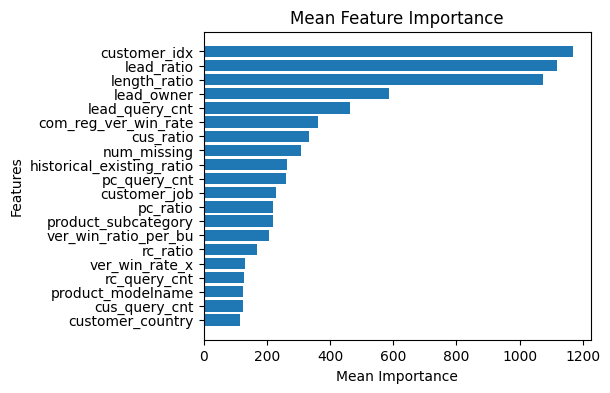

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list1, axis=0))[::-1]
sorted_feature_names = [lgb_model1.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list1, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

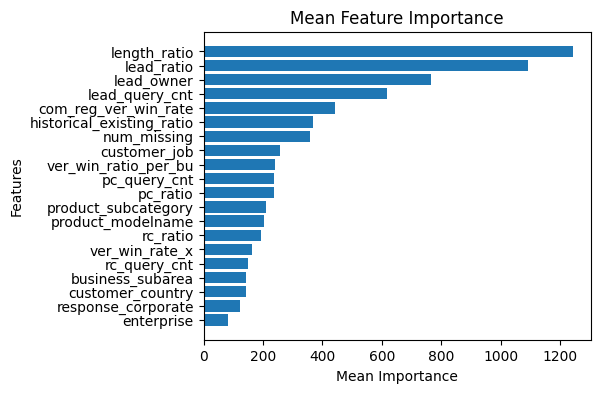

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list2, axis=0))[::-1]
sorted_feature_names = [lgb_model2.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list2, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

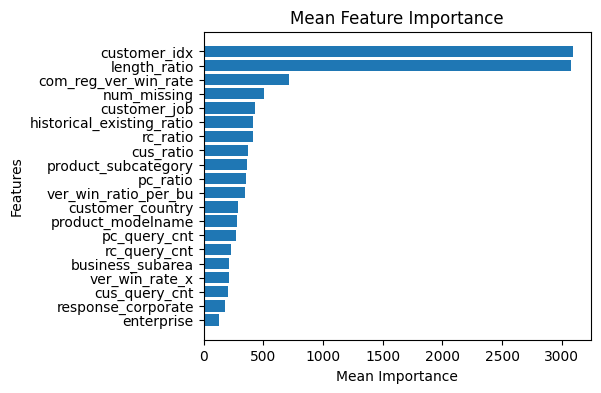

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list3, axis=0))[::-1]
sorted_feature_names = [lgb_model3.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list3, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

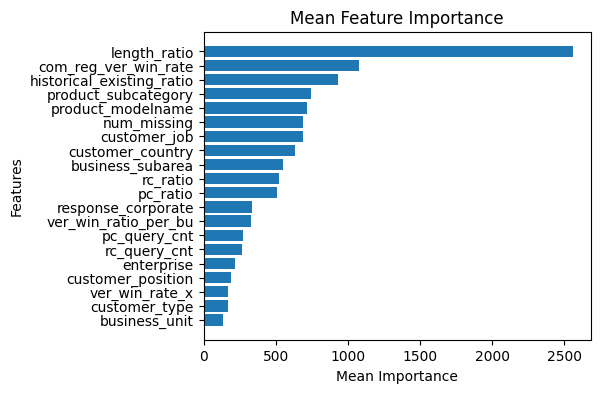

In [ ]:
# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list4, axis=0))[::-1]
sorted_feature_names = [lgb_model4.booster_.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list4, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(5 , 4))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

### 테스트 데이터 예측

In [ ]:
oof_test_preds1 = oof_lgb_test_preds1
oof_test_preds2 = oof_lgb_test_preds2
oof_test_preds3 = oof_lgb_test_preds3
oof_test_preds4 = oof_lgb_test_preds4

In [ ]:
# 예측에 필요한 데이터 분리
test_pred1 = np.where(oof_test_preds1 >= 0.3, 1, 0)
test_pred2 = np.where(oof_test_preds2 >= 0.3, 1, 0)
test_pred3 = np.where(oof_test_preds3 >= 0.2, 1, 0)
test_pred4 = np.where(oof_test_preds4 >= 0.2, 1, 0)

df_test1['is_converted']=test_pred1
df_test2['is_converted']=test_pred2
df_test3['is_converted']=test_pred3
df_test4['is_converted']=test_pred4

In [ ]:
print(sum(test_pred1), df_test1.shape[0]) # cus, lead_owner 있음
print(sum(test_pred2), df_test2.shape[0]) # lead_owner 있음
print(sum(test_pred3), df_test3.shape[0]) # cus 있음
print(sum(test_pred4), df_test4.shape[0]) # 완전 새로운
print('전체 true 개수: ', sum(test_pred1)+sum(test_pred2)+sum(test_pred3)+sum(test_pred4))

178 658
843 3671
22 80
253 862
전체 true 개수:  1296


## 4. 제출하기

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv('/content/drive/MyDrive/lg/submission.csv')
df_sub = df_sub.drop('is_converted', axis=1)
df_sub=pd.merge(df_sub, df_test1[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted'] = df_sub['is_converted'].fillna(0)
df_sub=pd.merge(df_sub, df_test2[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted_y'] = df_sub['is_converted_y'].fillna(0)
df_sub['is_converted'] = df_sub['is_converted_x'] + df_sub['is_converted_y']
df_sub = df_sub.drop(['is_converted_x', 'is_converted_y'], axis=1)
df_sub=pd.merge(df_sub, df_test3[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted_y'] = df_sub['is_converted_y'].fillna(0)
df_sub['is_converted'] = df_sub['is_converted_x'] + df_sub['is_converted_y']
df_sub = df_sub.drop(['is_converted_x', 'is_converted_y'], axis=1)
df_sub=pd.merge(df_sub, df_test4[['id', 'is_converted']], on='id', how='left')
df_sub['is_converted_y'] = df_sub['is_converted_y'].fillna(0)
df_sub['is_converted'] = df_sub['is_converted_x'] + df_sub['is_converted_y']
df_sub = df_sub.drop(['is_converted_x', 'is_converted_y'], axis=1)

df_sub.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,1.0
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1.0
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0.0
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0.0
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1.0


In [ ]:
# DataFrame을 CSV 파일로 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**